In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from collections import Counter
from statsmodels.tsa.api import ExponentialSmoothing

In [2]:
def investigate(i=None,j=None):
    print('Product_ID : ',i,'  ','Country : ',j)
    
    decomposition = sm.tsa.seasonal_decompose(train_visual[(train_visual['Product_ID']==i)&(train_visual['Country']==j)].sort_values(['ds']).set_index('ds')['y'], model='additive')
    fig = decomposition.plot()
    plt.show()

    
    model = ExponentialSmoothing(np.asarray(train_visual[(train_visual['Product_ID']==i)&(train_visual['Country']==j)].sort_values(['ds']).set_index('ds')[['y']].values)
                                 ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()
    forecast = model.forecast(test_visual[(test_visual['Product_ID']==i)&(test_visual['Country']==j)].shape[0])

    df = test_visual[(test_visual['Product_ID']==i)&(test_visual['Country']==j)].sort_values(['ds'])
    df['y'] = np.round(forecast,2)
    train_visual[(train_visual['Product_ID']==i)&(train_visual['Country']==j)].sort_values(['ds']).set_index('ds')['y'].plot(figsize=(20,10))

    df.sort_values(['ds']).set_index('ds')['y'].plot(figsize=(20,10))
    plt.show()

In [3]:
def arima_custom(i=None,j=None,best_param=None,best_param_seasonal=None):
    print('Product_ID : ',i,'  ','Country : ',j)
    mod = sm.tsa.statespace.SARIMAX(train_visual[(train_visual['Product_ID']==i)&(train_visual['Country']==j)].sort_values(['ds']).set_index('ds')[['y']],
                                            order=best_param,
                                            seasonal_order=best_param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

    results = mod.fit()
    
    pred_uc = results.get_forecast(steps=test_visual[(test_visual['Product_ID']==i)&(test_visual['Country']==j)].shape[0])

    # Get confidence intervals of forecasts
    pred_ci = pred_uc.conf_int()
    forecast = pred_uc.predicted_mean

    df = test_visual[(test_visual['Product_ID']==i)&(test_visual['Country']==j)].sort_values(['ds'])
    df['y'] = np.round(forecast.values,2)
    train_visual[(train_visual['Product_ID']==i)&(train_visual['Country']==j)].sort_values(['ds']).set_index('ds')['y'].plot(figsize=(20,10))

    df.sort_values(['ds']).set_index('ds')['y'].plot(figsize=(20,10))
    plt.show()
    
    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()    

In [4]:
def arima_investigate(i=None,j=None):

    print('Product_ID : ',i,'  ','Country : ',j)
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    # print('Examples of parameter combinations for Seasonal ARIMA...')
    # print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    # print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    # print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
    # print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

    warnings.filterwarnings("ignore") # specify to ignore warning messages
    best_param, best_param_seasonal,best_aic = None,None,999999999999999999
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(train_visual[(train_visual['Product_ID']==i)&(train_visual['Country']==j)].sort_values(['ds']).set_index('ds')[['y']],
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                if results.aic<best_aic:
                    best_aic = results.aic
                    best_param = param
                    best_param_seasonal = param_seasonal
                    print('Current best ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                    
                    pred_uc = results.get_forecast(steps=test_visual[(test_visual['Product_ID']==i)&(test_visual['Country']==j)].shape[0])

                    # Get confidence intervals of forecasts
                    pred_ci = pred_uc.conf_int()
                    forecast = pred_uc.predicted_mean

                    df = test_visual[(test_visual['Product_ID']==i)&(test_visual['Country']==j)].sort_values(['ds'])
                    df['y'] = np.round(forecast.values,2)
                    train_visual[(train_visual['Product_ID']==i)&(train_visual['Country']==j)].sort_values(['ds']).set_index('ds')['y'].plot(figsize=(20,10))

                    df.sort_values(['ds']).set_index('ds')['y'].plot(figsize=(20,10))
                    plt.show()        
            except:
                continue



In [5]:
def calculate_arima_for(i=None,j=None,best_param=None,best_param_seasonal=None):
    result = pd.DataFrame()

    print('Product_ID : ',i,'  ','Country : ',j)
    mod = sm.tsa.statespace.SARIMAX(train_visual[(train_visual['Product_ID']==i)&(train_visual['Country']==j)].sort_values(['ds']).set_index('ds')[['y']],
                                            order=best_param,
                                            seasonal_order=best_param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

    results = mod.fit()

    pred_uc = results.get_forecast(steps=test_visual[(test_visual['Product_ID']==i)&(test_visual['Country']==j)].shape[0])

    # Get confidence intervals of forecasts
    pred_ci = pred_uc.conf_int()
    forecast = pred_uc.predicted_mean

    df = test_visual[(test_visual['Product_ID']==i)&(test_visual['Country']==j)].sort_values(['ds'])
    df['y'] = np.round(forecast.values,2)

    result['S_No'] = df['S_No'].values
    result['y'] = df['y'].values

    return result

In [6]:
train_visual = pd.read_csv('Data/yds_train2018.csv')
test_visual = pd.read_csv('Data/yds_test2018.csv')

In [7]:
train_visual = train_visual.groupby(['Year','Month','Product_ID','Country'],as_index=False).agg({'Sales':'sum'})

In [8]:
test_visual['Sales'] = 0

train_visual['Year'] = train_visual['Year'].apply(lambda x : str(x))
train_visual['Month'] = train_visual['Month'].apply(lambda x : str(x))

test_visual['Year'] = test_visual['Year'].apply(lambda x : str(x))
test_visual['Month'] = test_visual['Month'].apply(lambda x : str(x))

train_visual['date'] = pd.to_datetime(train_visual['Year']+'-'+train_visual['Month']+'-'+str(1))
test_visual['date'] = pd.to_datetime(test_visual['Year']+'-'+test_visual['Month']+'-'+str(1))

train_visual.rename(columns={'Sales':'y','date':'ds'},inplace=True)
test_visual.rename(columns={'Sales':'y','date':'ds'},inplace=True)

In [9]:
from statsmodels import api as sm

In [10]:
import warnings
import itertools
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9


<h1>In Depth Exploration for ARIMA</h1>

Product_ID :  1    Country :  Argentina
Product_ID :  1    Country :  Argentina


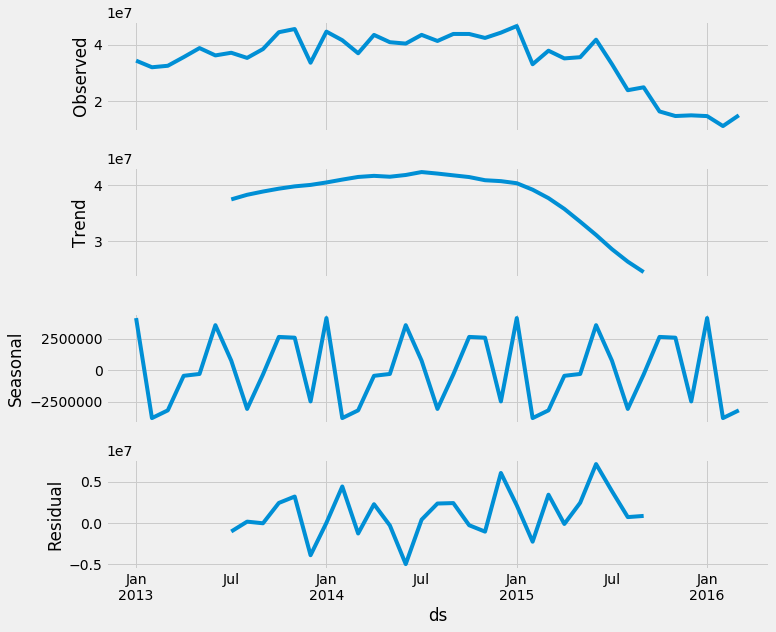

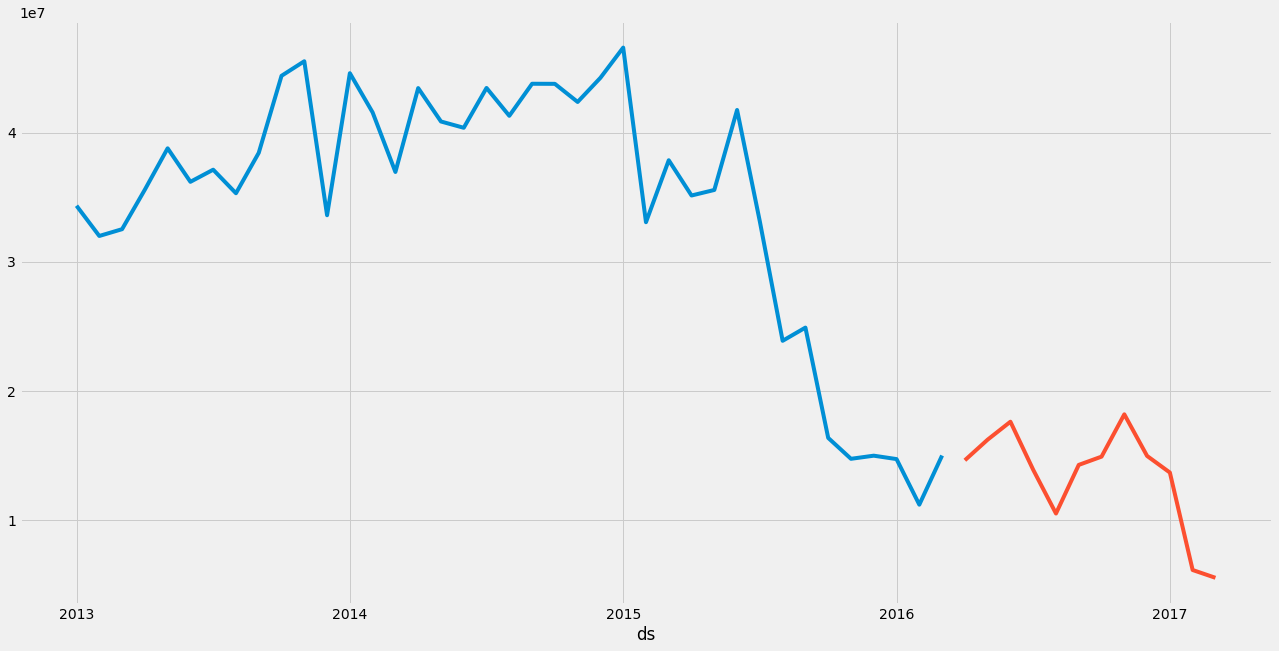

Product_ID :  1    Country :  Argentina
Current best ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1432.283028116384


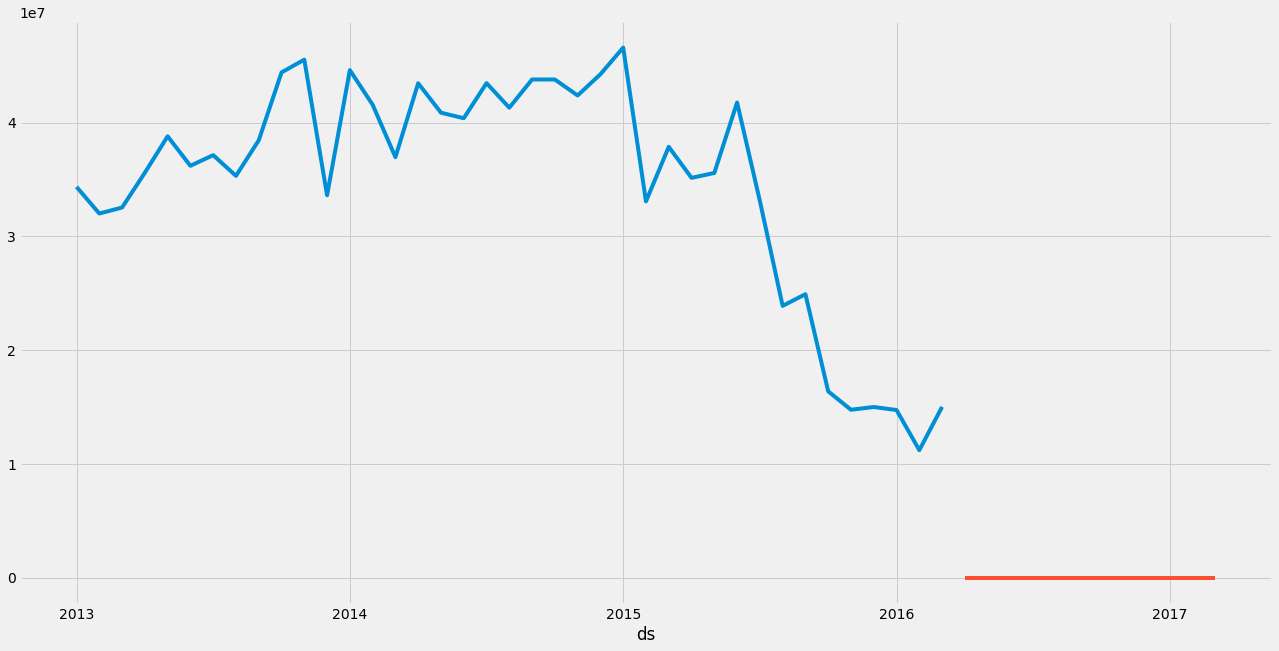

Current best ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:936.7716544303346


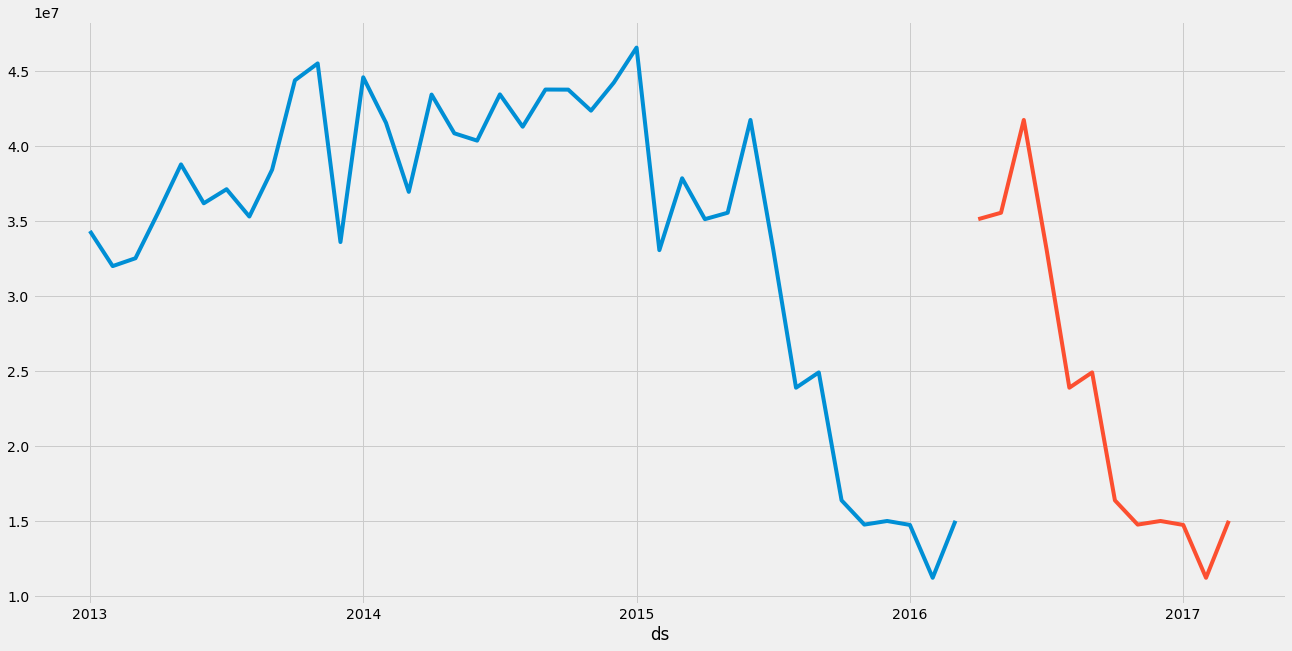

Current best ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:547.8824821356052


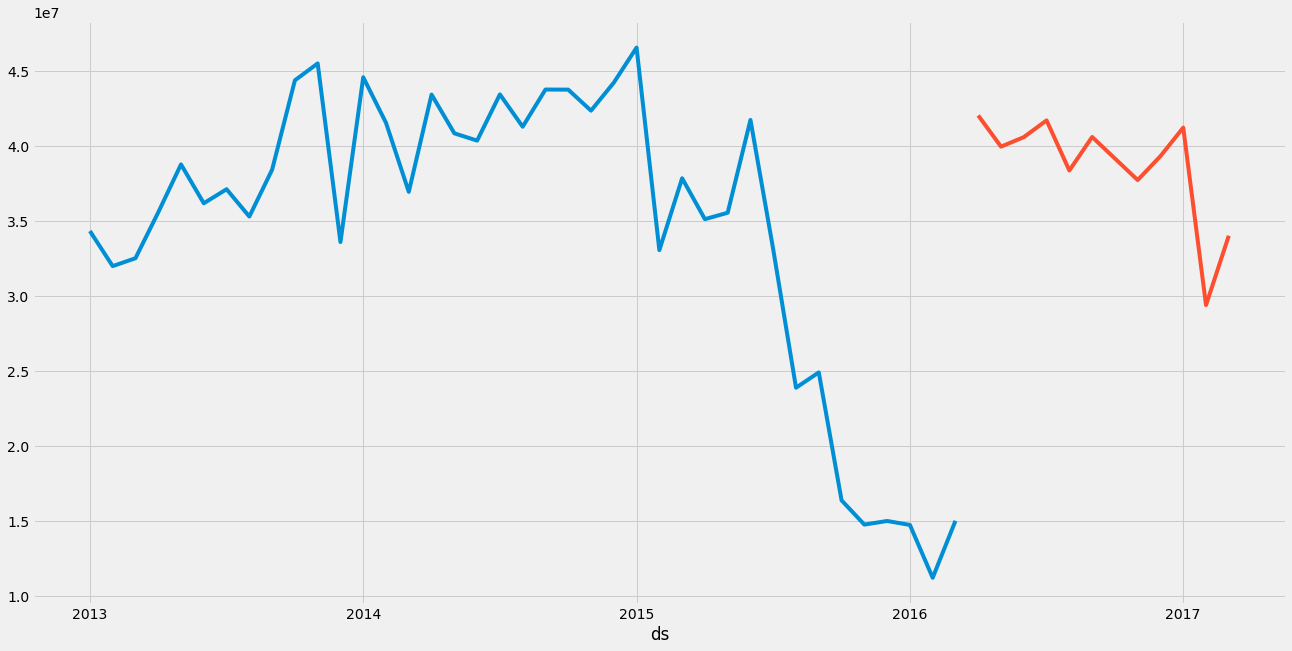

Current best ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:537.1341224823024


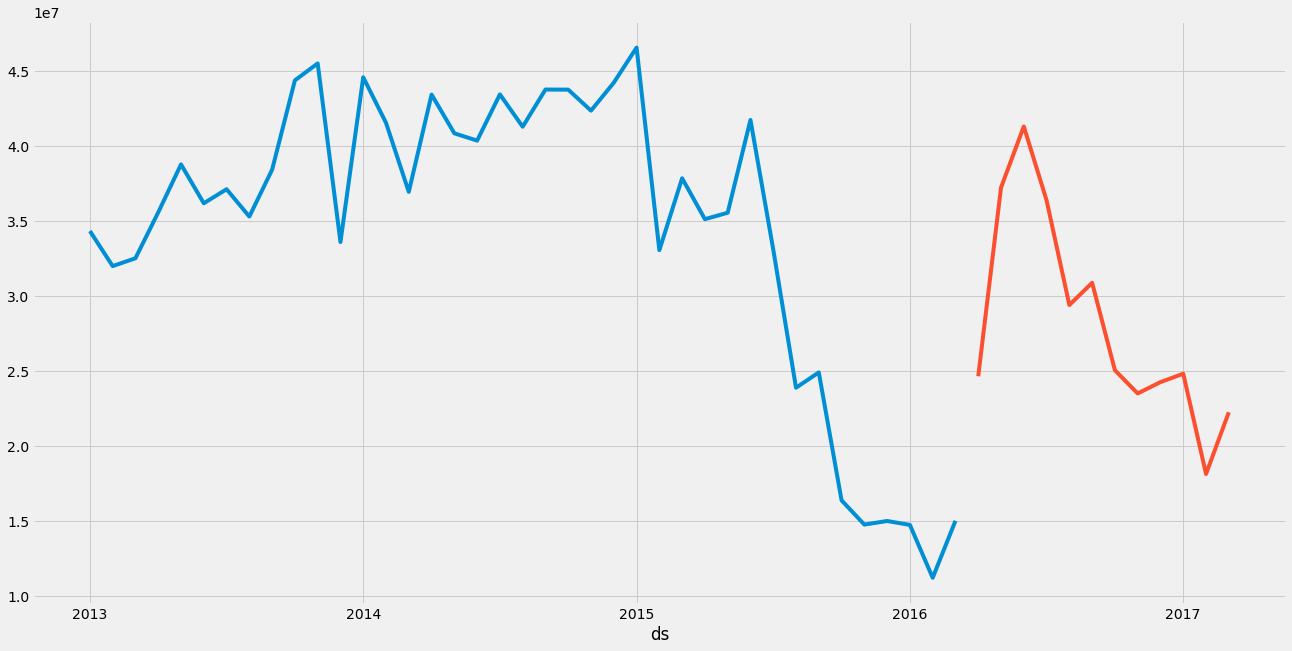

Current best ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:484.6225044622539


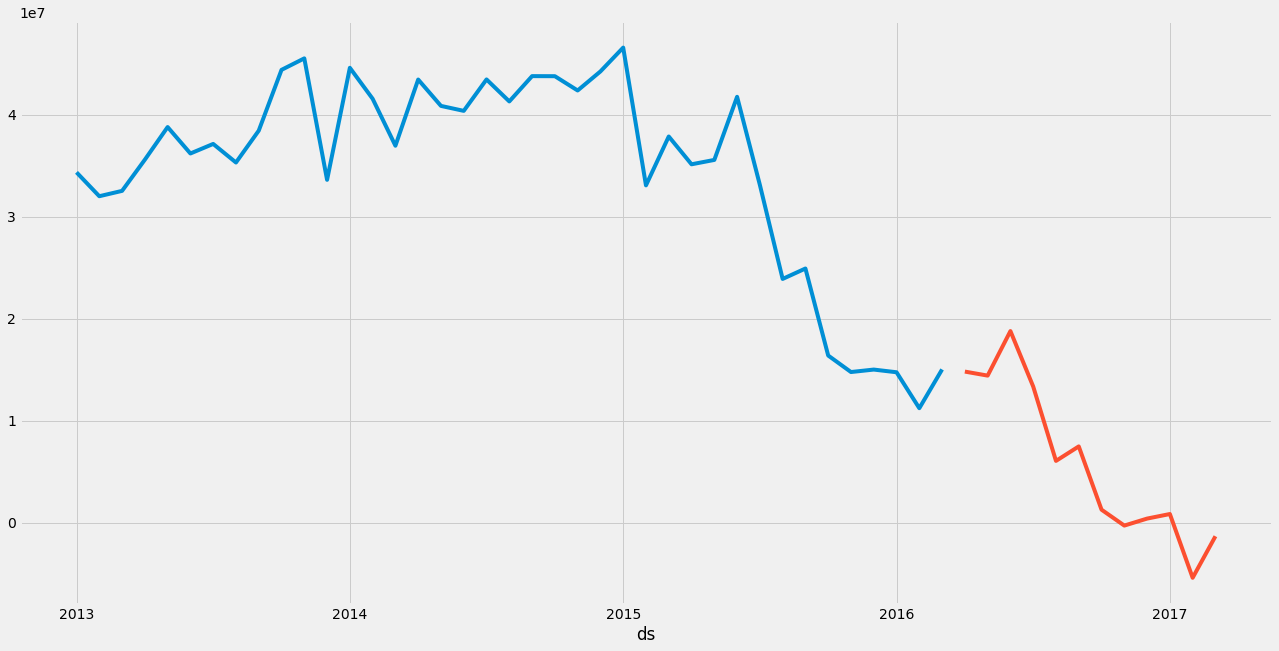

Current best ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:449.95099008323956


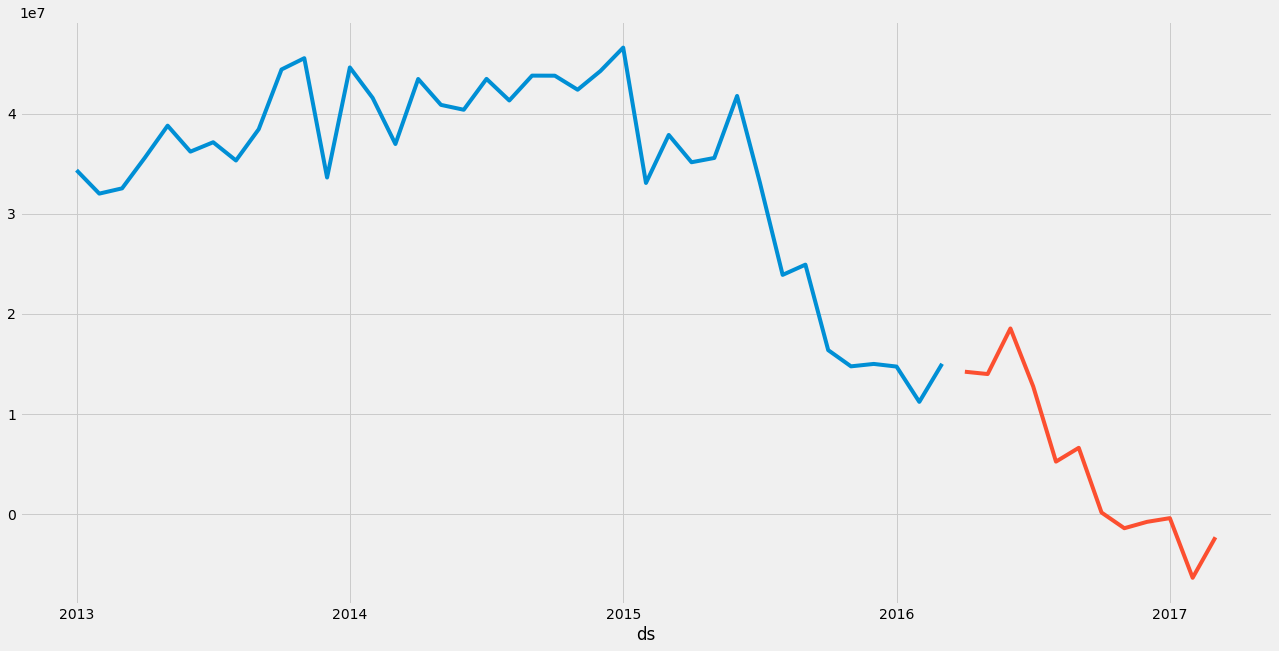

Product_ID :  1    Country :  Columbia
Product_ID :  1    Country :  Columbia


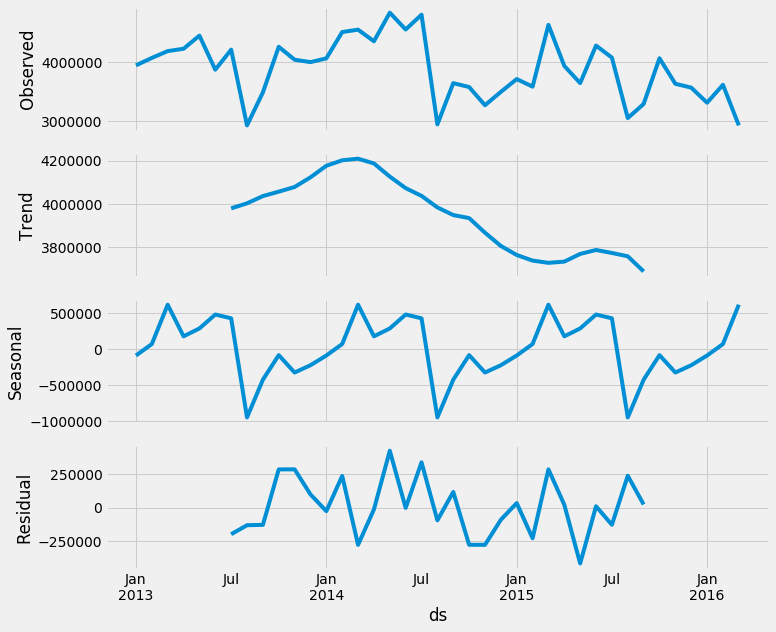

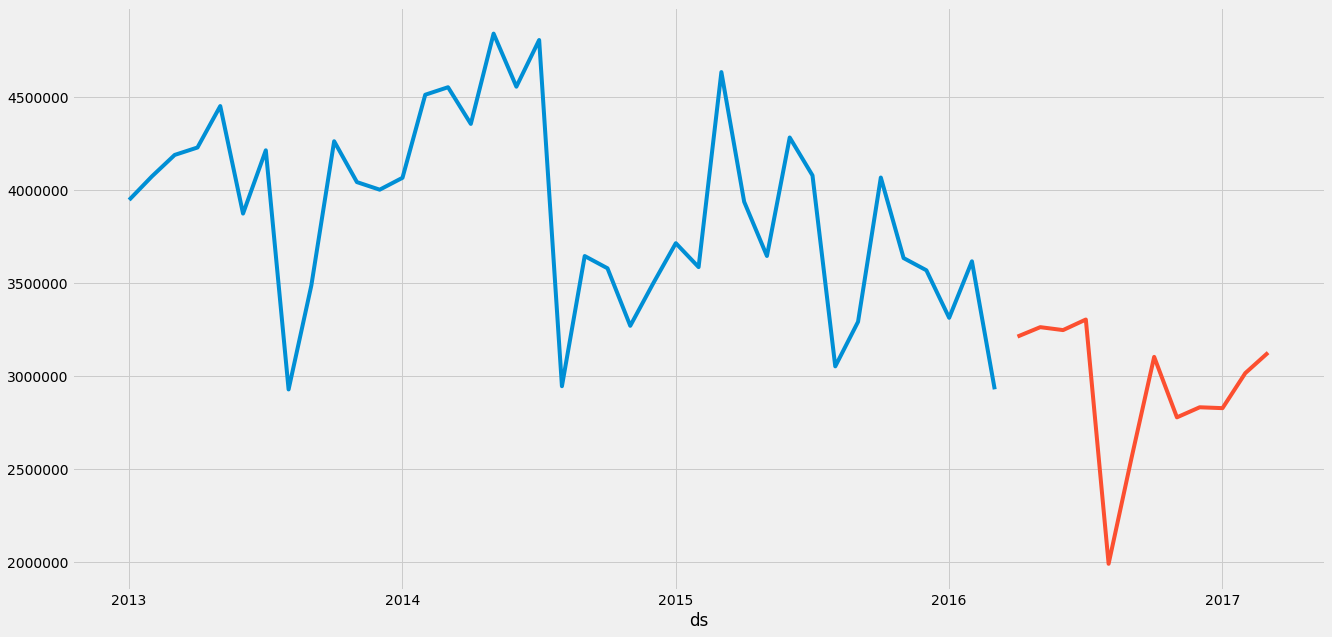

Product_ID :  1    Country :  Columbia
Current best ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1263.6961253475201


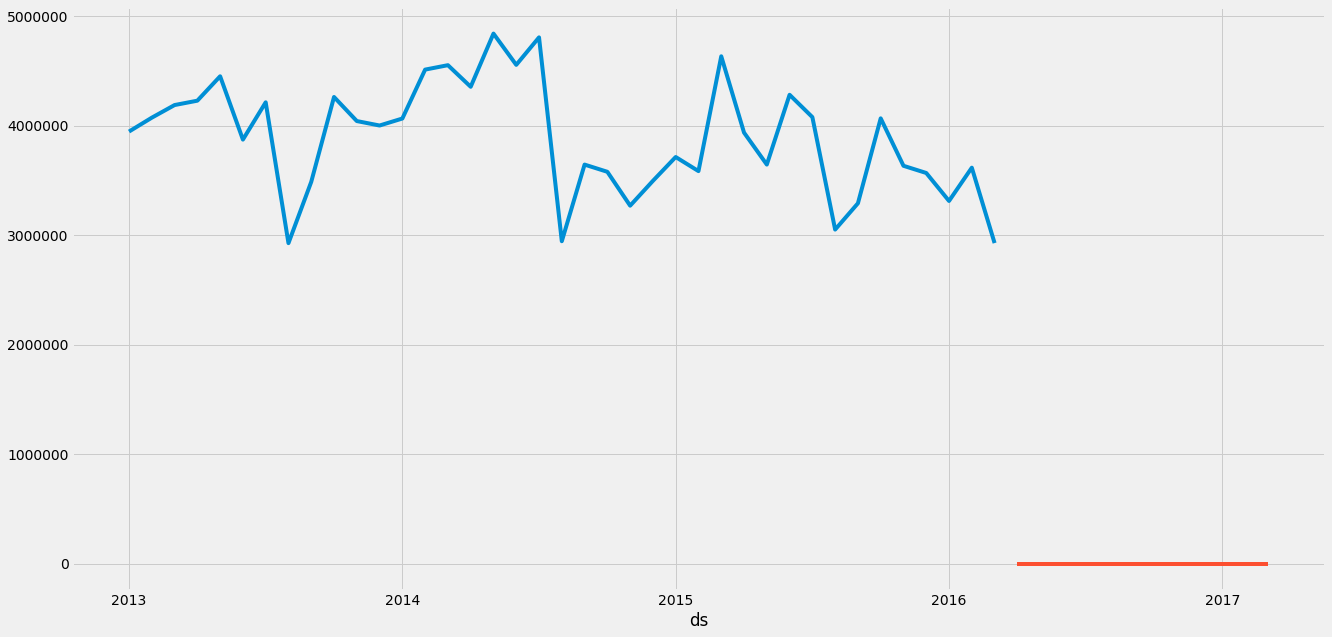

Current best ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:770.2887624015397


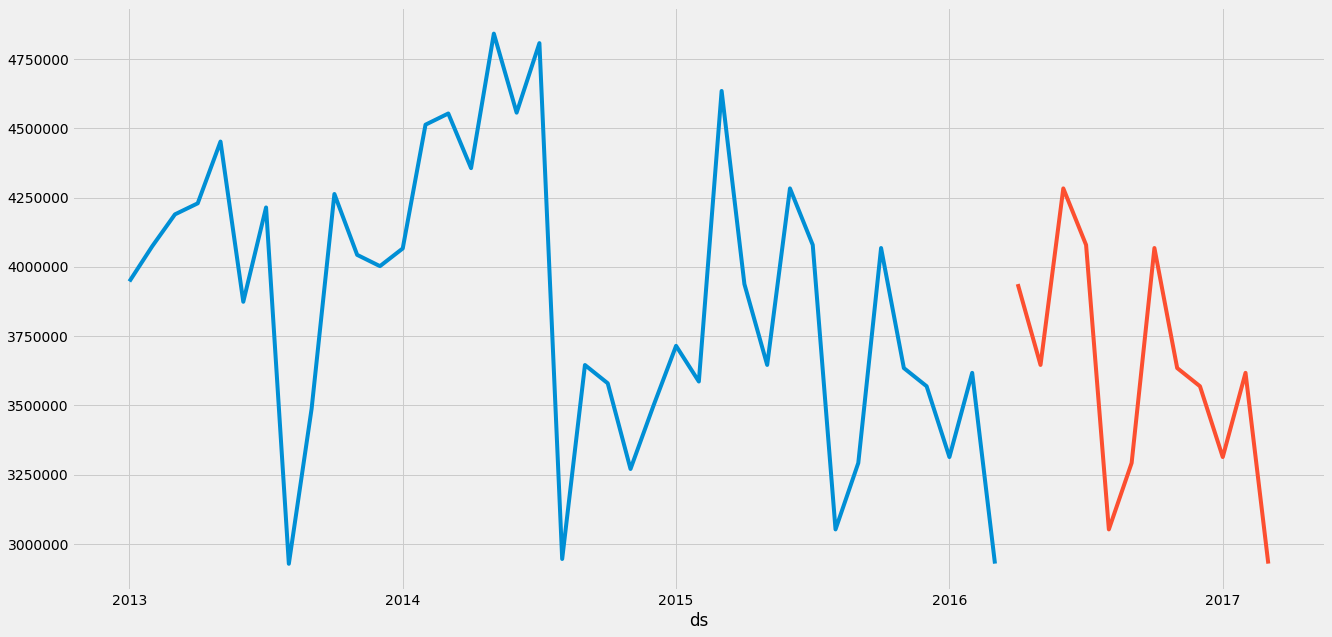

Current best ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:445.579097641312


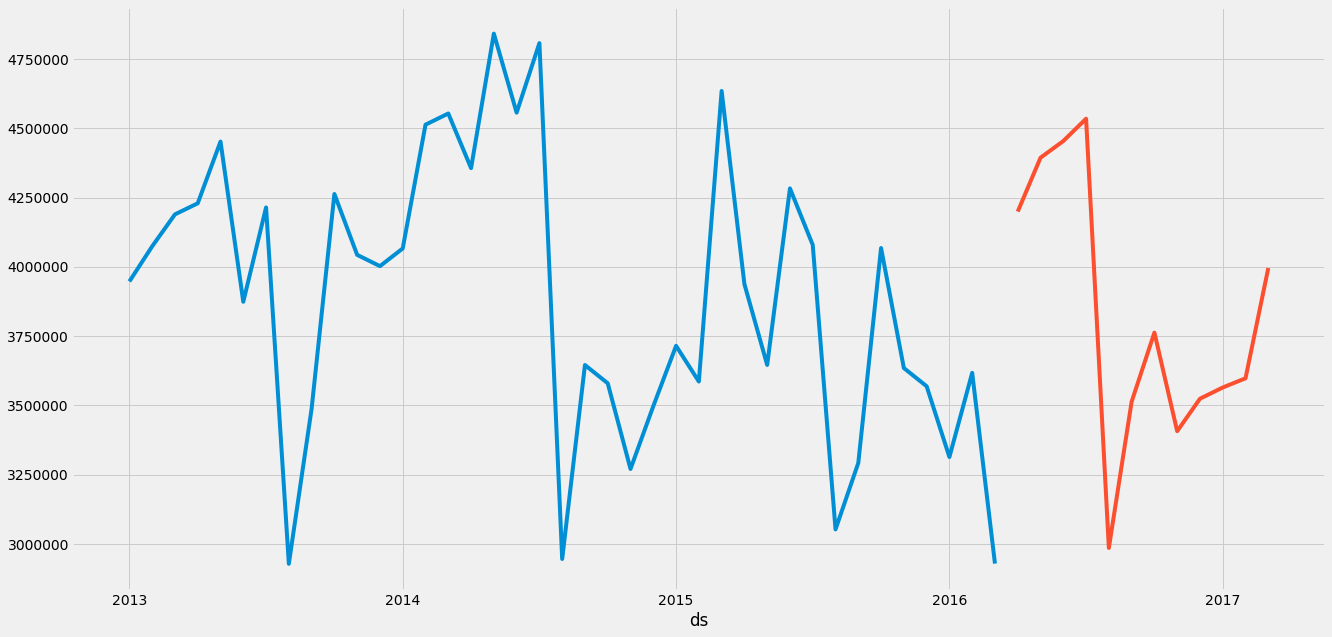

Current best ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:413.9231123986855


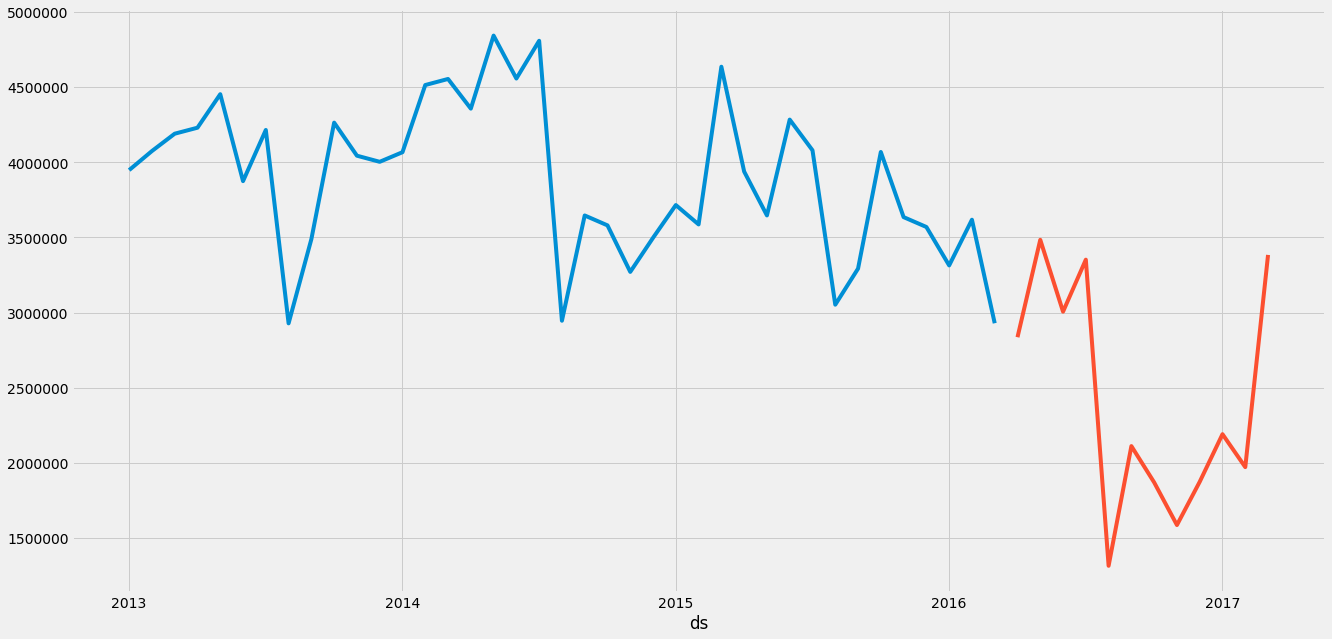

Current best ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:384.70185300688297


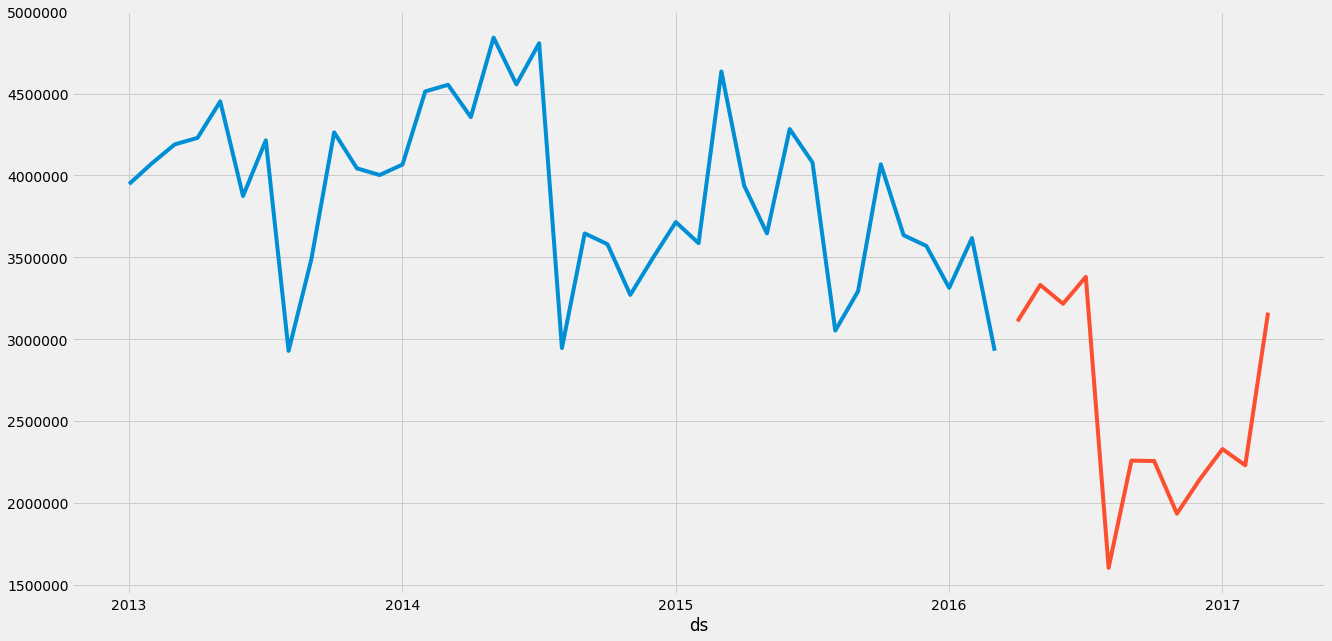

Product_ID :  2    Country :  Argentina
Product_ID :  2    Country :  Argentina


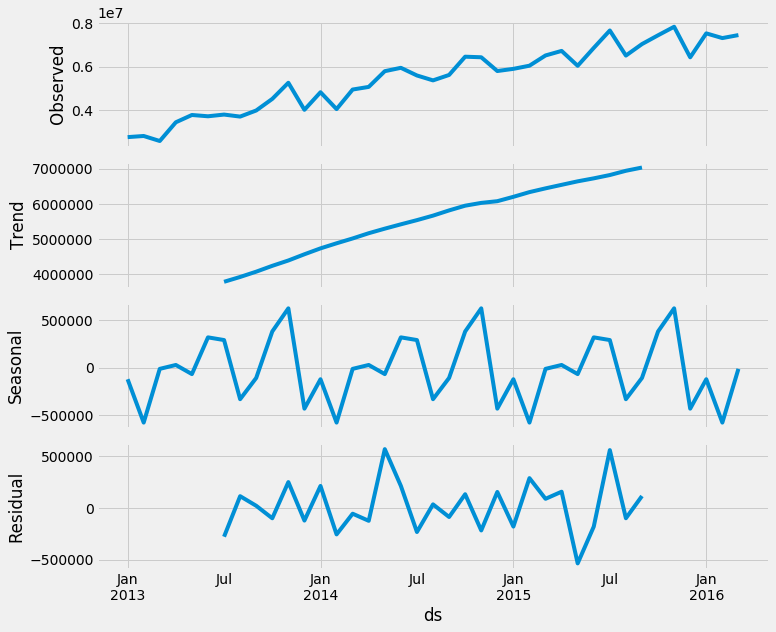

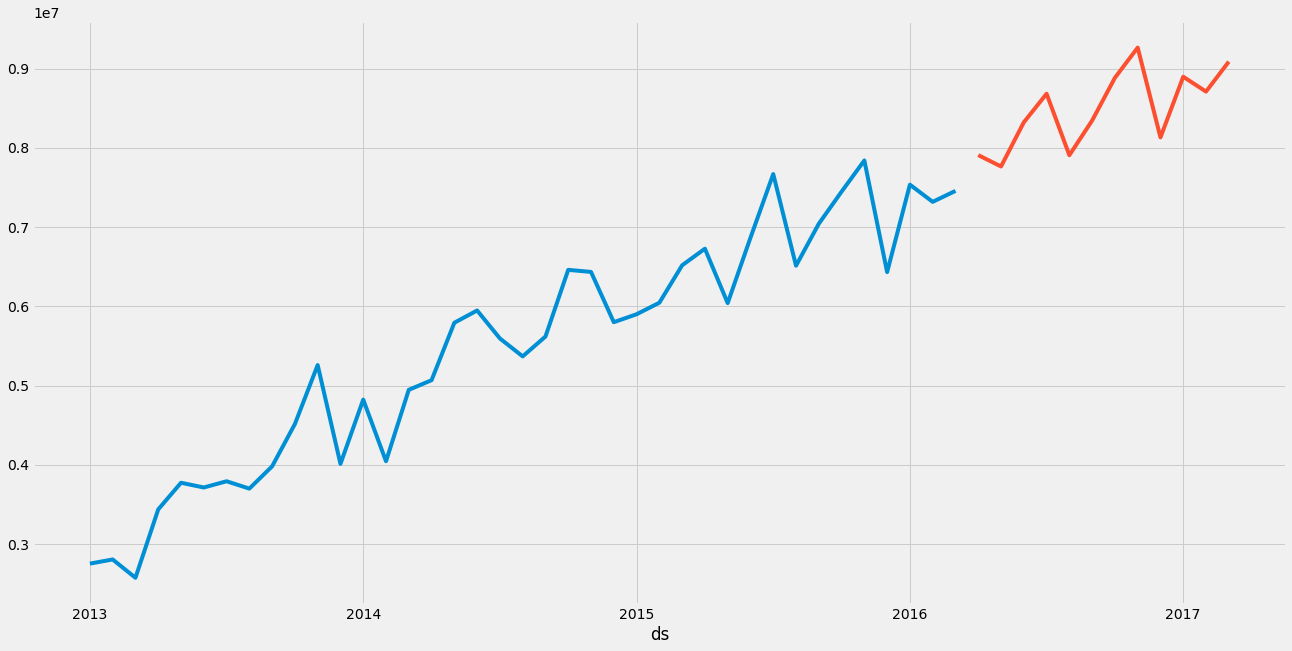

Product_ID :  2    Country :  Argentina
Current best ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1292.4848774880522


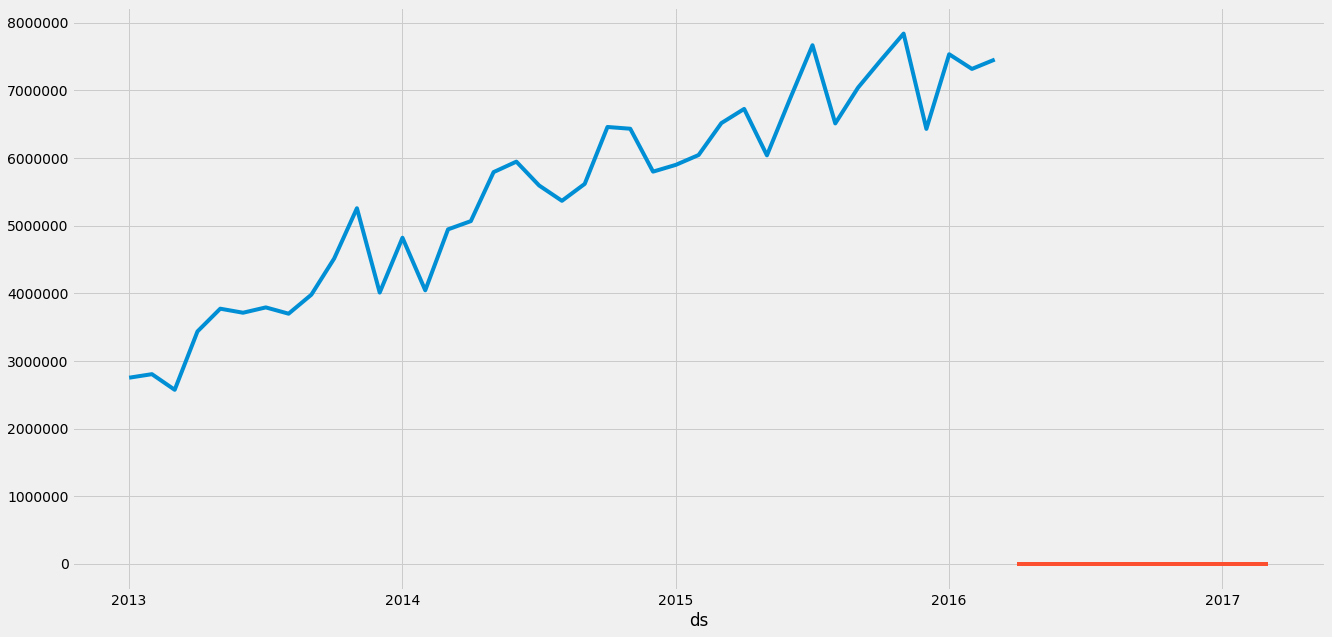

Current best ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:819.0791988034573


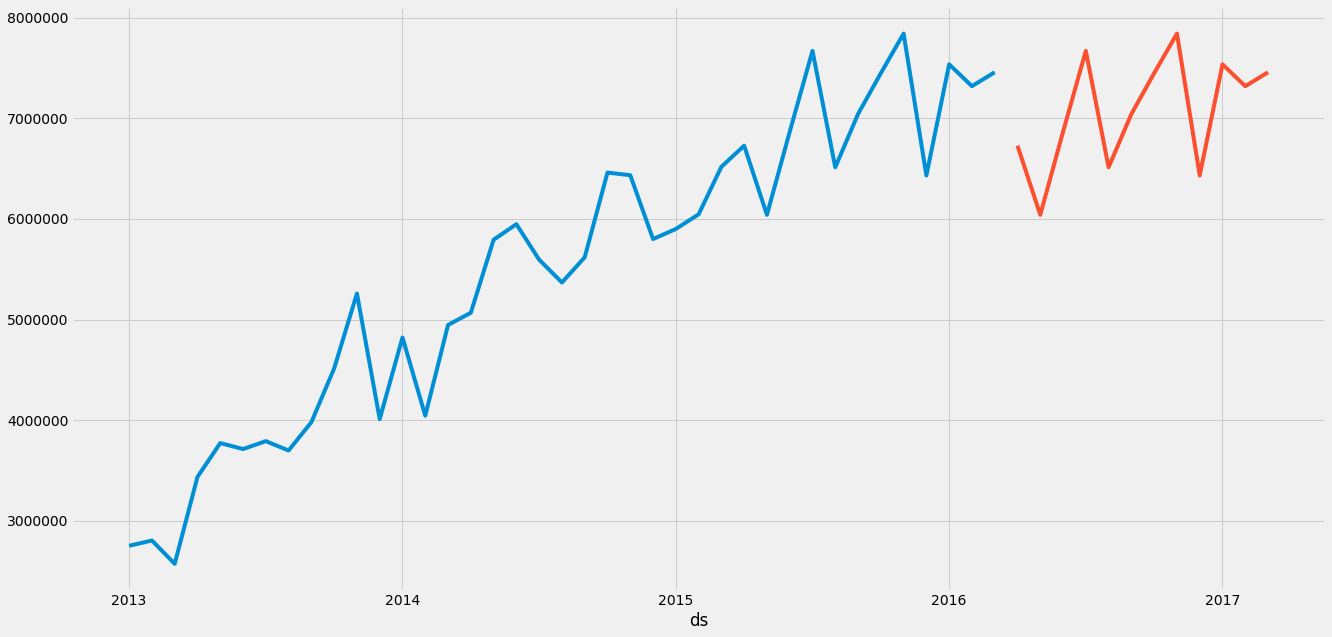

Current best ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:812.8641549532772


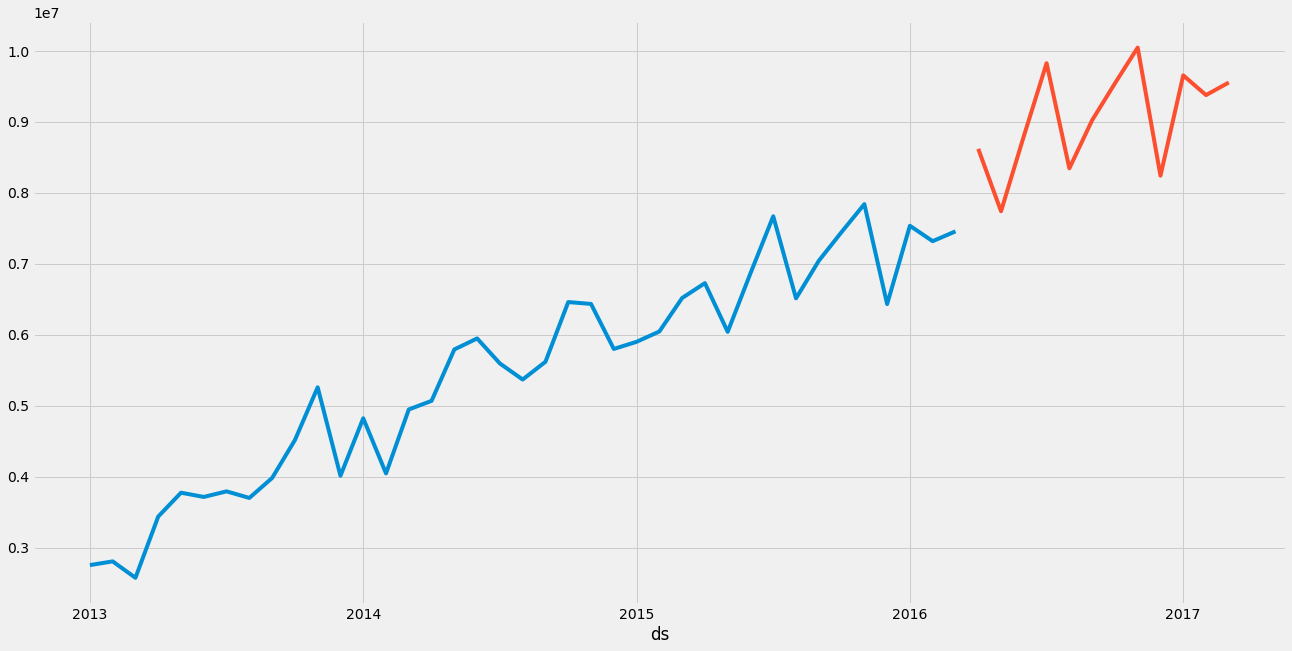

Current best ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:809.4865800399265


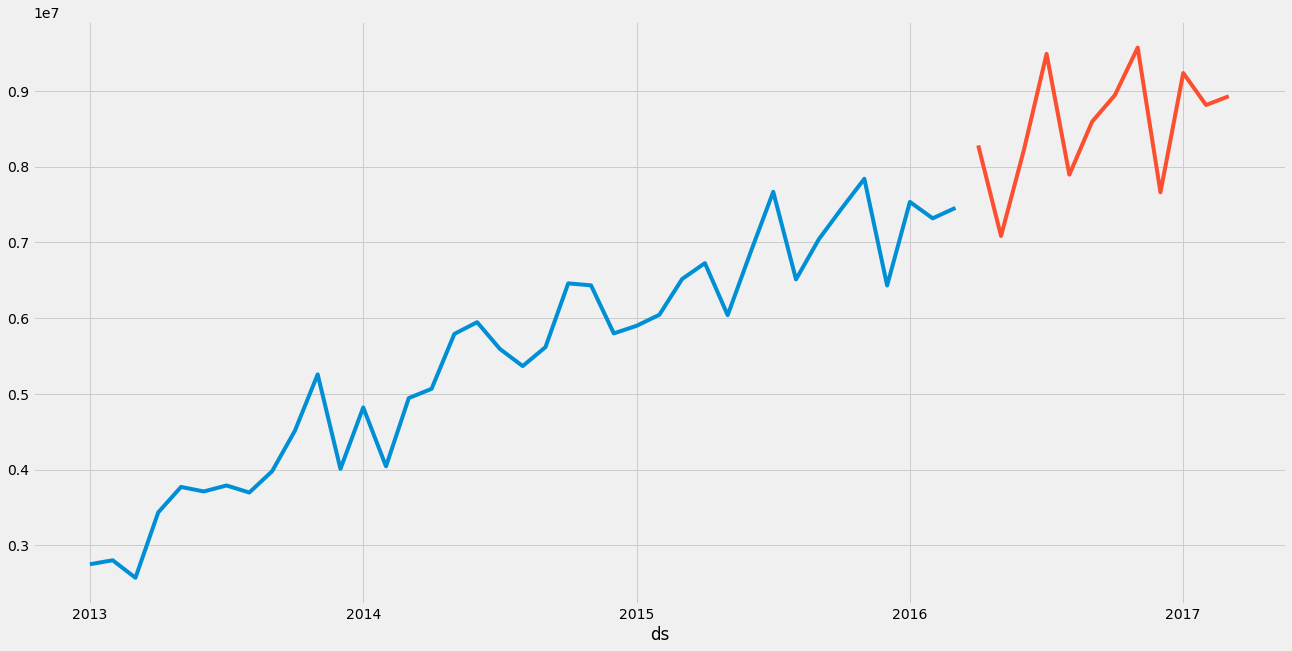

Current best ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:446.9278883606533


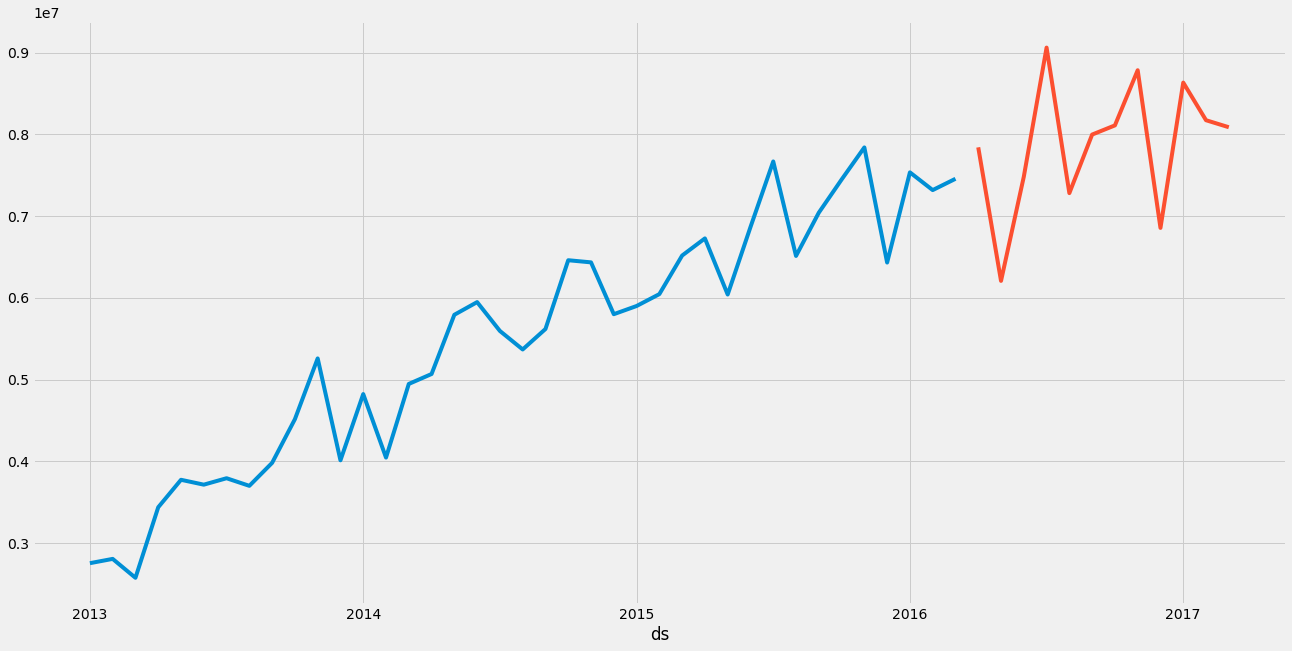

Current best ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:416.621671076035


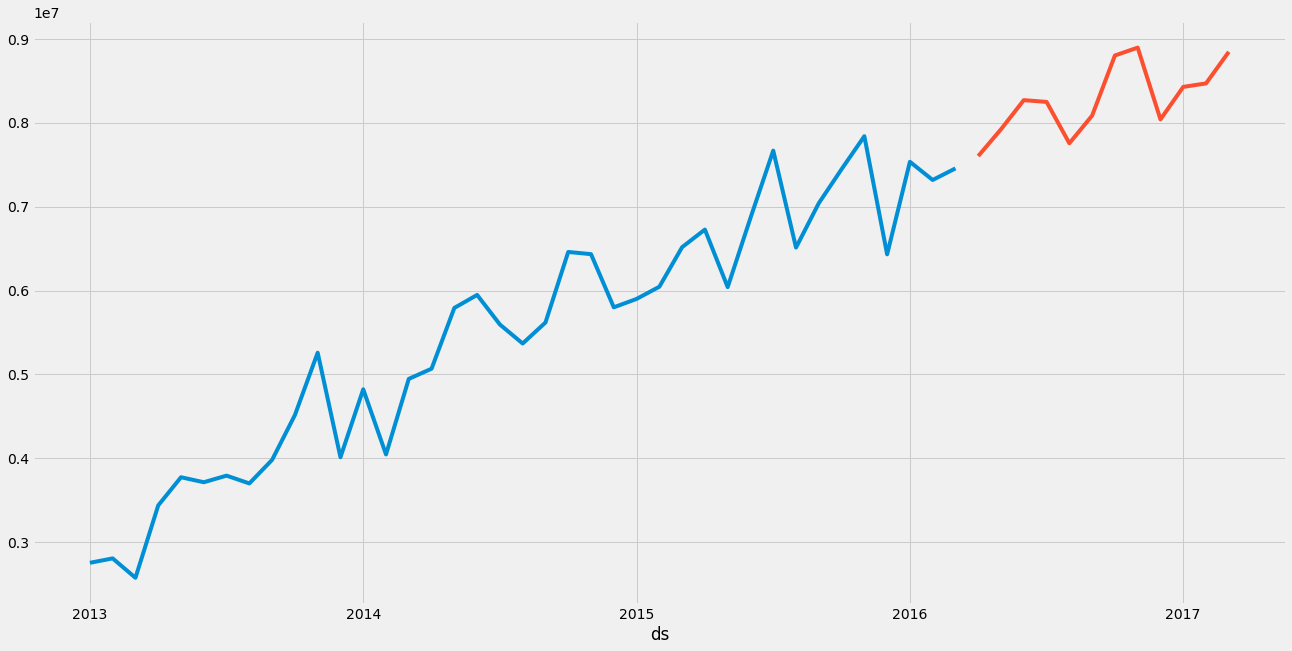

Current best ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:414.364447205322


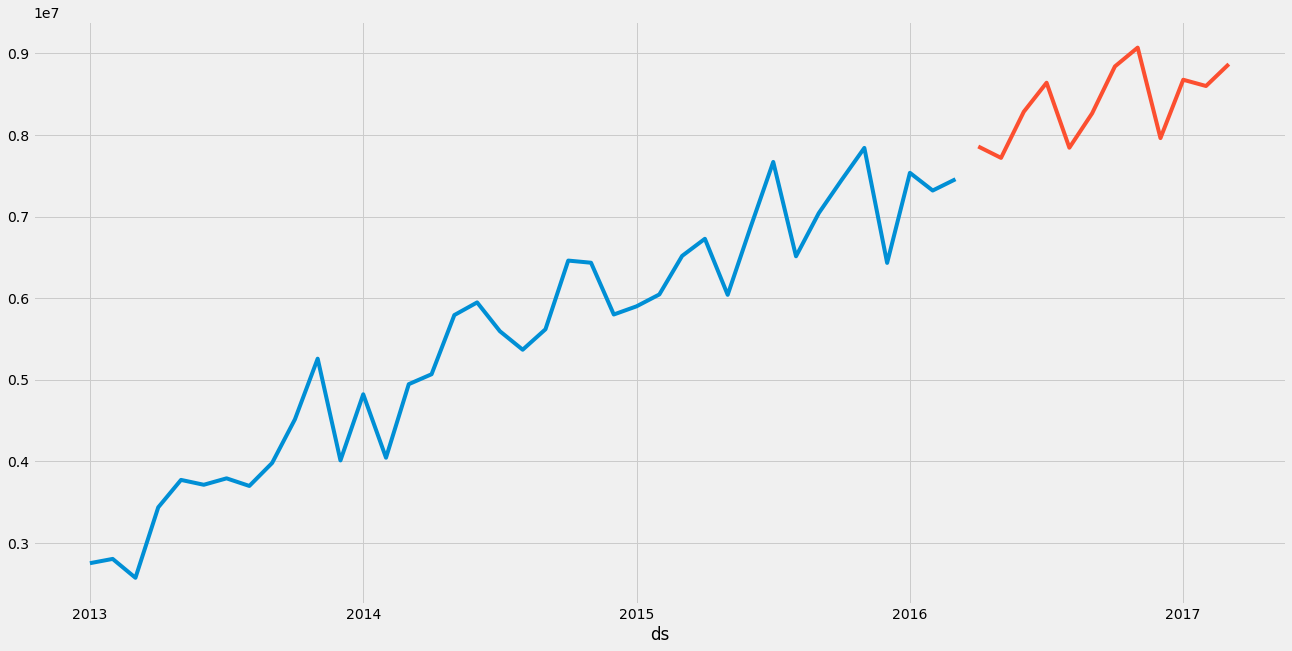

Current best ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:413.8776348191926


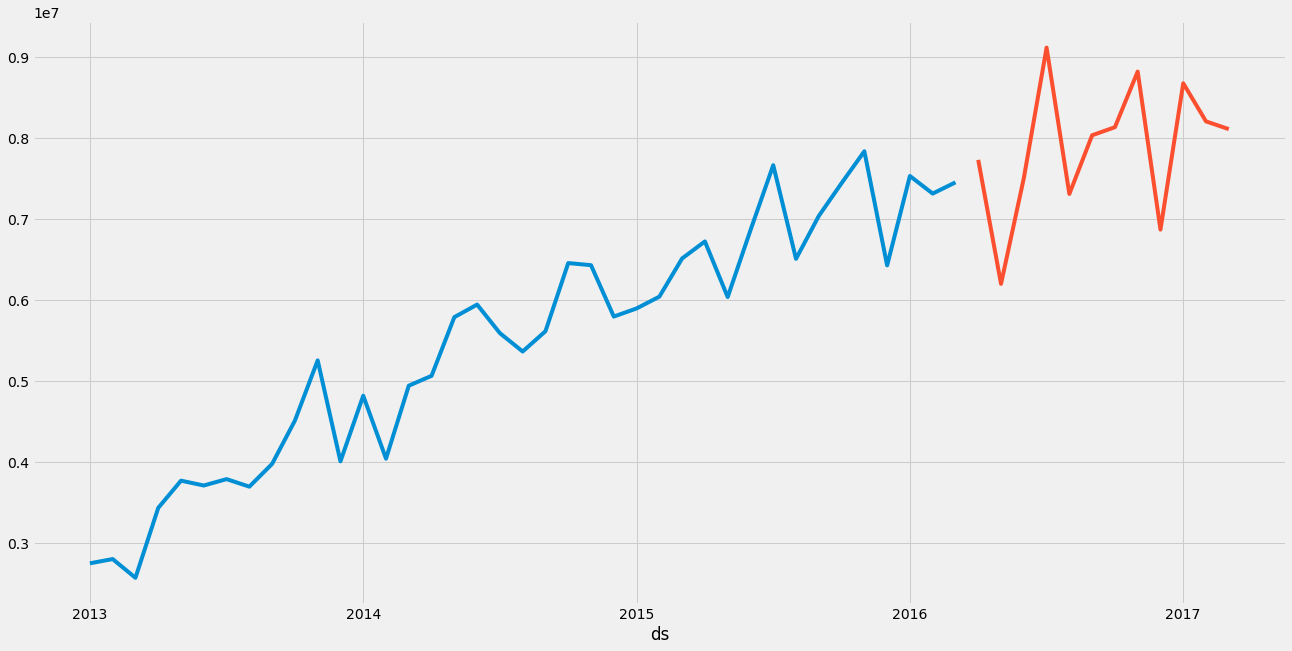

Current best ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:389.4099568431533


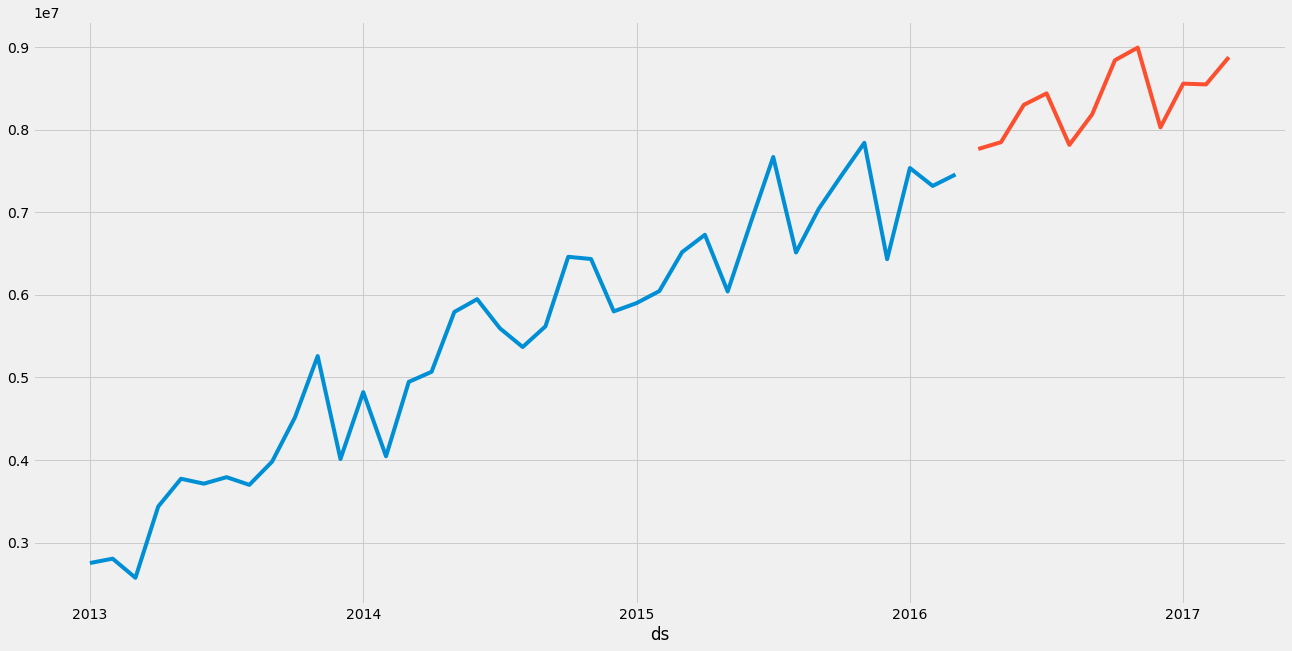

Current best ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:388.1951588165986


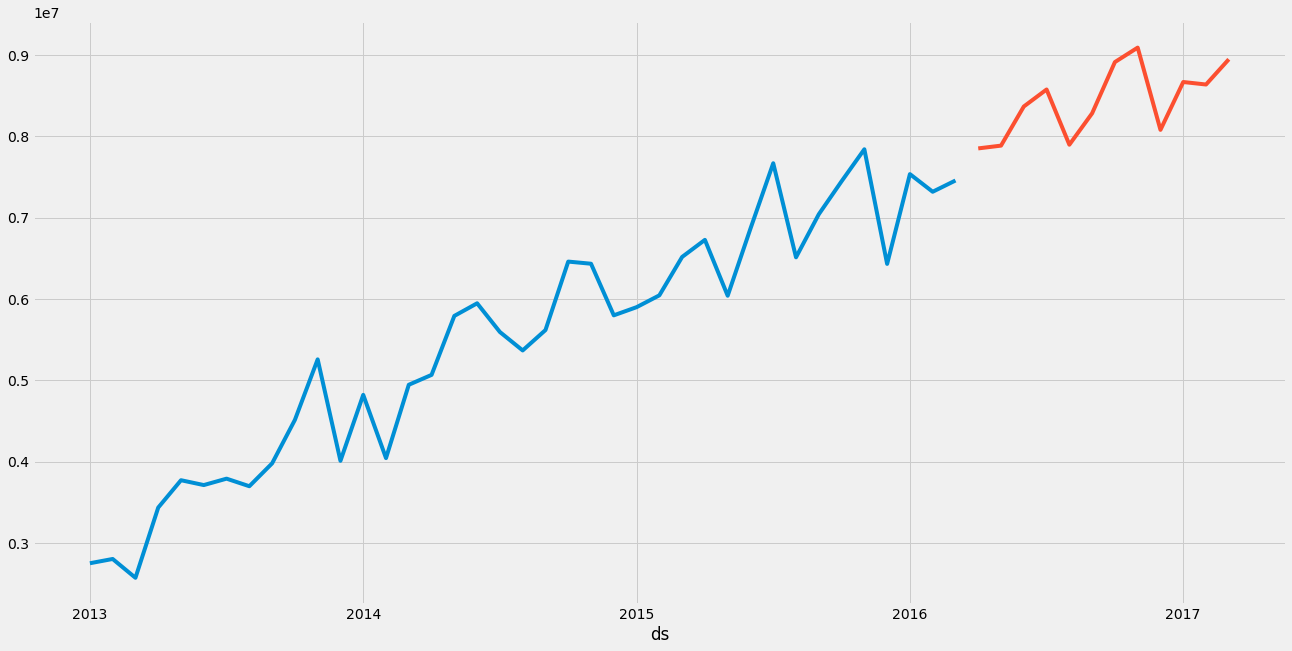

Product_ID :  2    Country :  Columbia
Product_ID :  2    Country :  Columbia


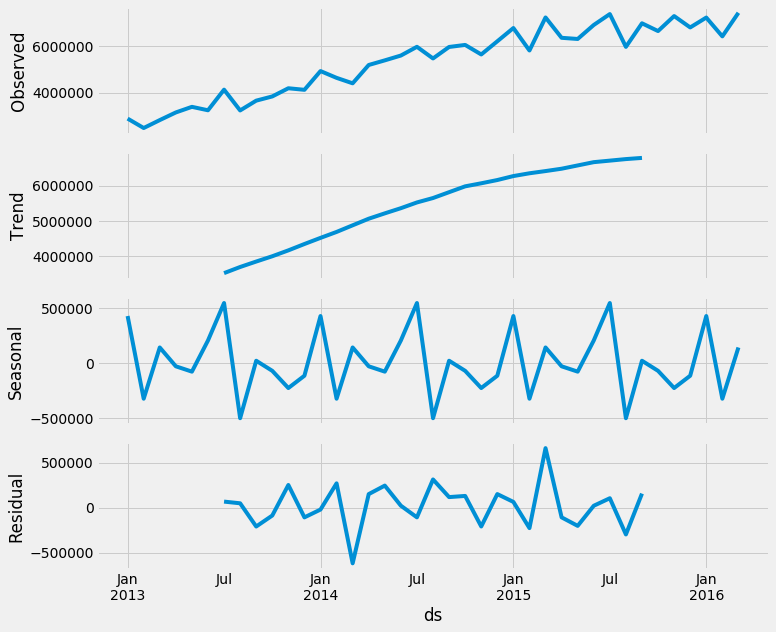

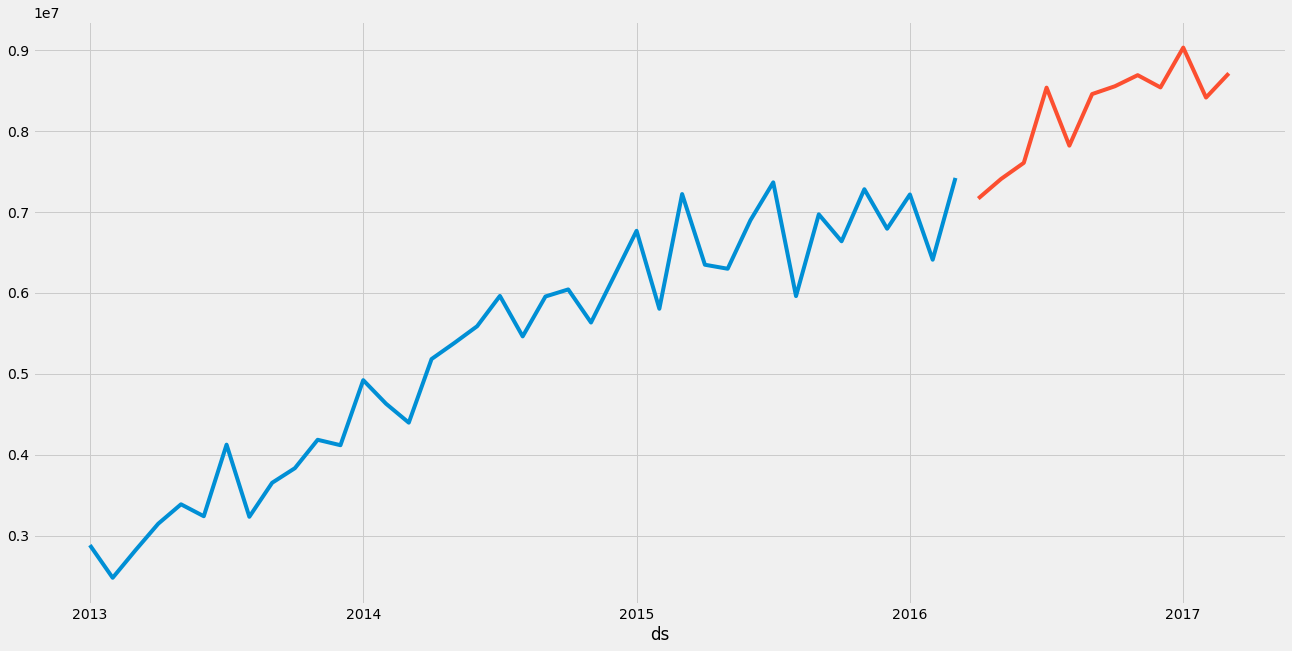

Product_ID :  2    Country :  Columbia
Current best ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1290.5272190221888


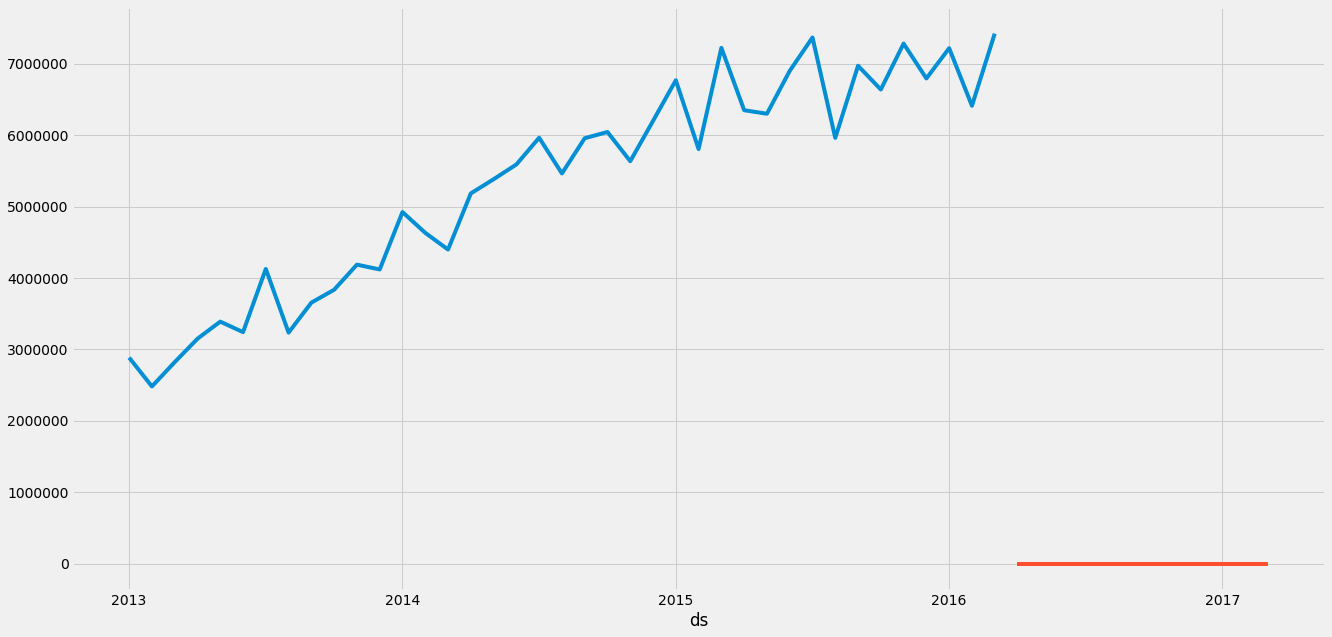

Current best ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:821.5447183214882


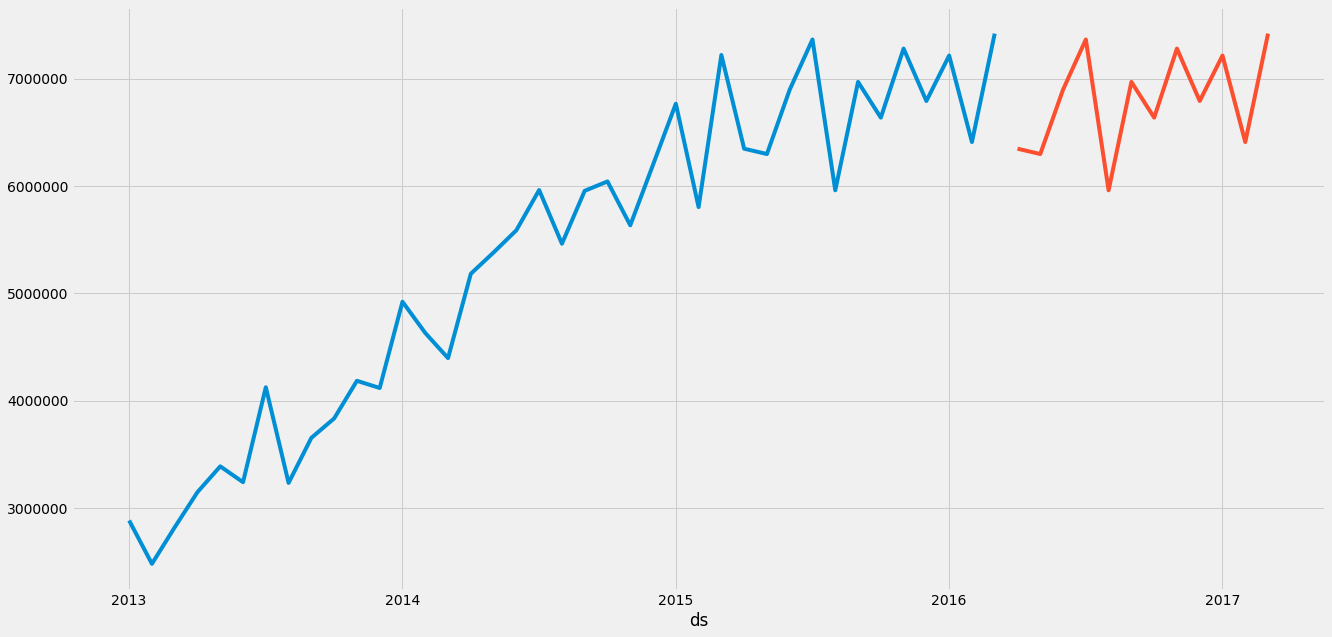

Current best ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:452.53925411458107


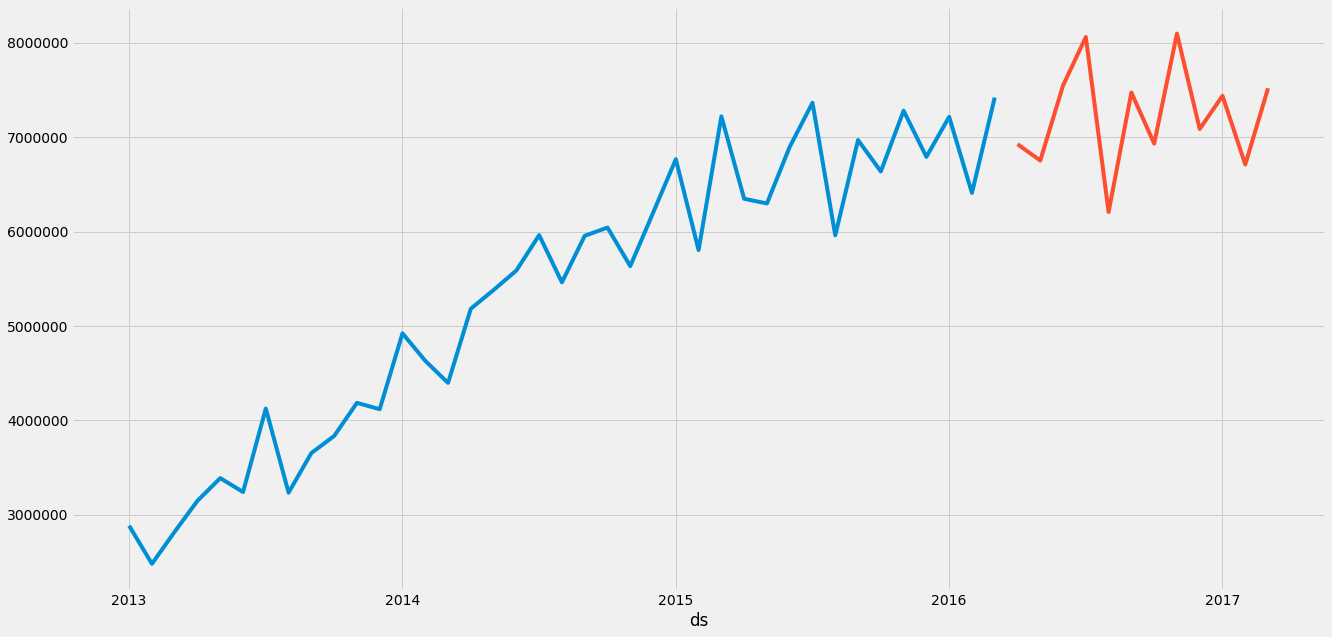

Current best ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:419.9850072027117


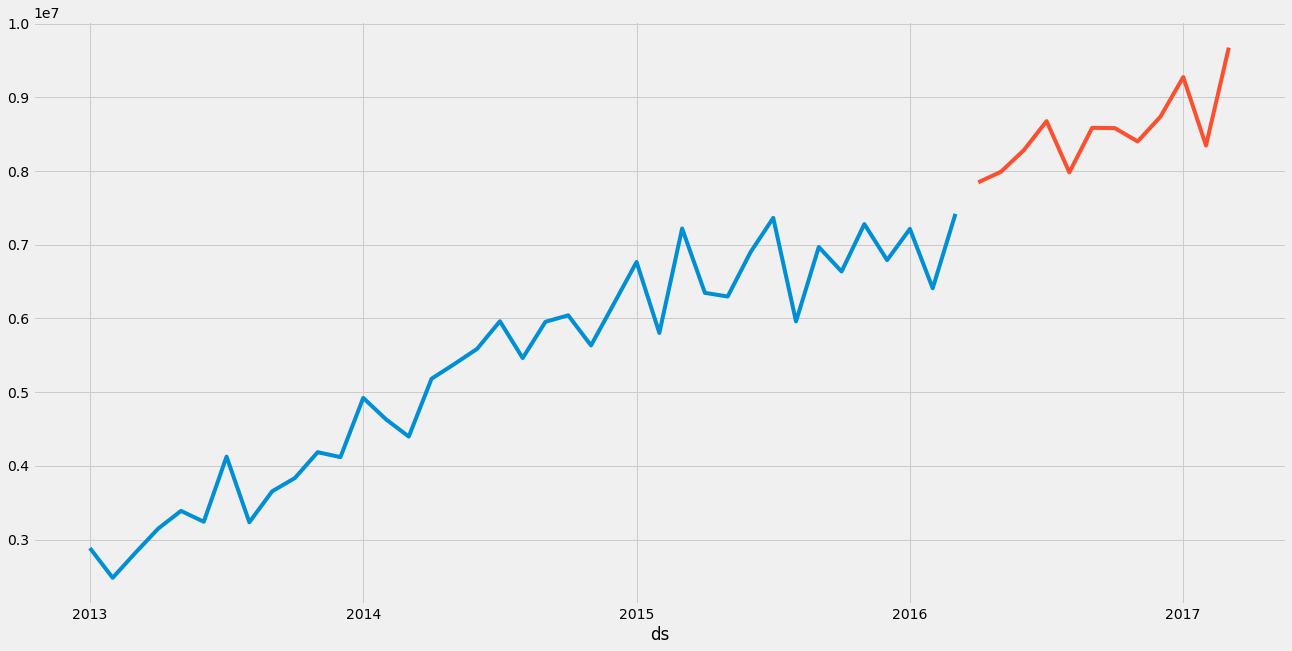

Current best ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:418.40107470713644


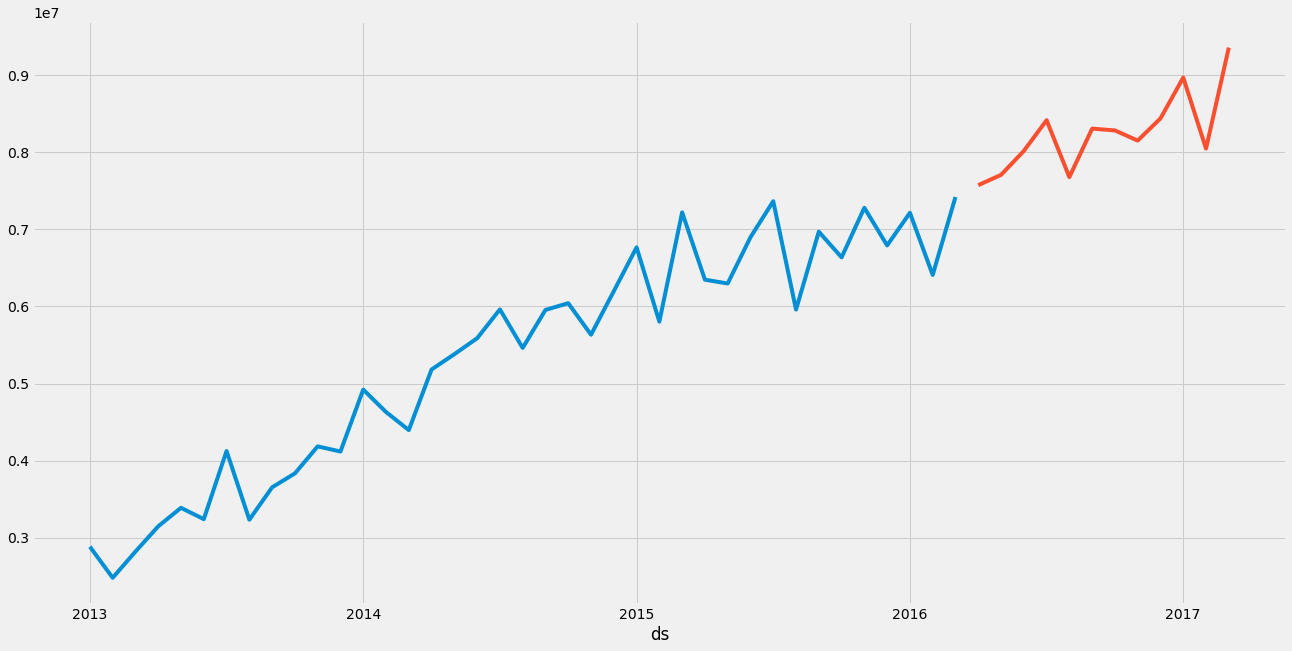

Current best ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:411.6370729512669


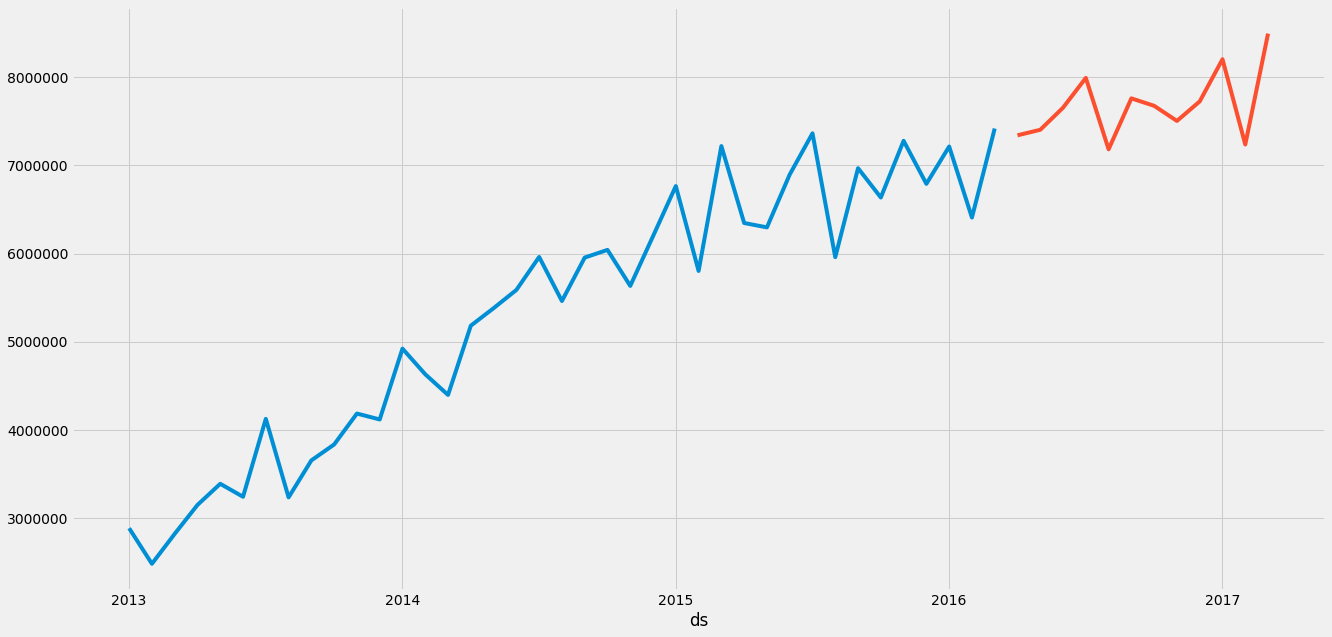

Current best ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:387.96053224923156


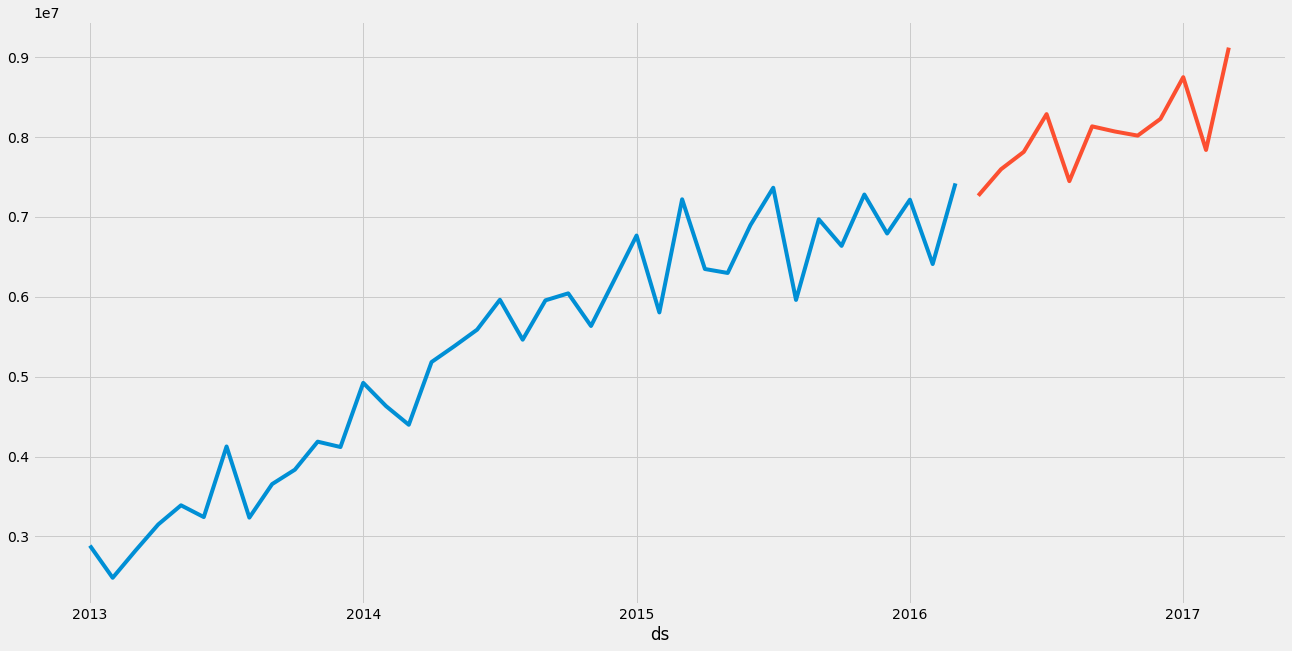

Current best ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:387.39002252955135


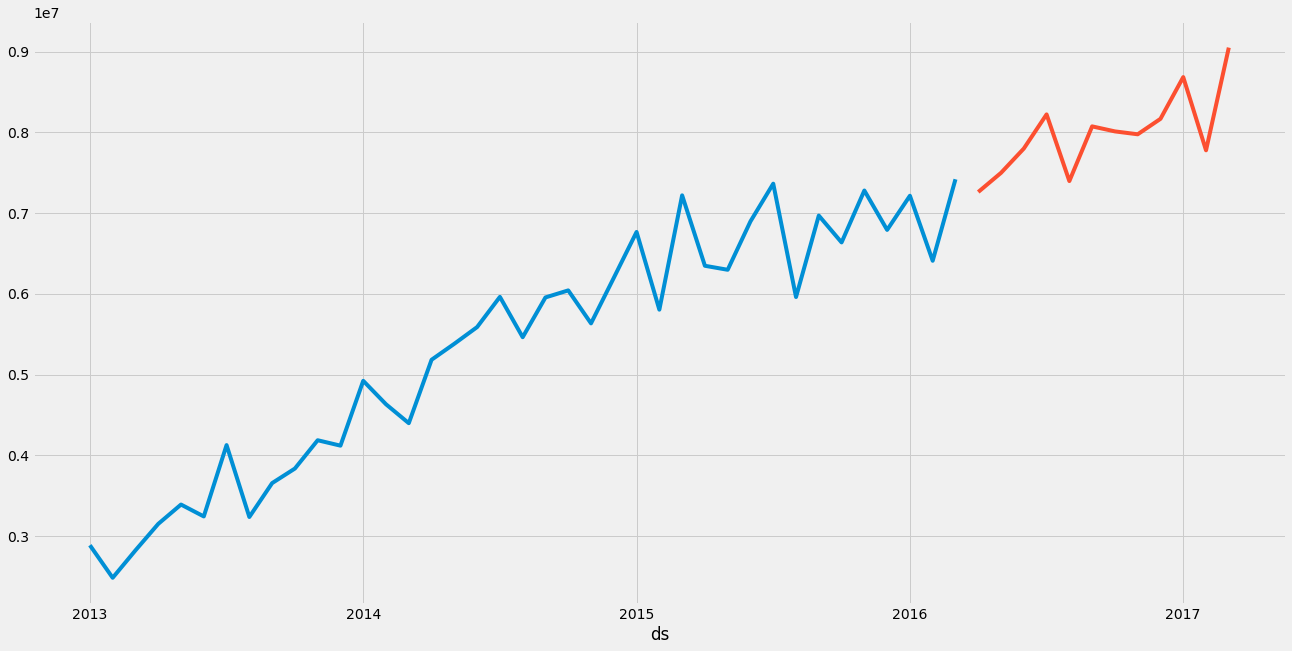

Product_ID :  2    Country :  Denmark
Product_ID :  2    Country :  Denmark


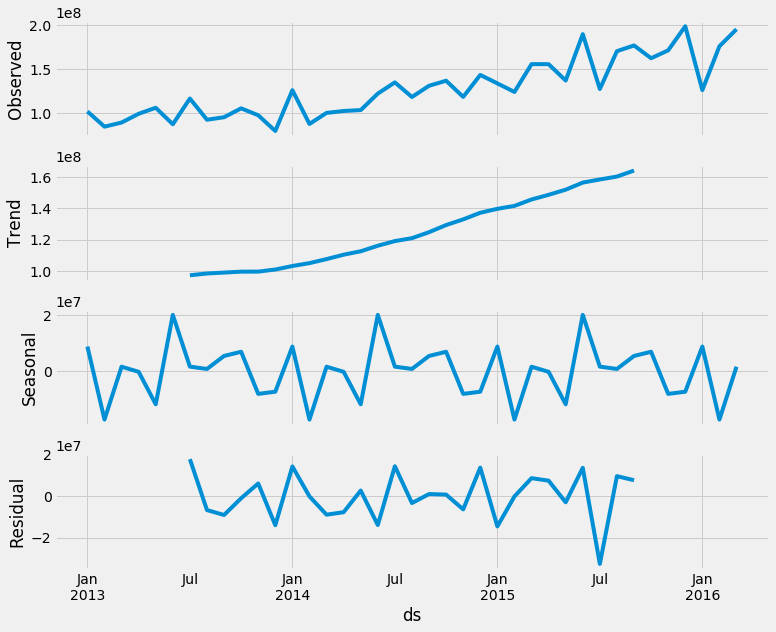

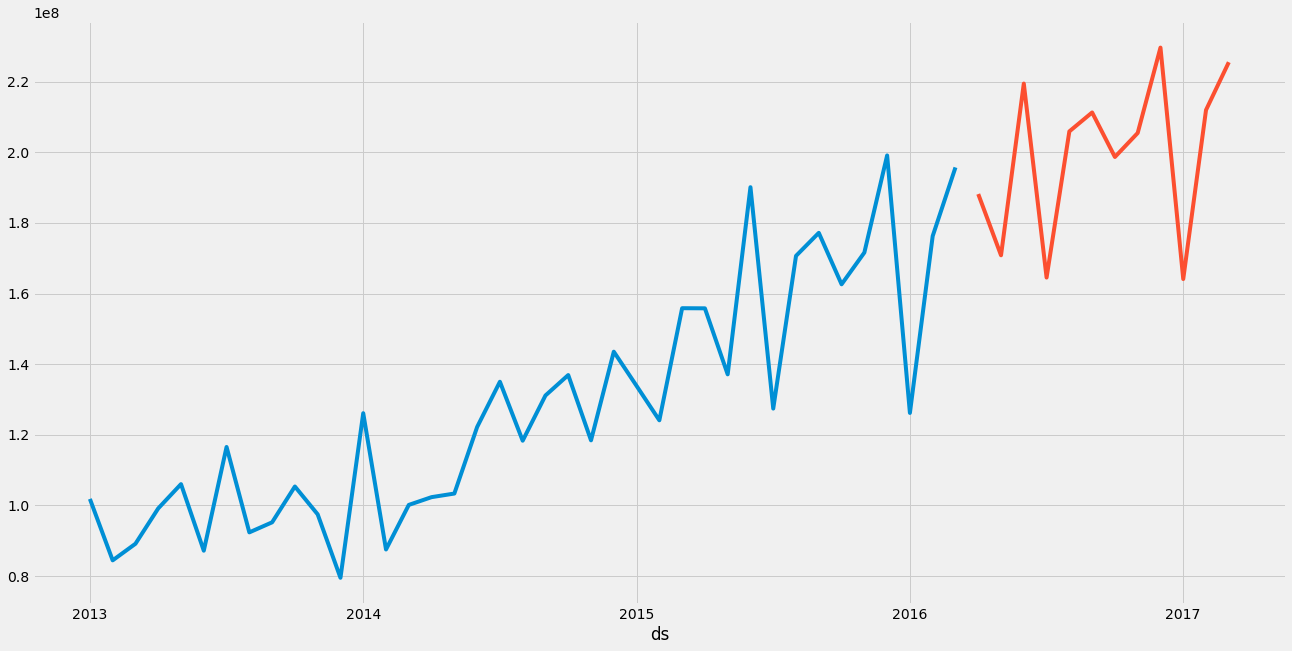

Product_ID :  2    Country :  Denmark
Current best ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1531.2941301327207


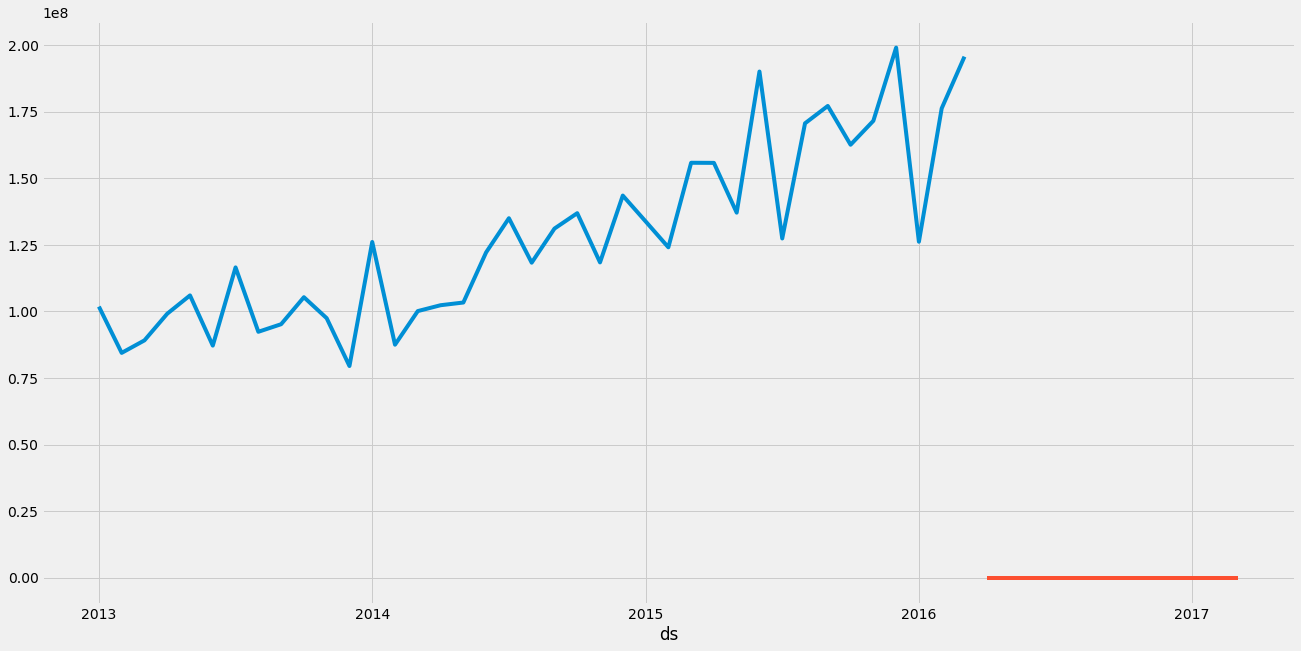

Current best ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:986.0418190946066


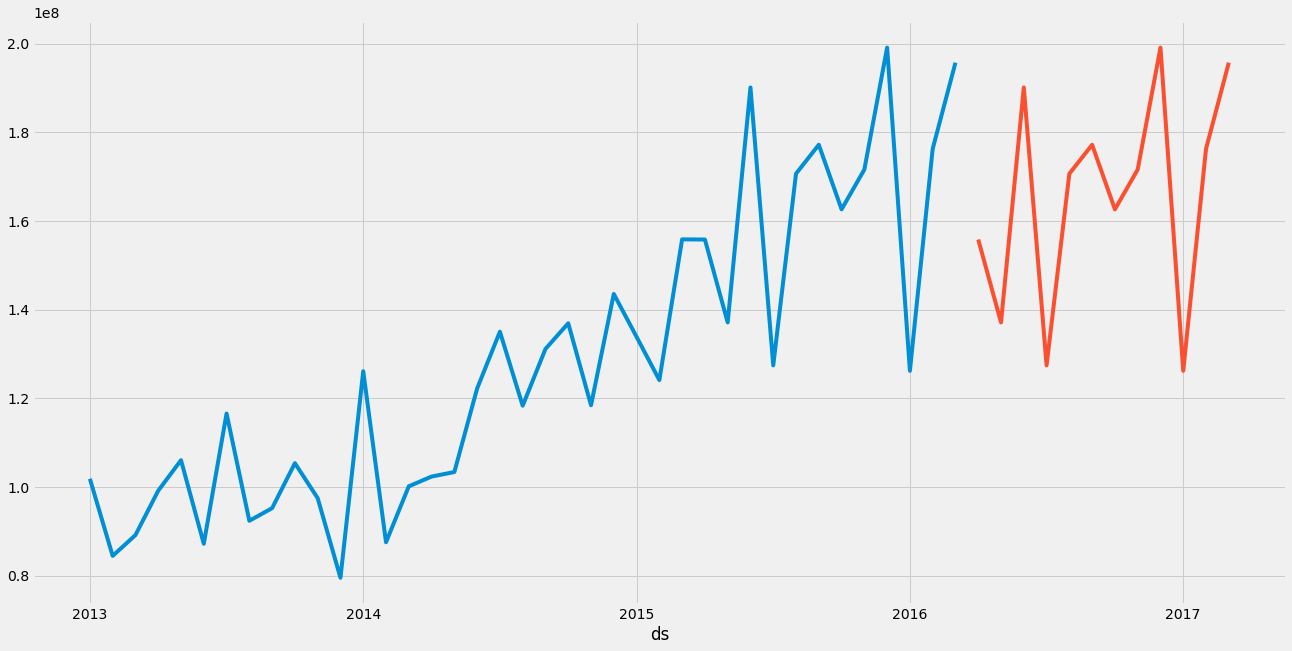

Current best ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:961.533634319209


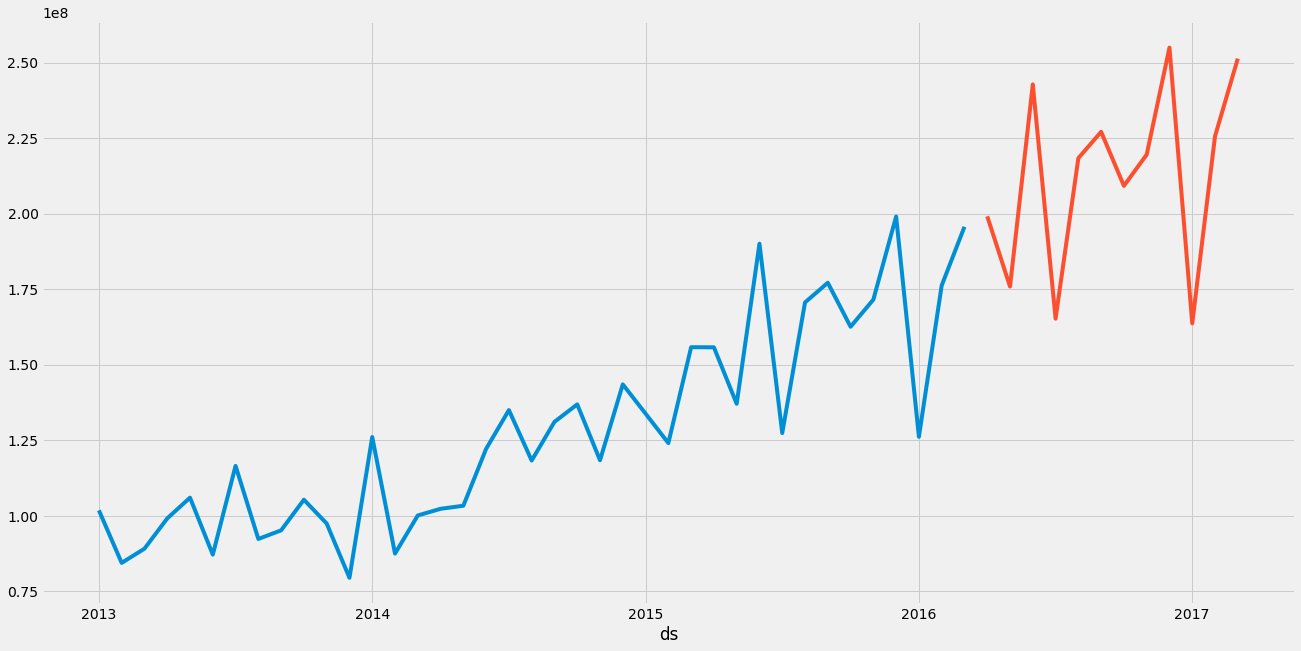

Current best ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:560.6960115205388


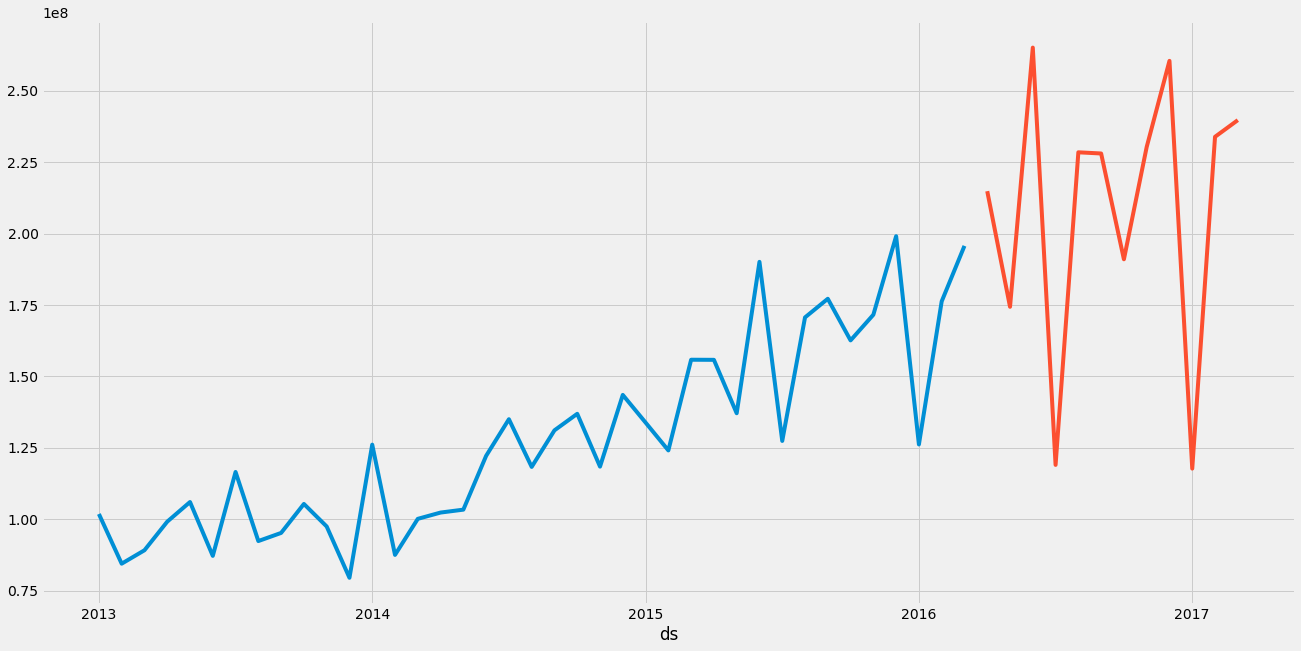

Current best ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:527.7888578764341


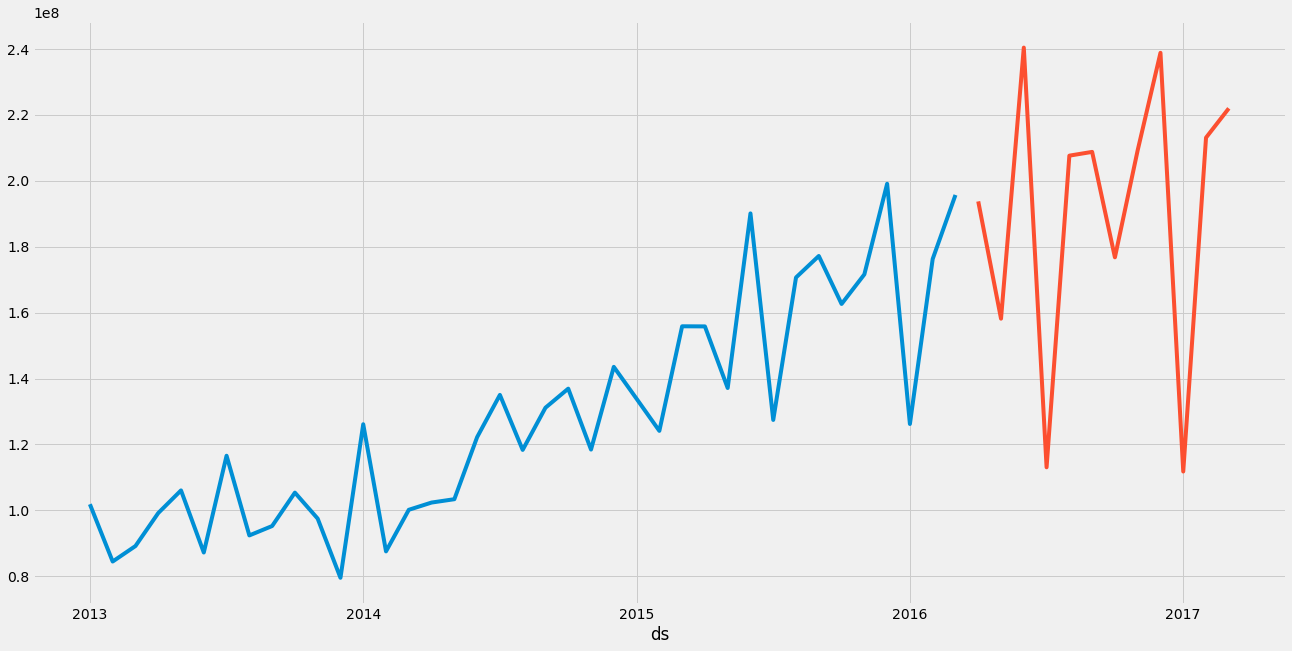

Current best ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:518.9506793250036


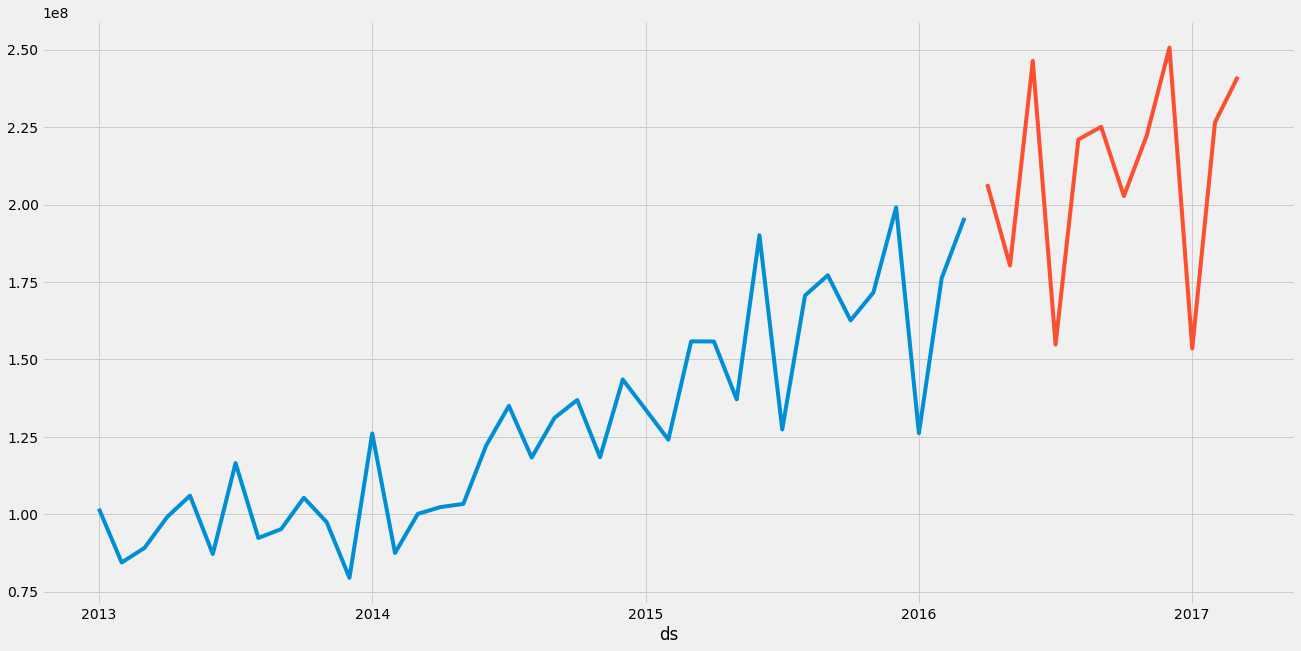

Current best ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:487.75986389759004


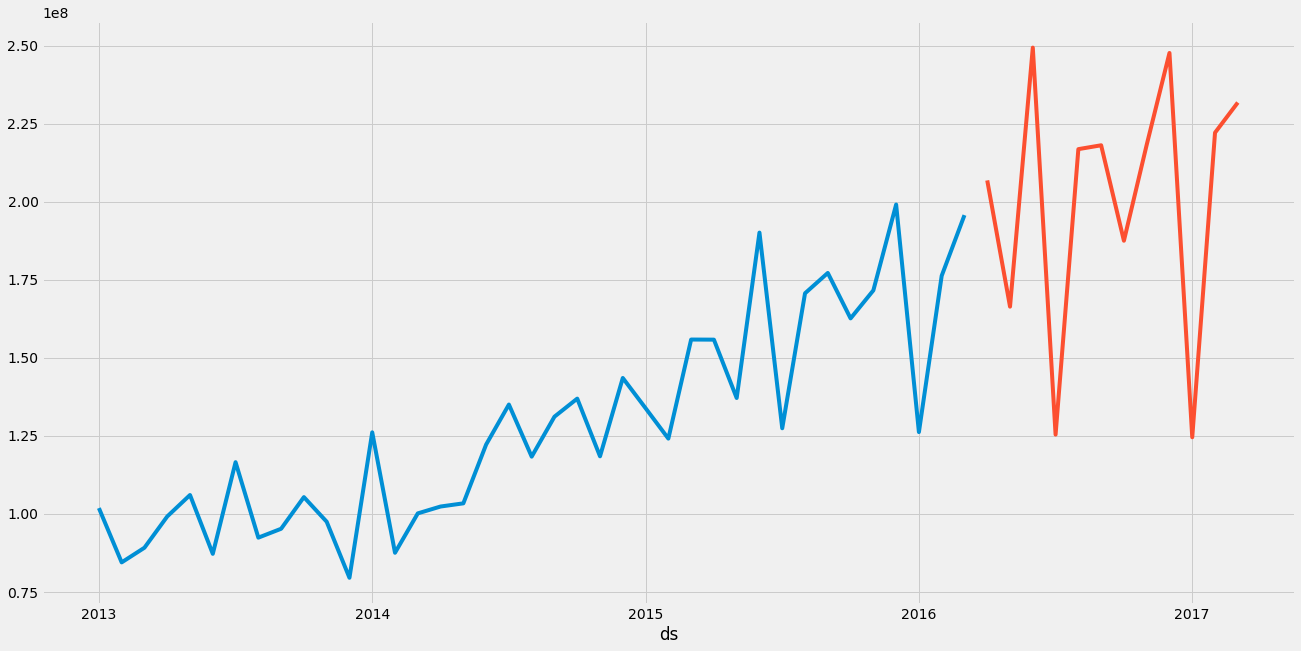

Current best ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:482.8192723416813


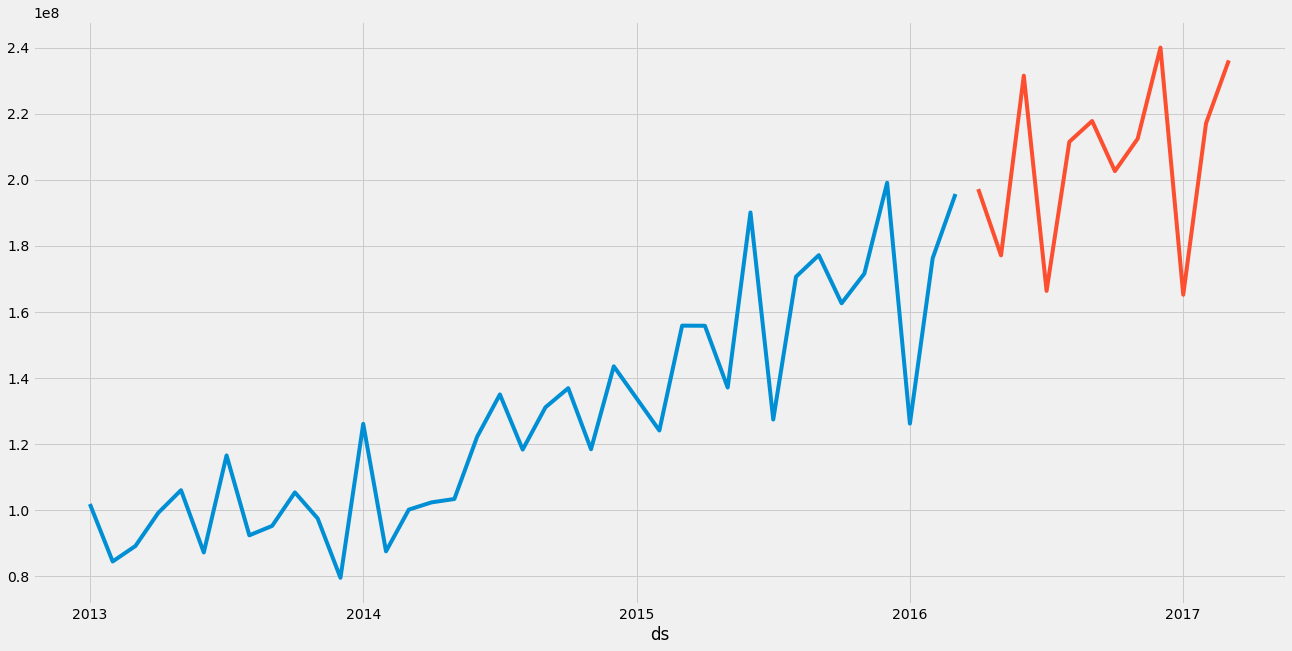

Product_ID :  2    Country :  Belgium
Product_ID :  2    Country :  Belgium


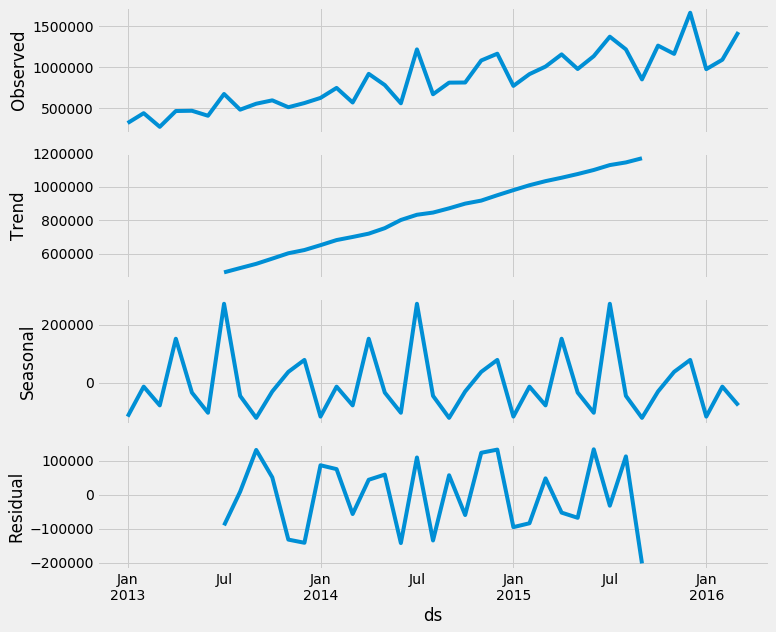

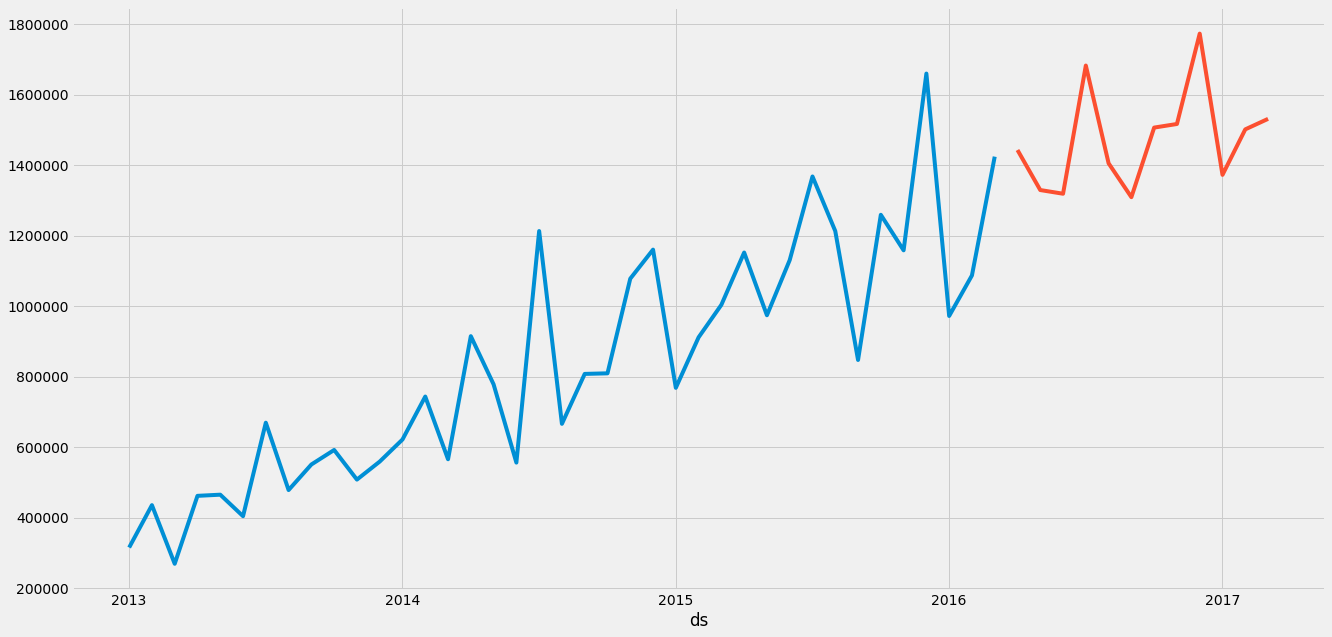

Product_ID :  2    Country :  Belgium
Current best ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1152.5581314897497


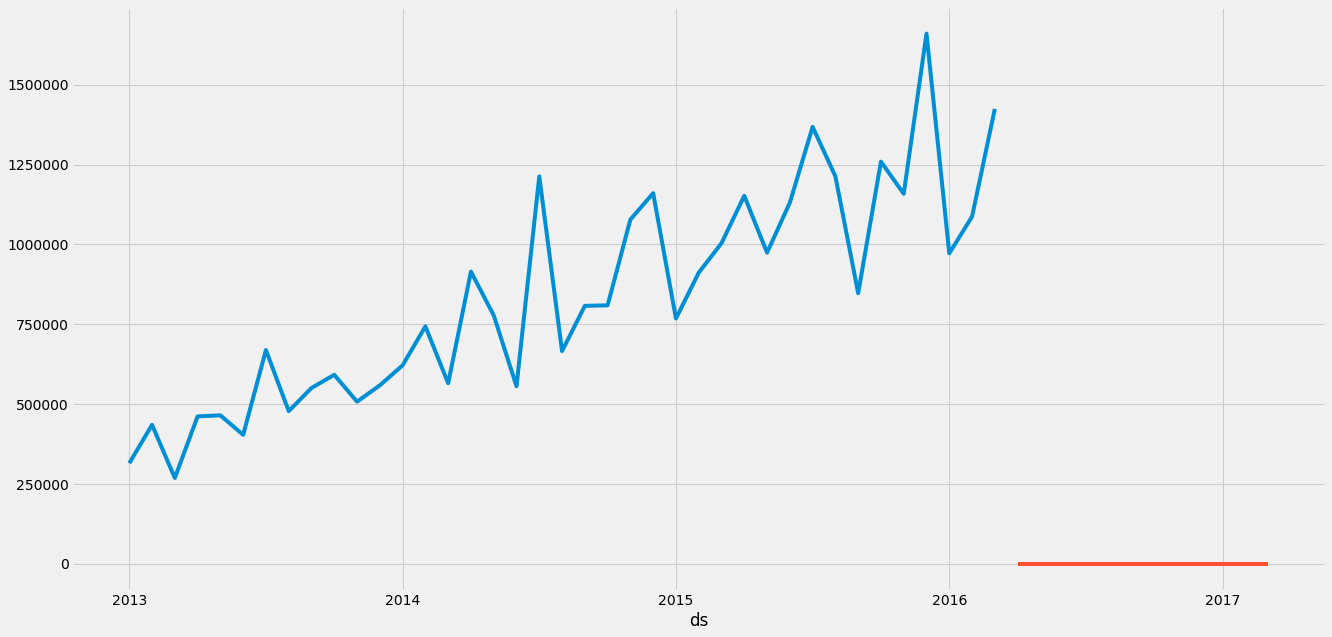

Current best ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:742.966710572867


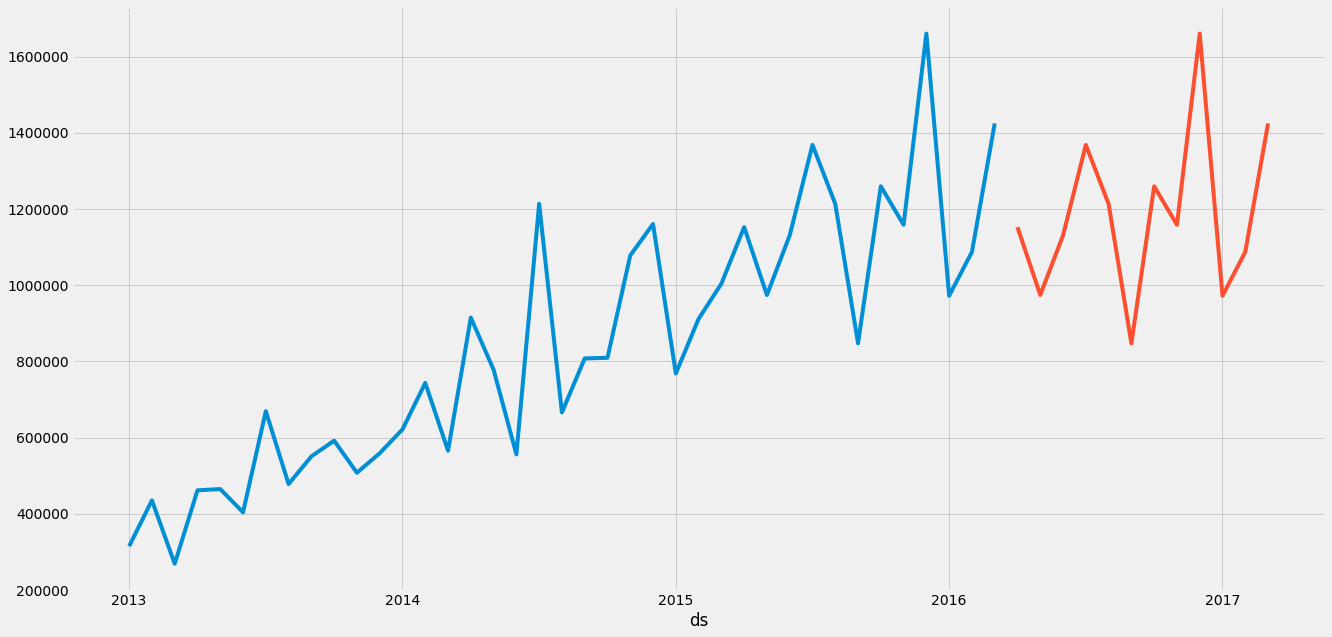

Current best ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:742.8725133653426


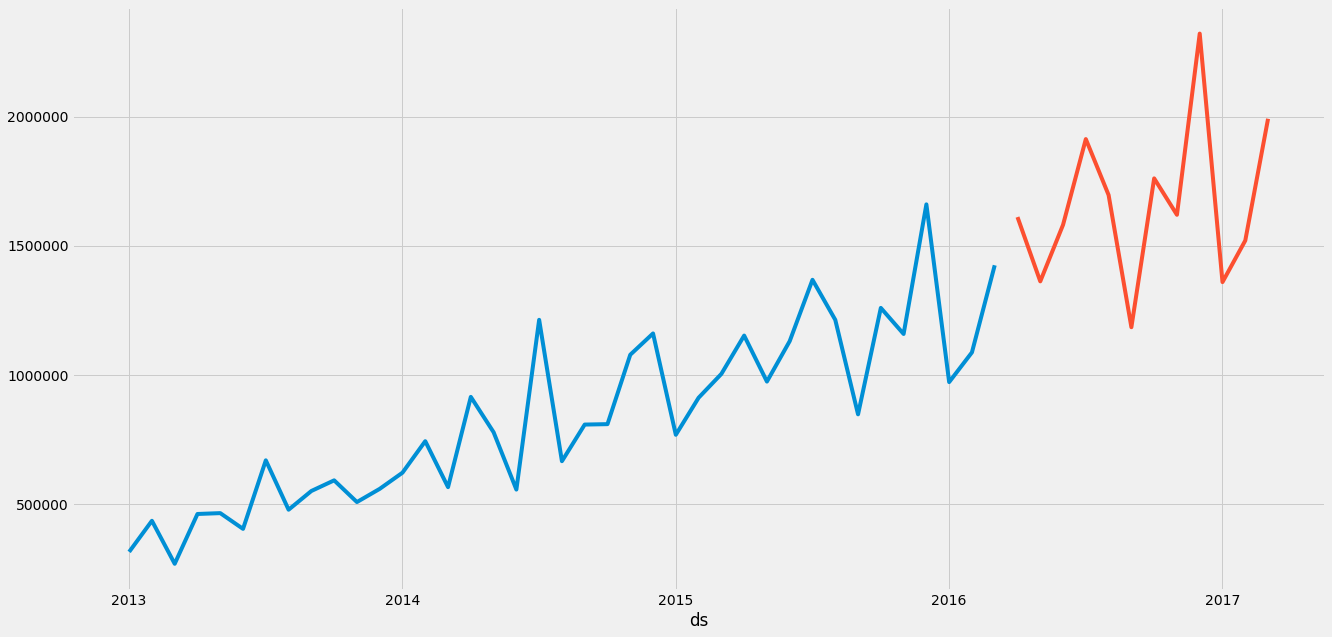

Current best ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:736.2262103159212


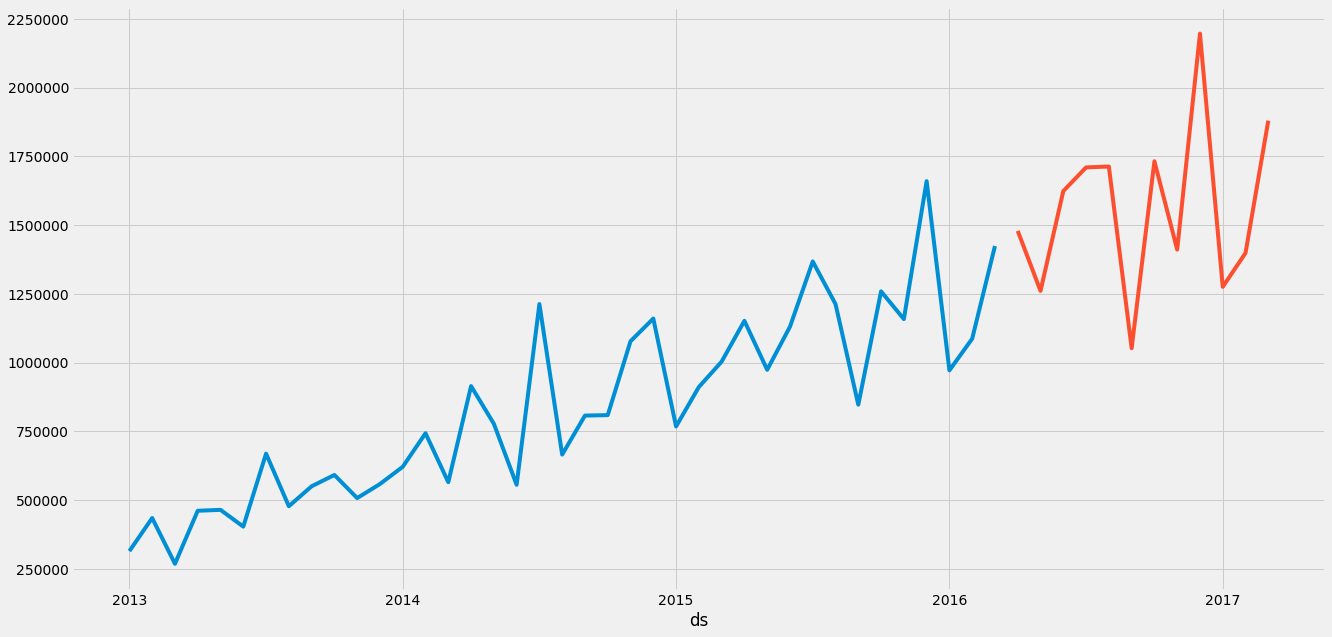

Current best ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:416.1540030758628


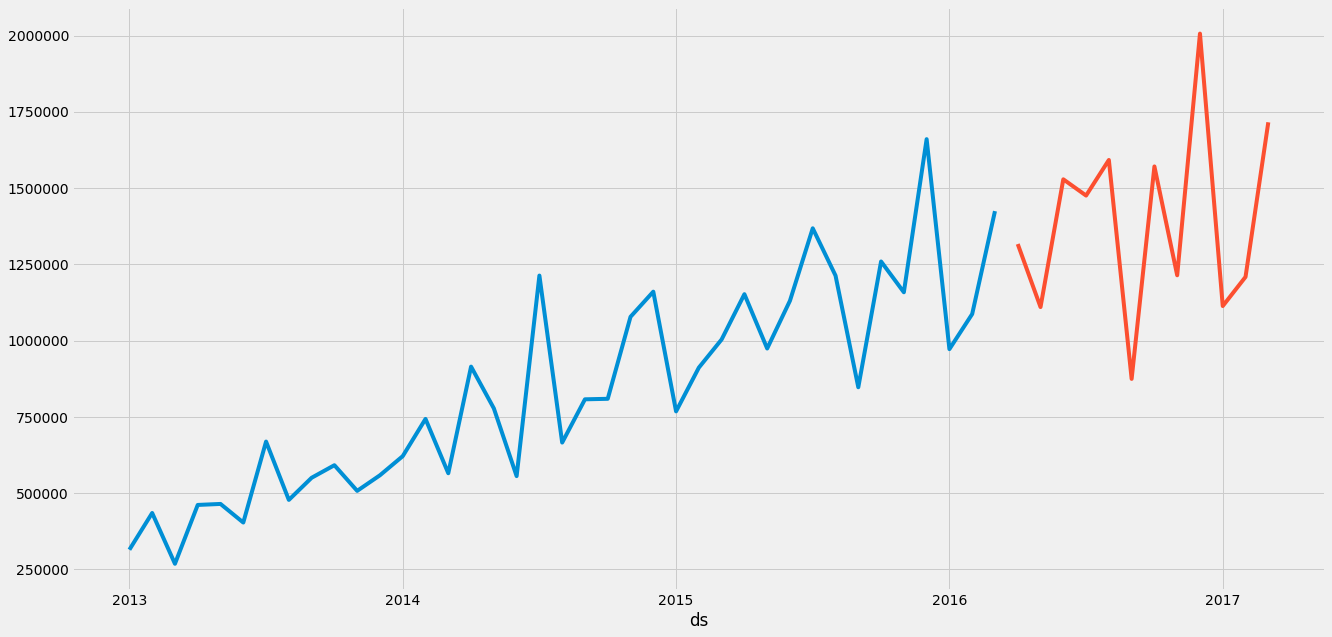

Current best ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:397.3333987668648


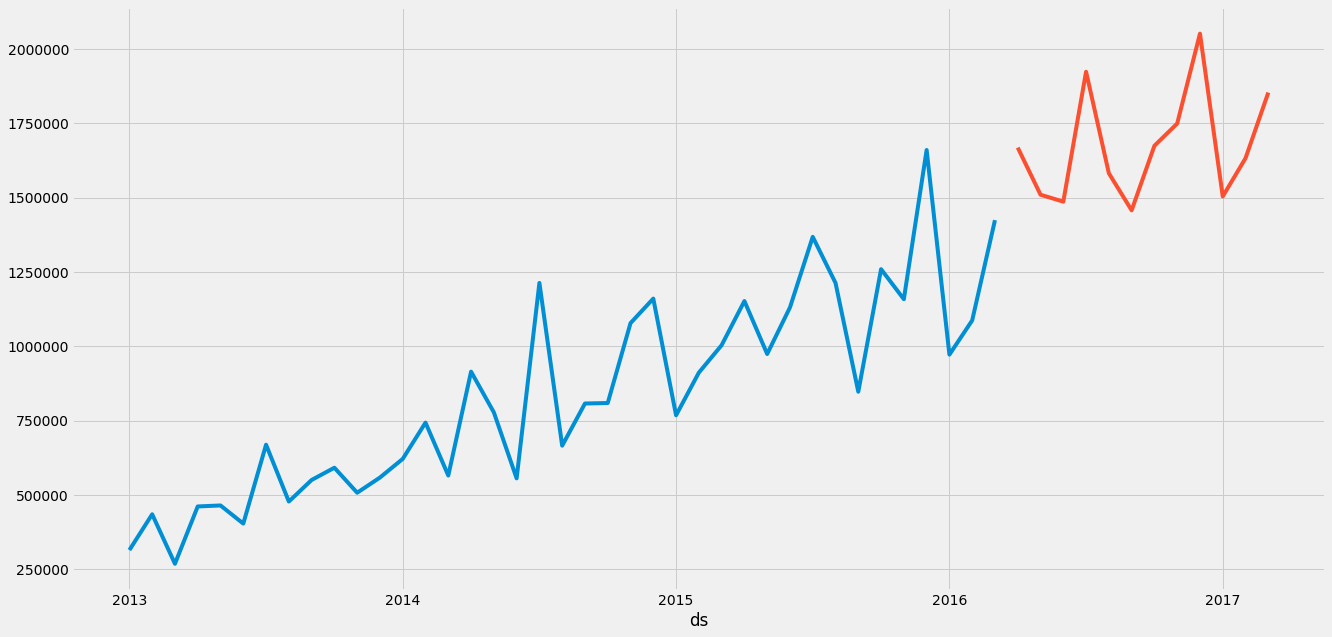

Current best ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:384.42371836969687


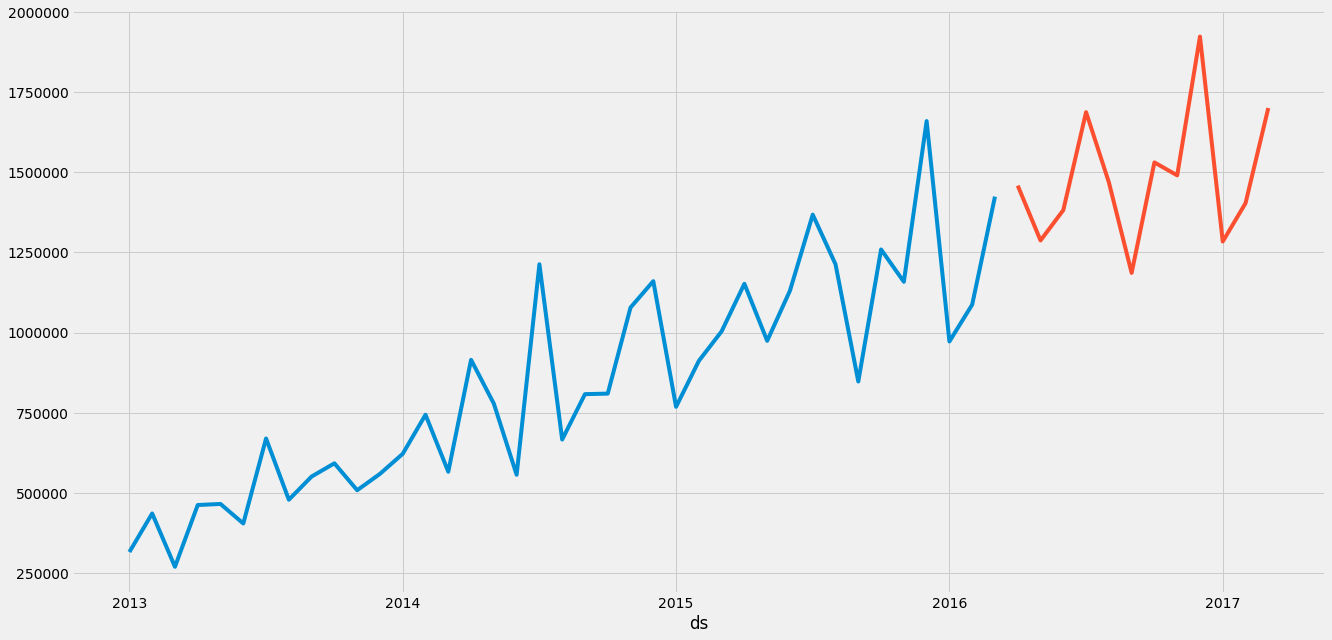

Current best ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:358.1630350210106


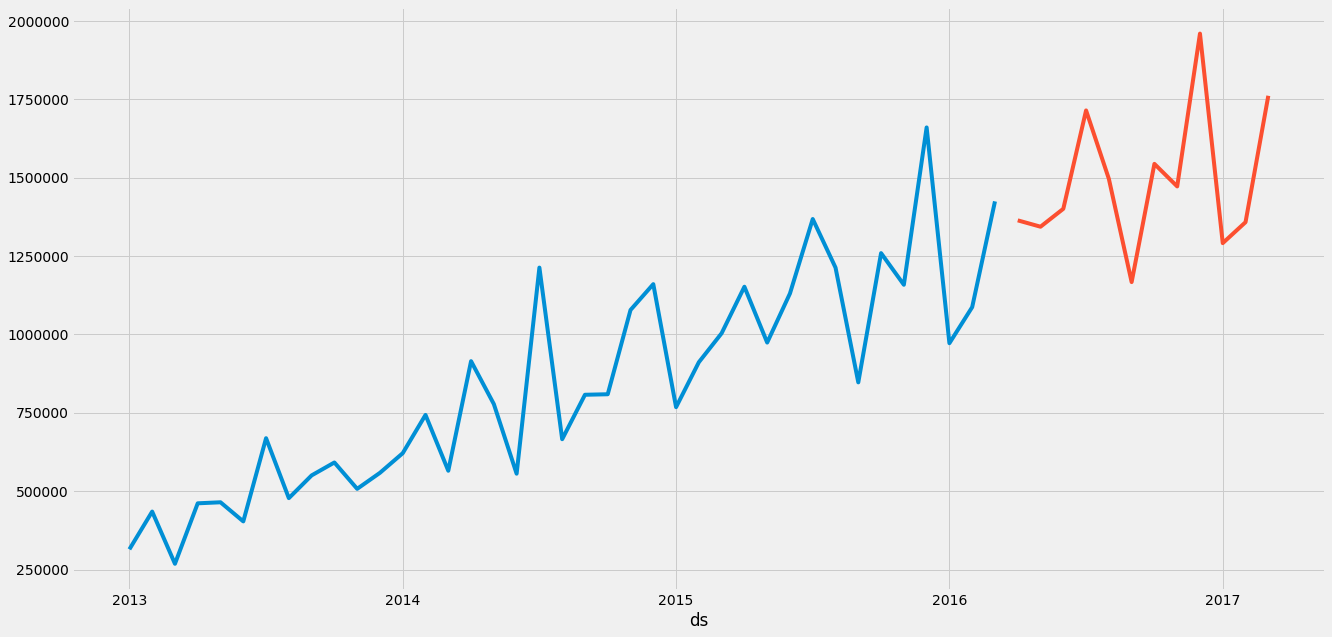

Current best ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:351.82073926191066


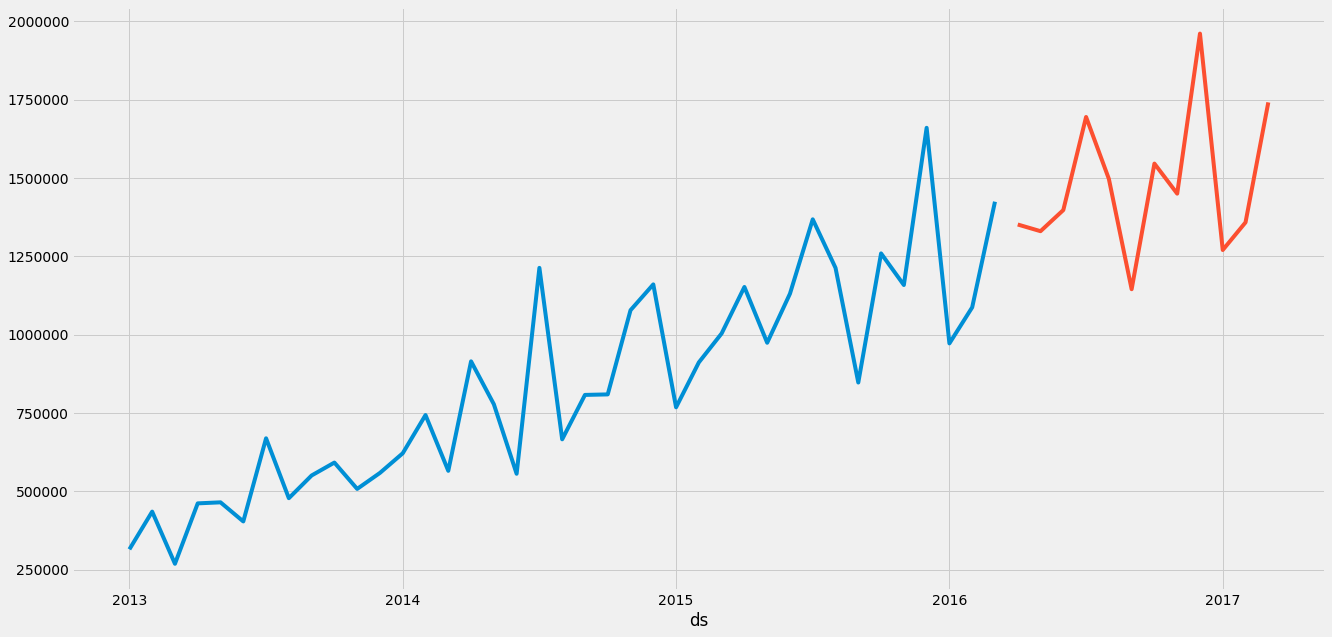

Product_ID :  3    Country :  Argentina
Product_ID :  3    Country :  Argentina


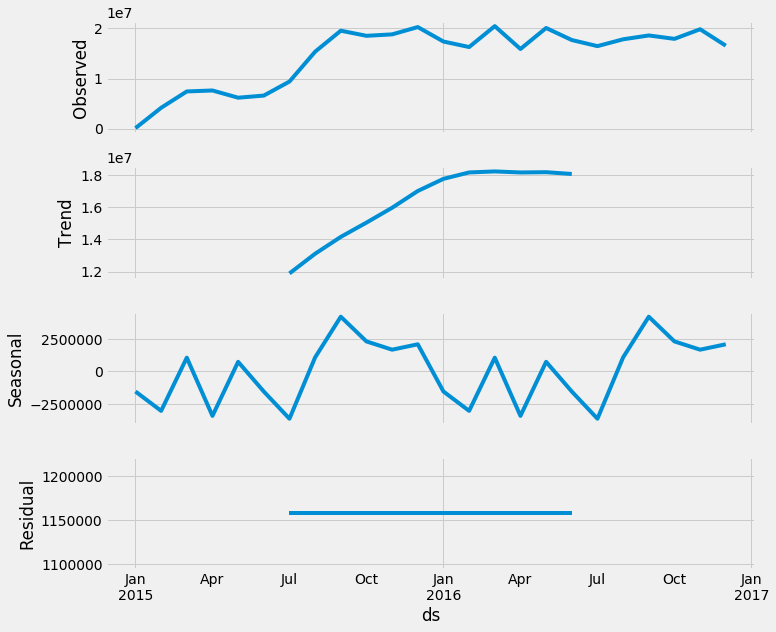

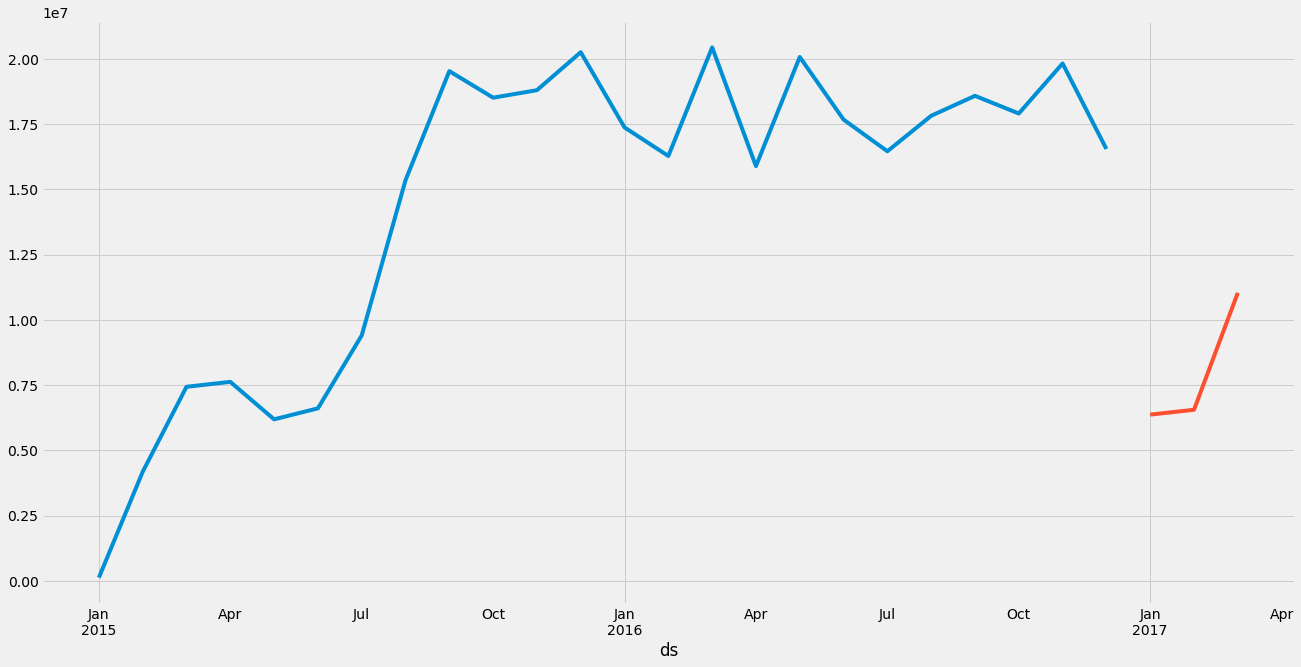

Product_ID :  3    Country :  Argentina
Current best ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:830.3920764918624


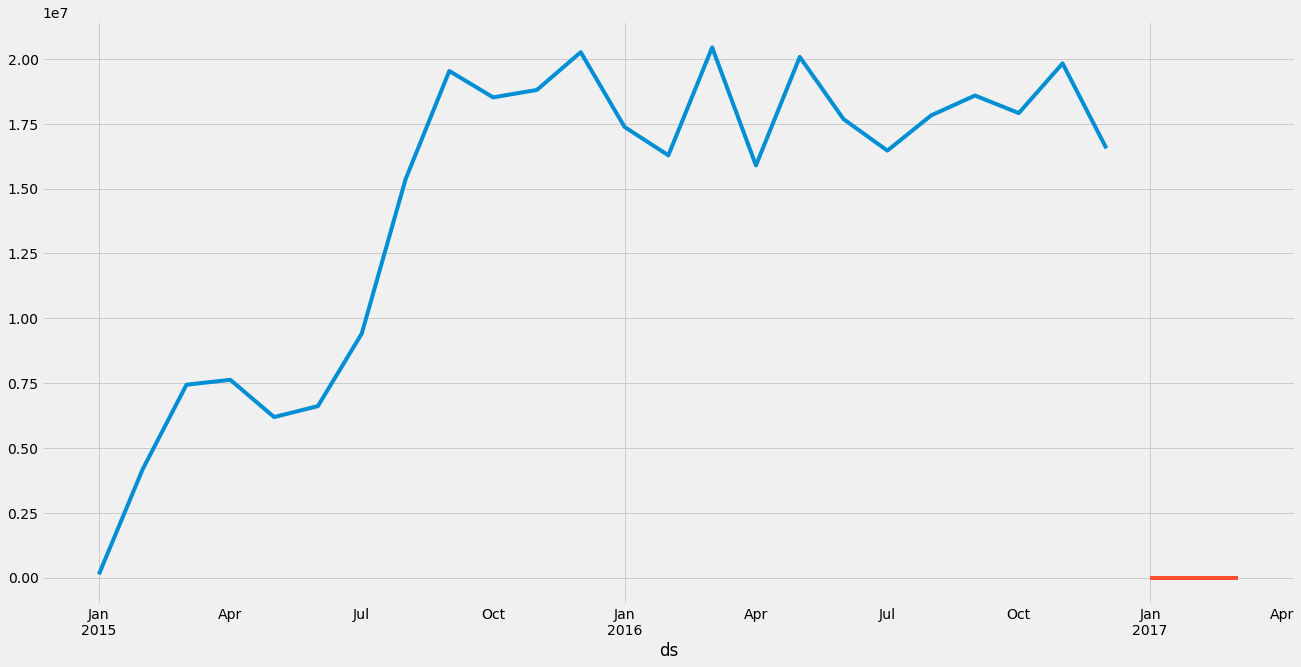

Current best ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:385.23177546775213


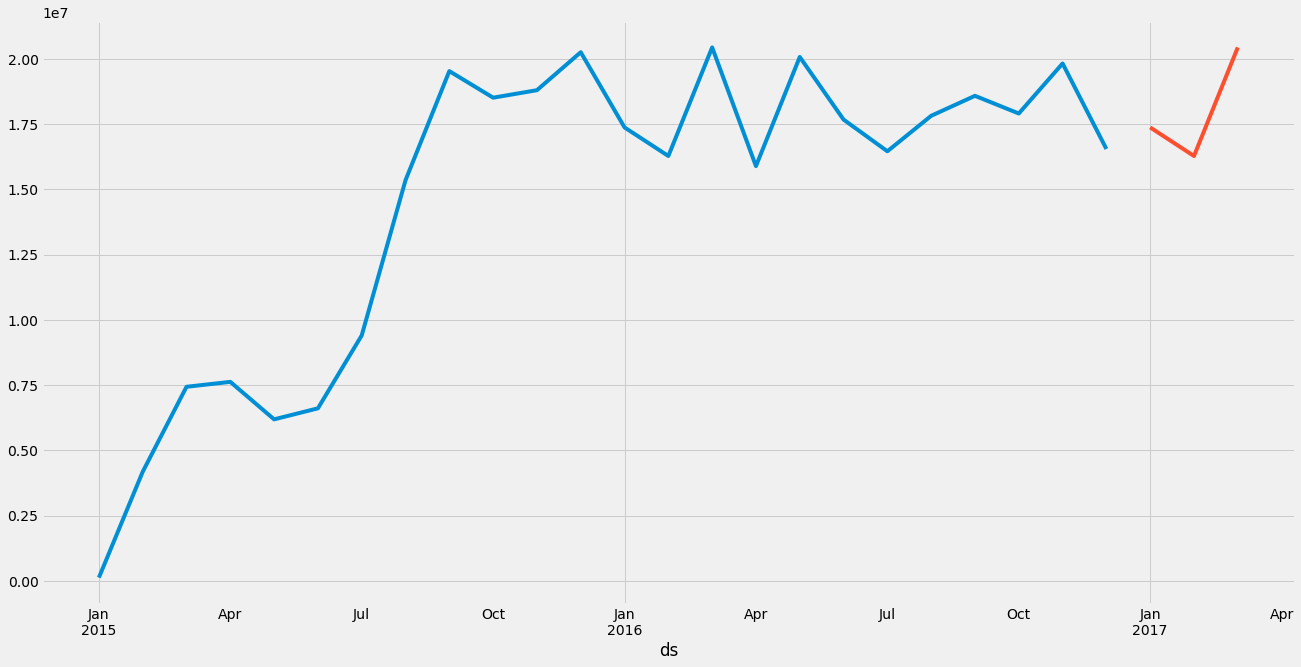

Current best ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:343.4039761224851


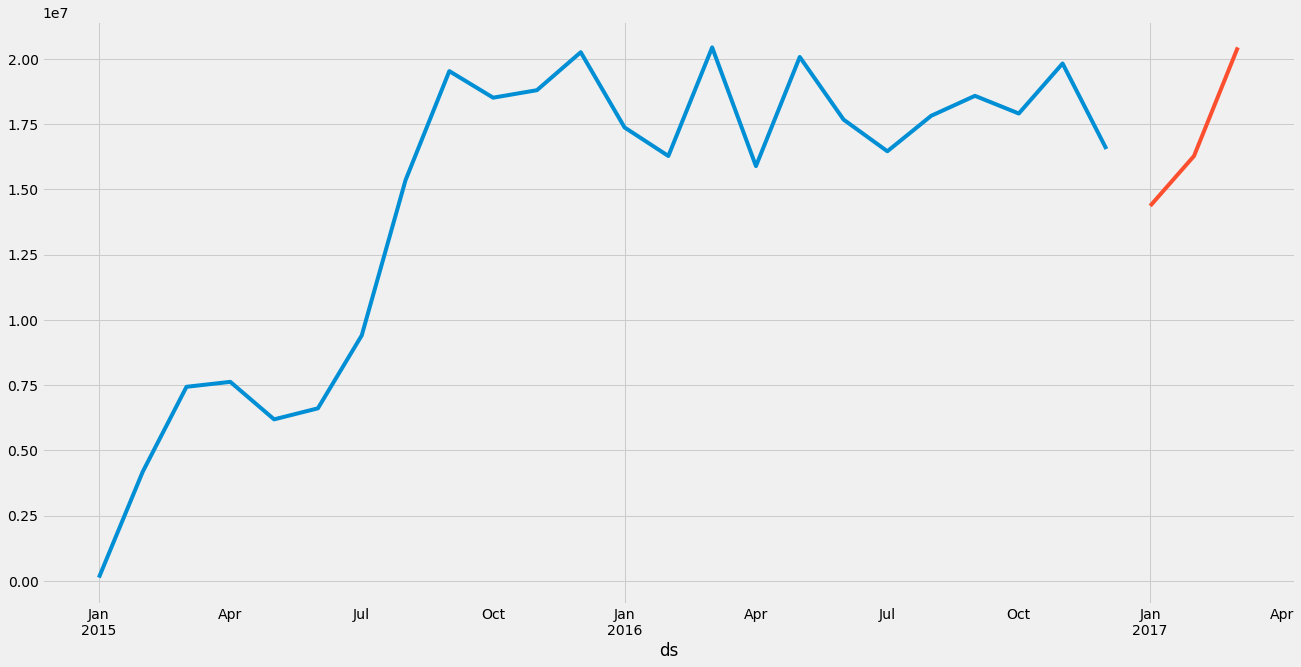

Current best ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:335.96194129820157


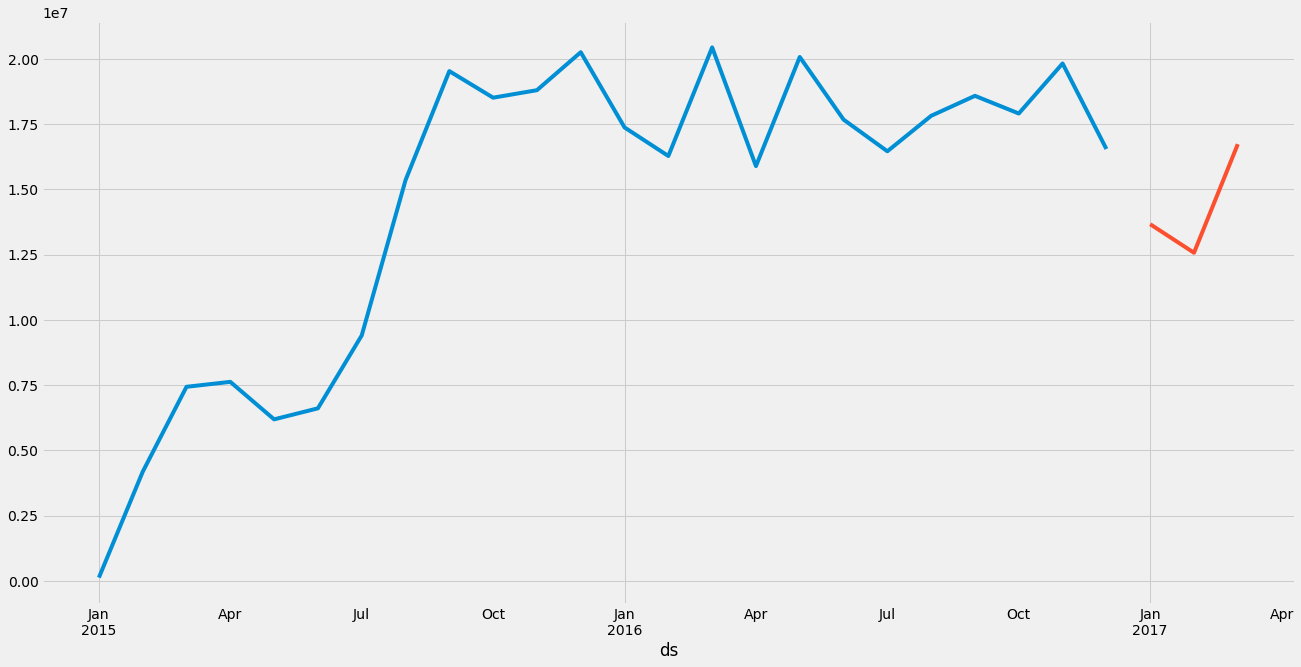

Current best ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:302.9456975535307


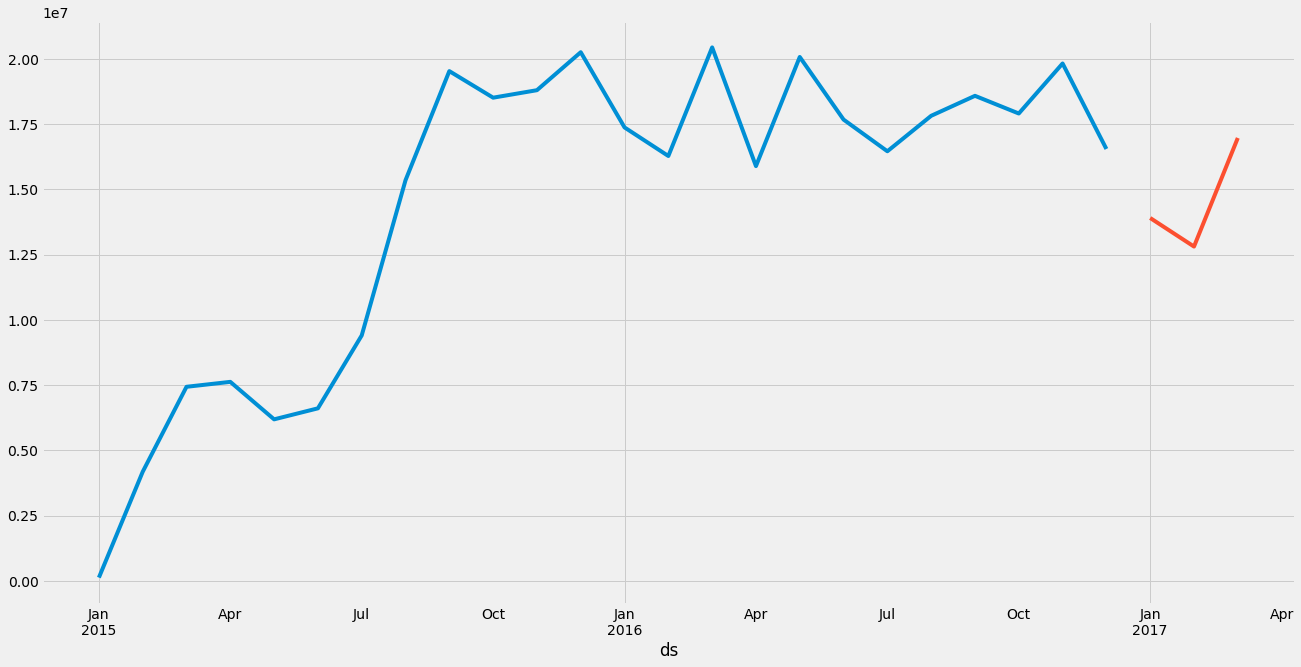

Product_ID :  3    Country :  Columbia
Product_ID :  3    Country :  Columbia


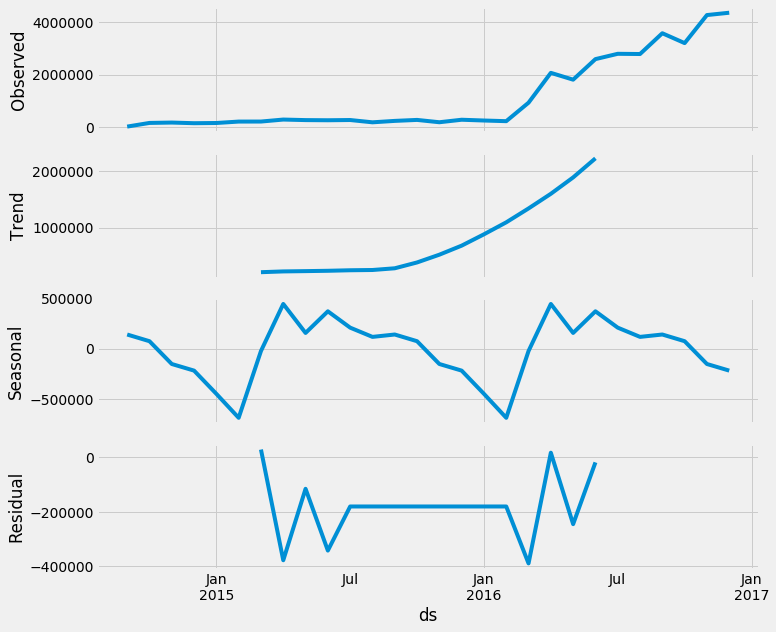

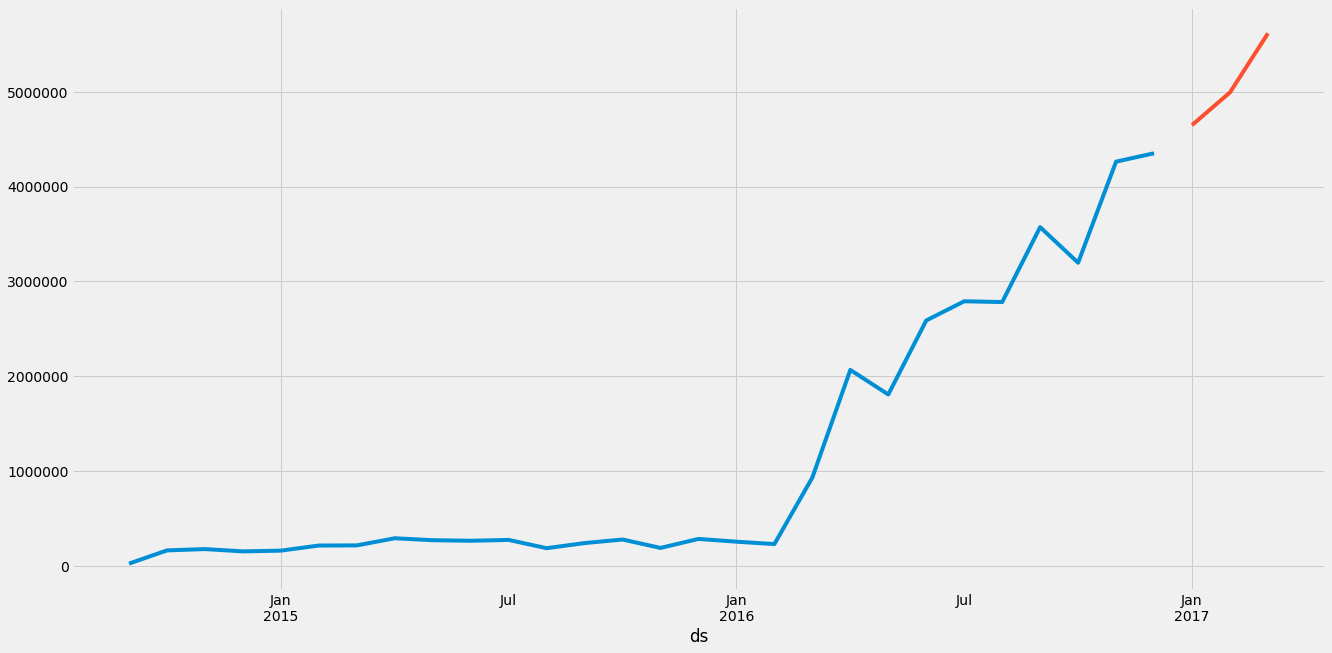

Product_ID :  3    Country :  Columbia
Current best ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:857.6633297561929


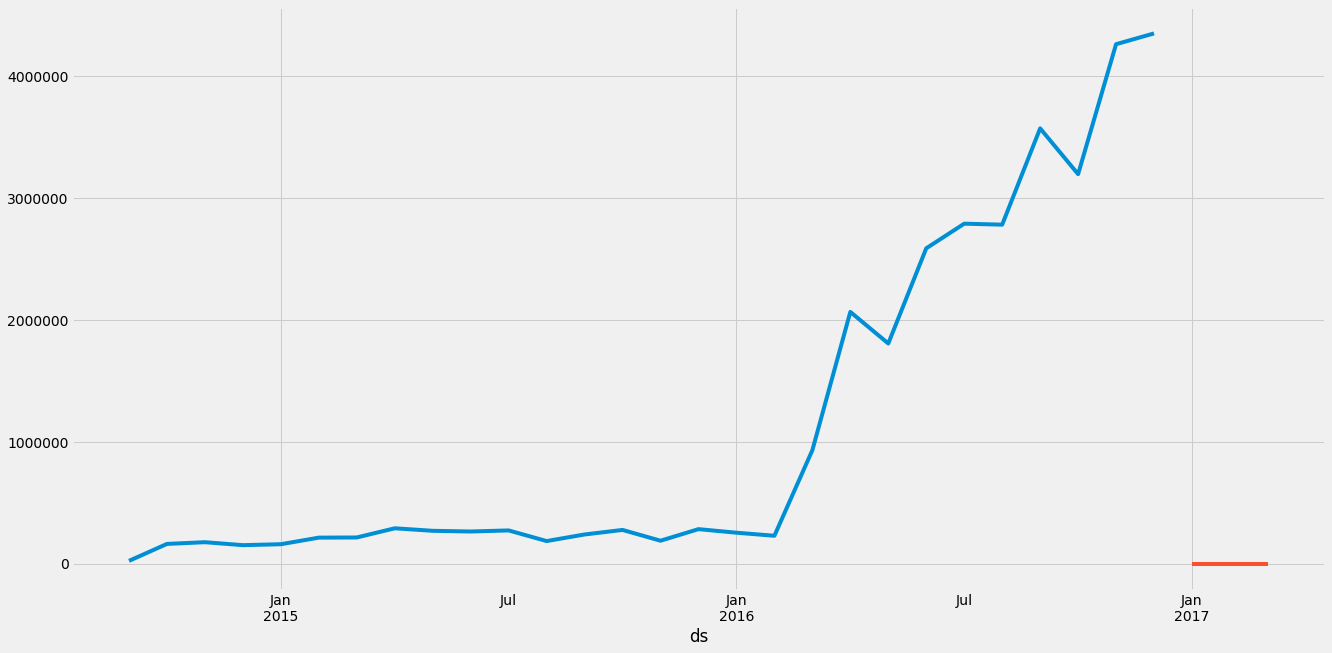

Current best ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:487.2703030019432


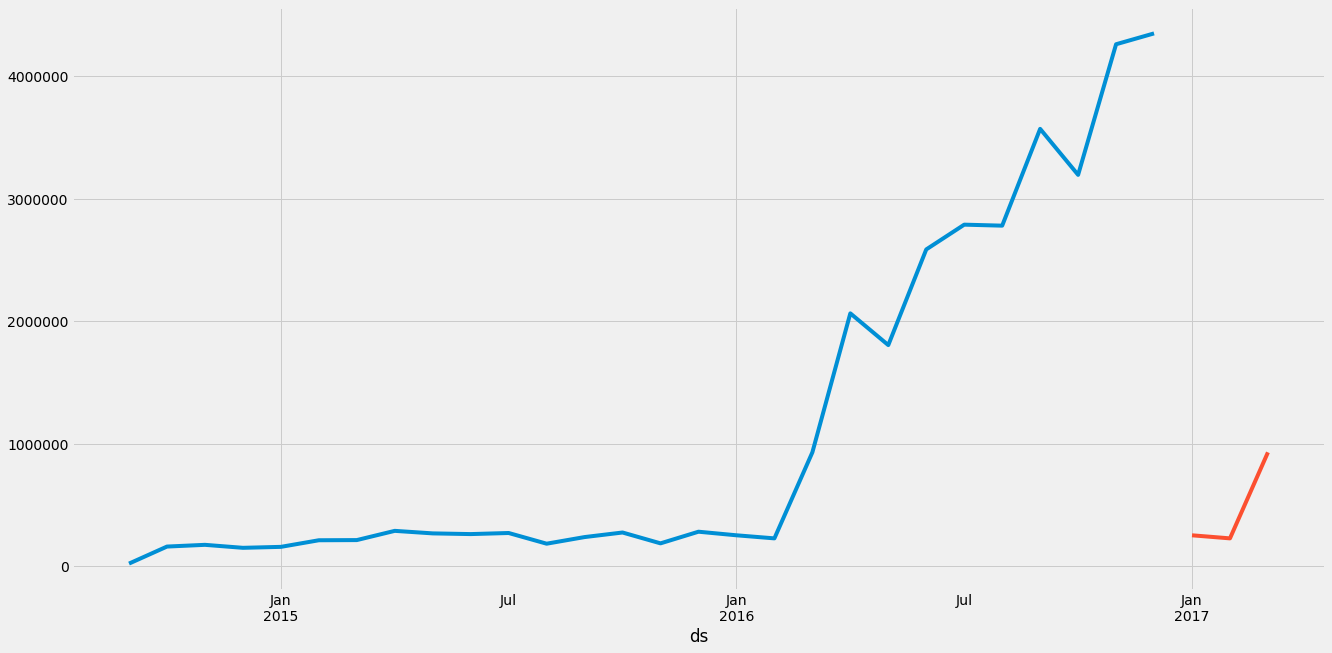

Current best ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:131.90154484622053


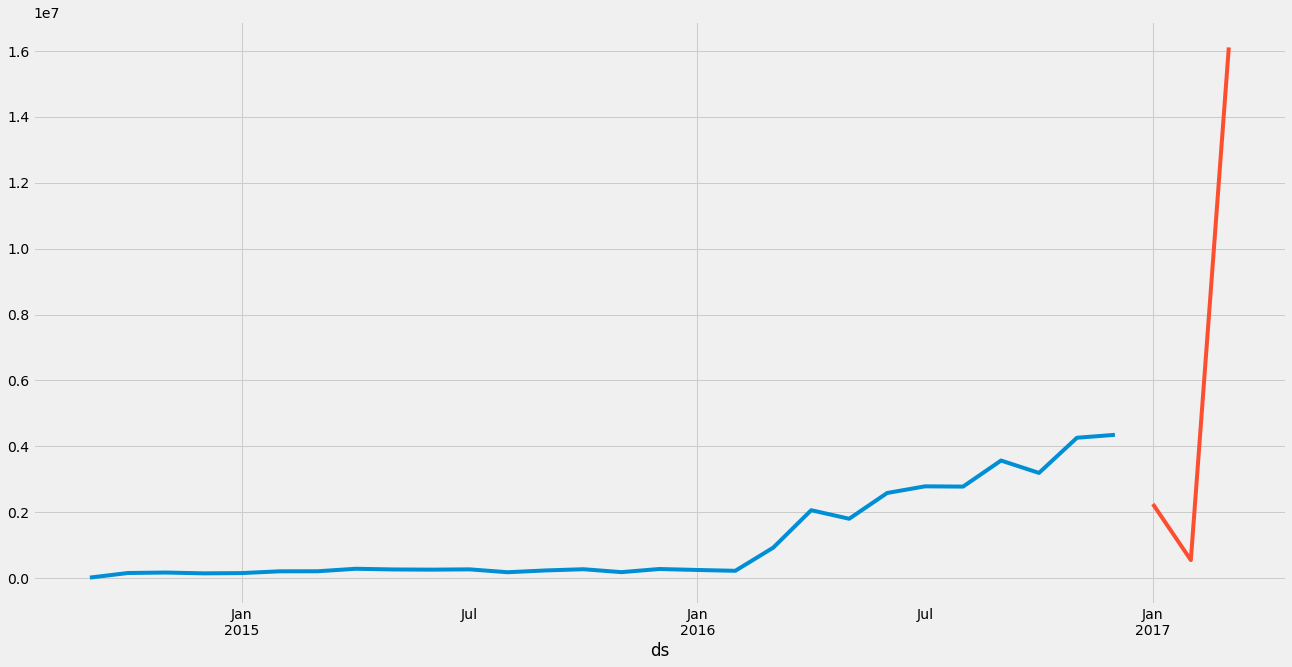

Current best ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:92.97659223191316


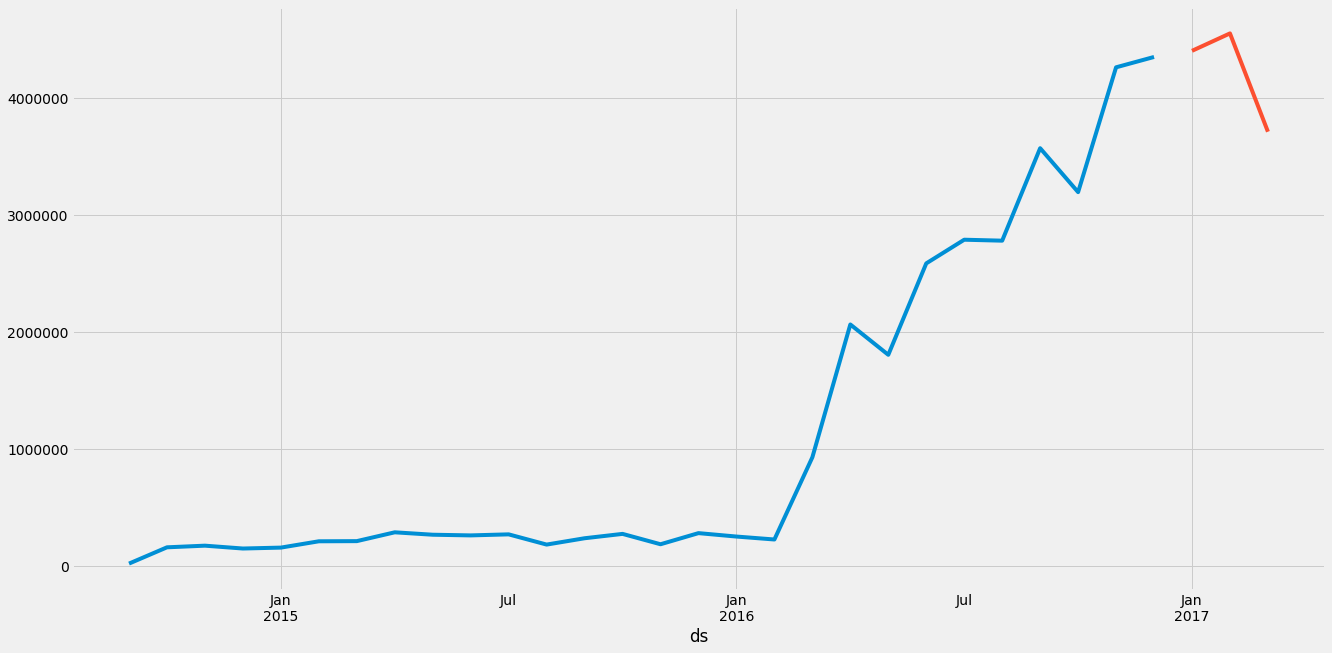

Current best ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:64.90596022349006


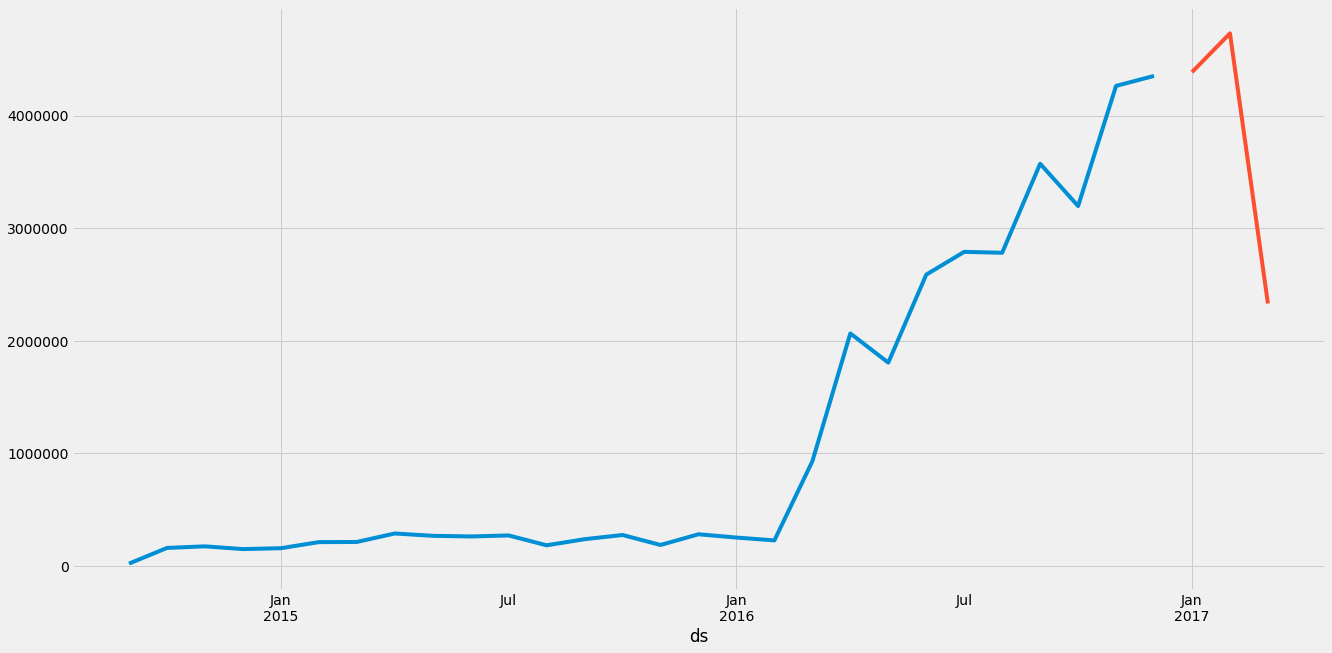

Current best ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:64.679689570684


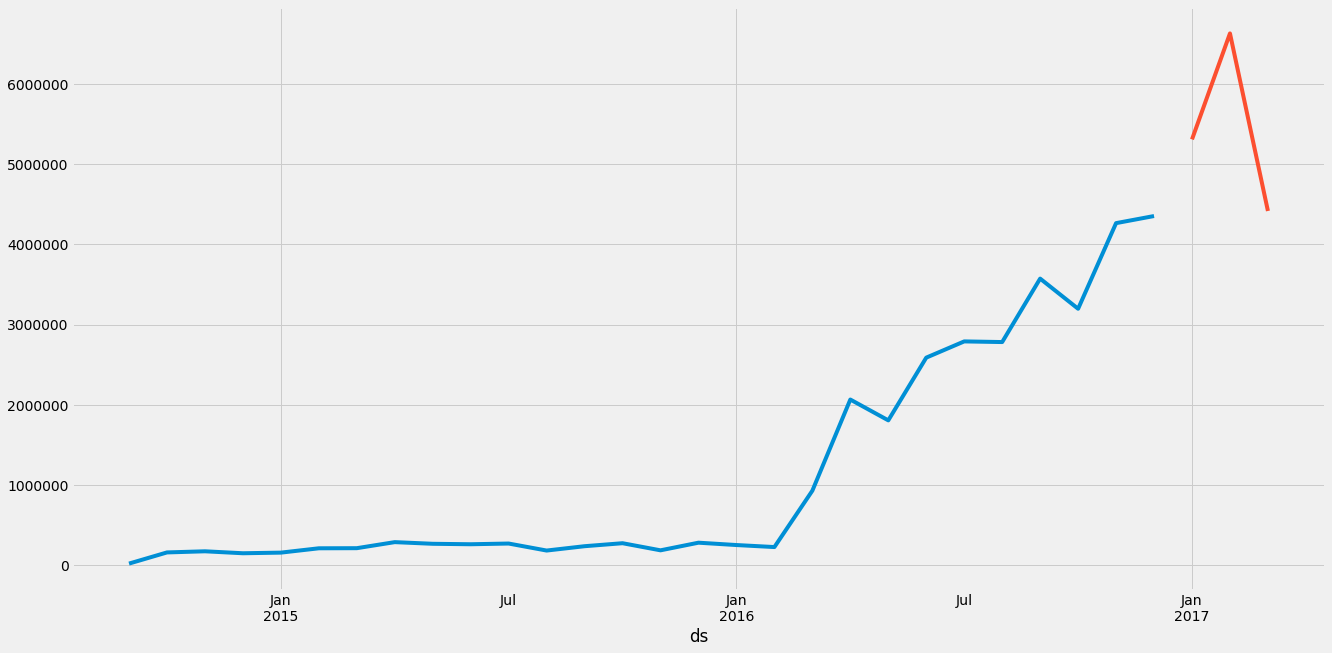

Product_ID :  4    Country :  England
Product_ID :  4    Country :  England


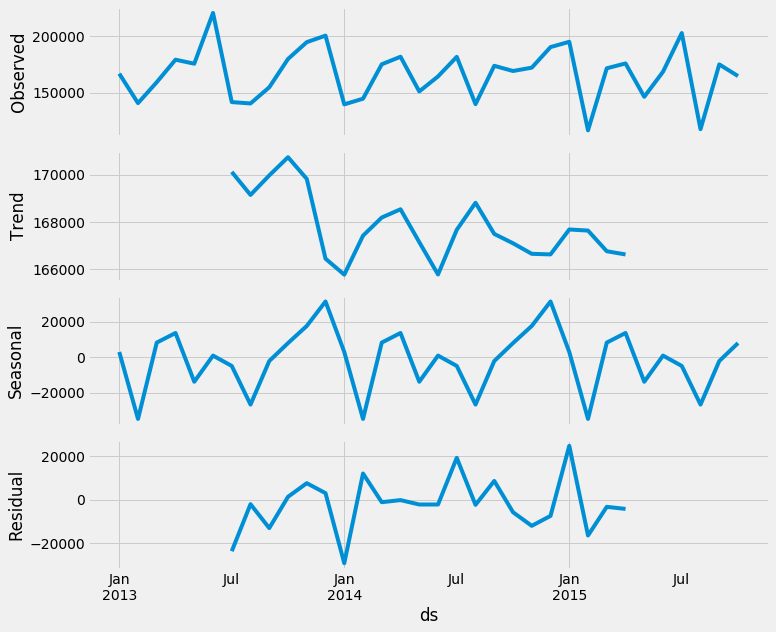

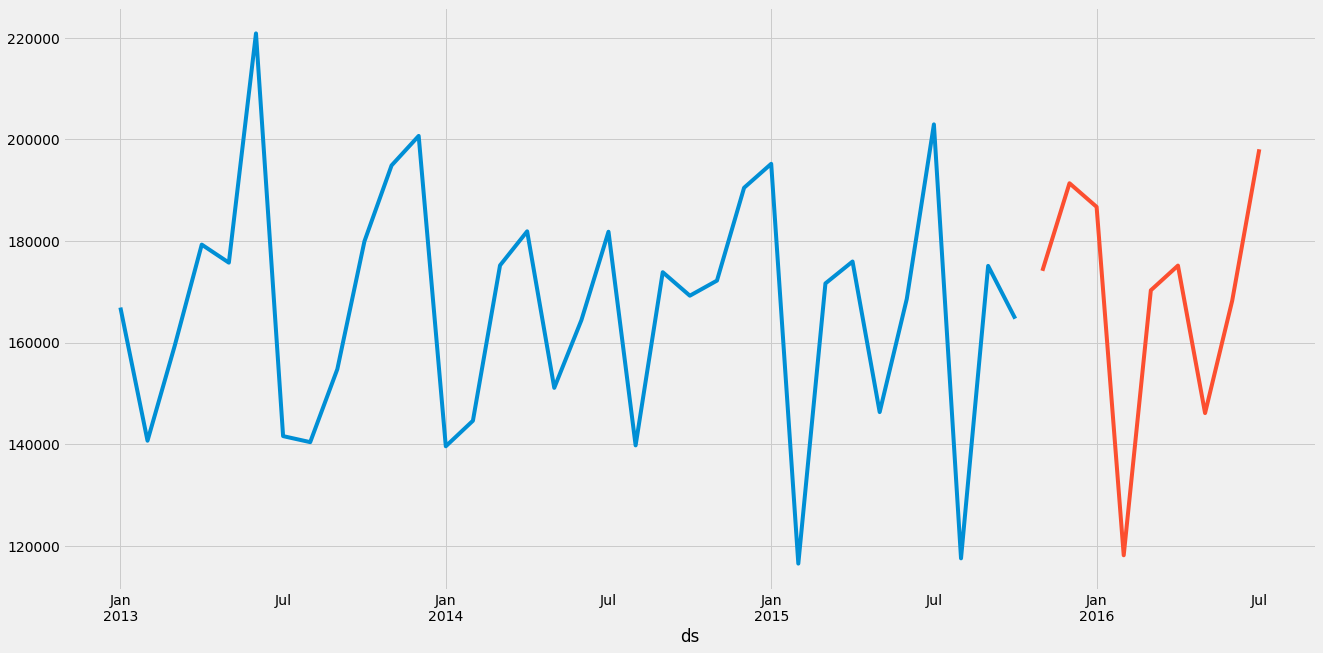

Product_ID :  4    Country :  England
Current best ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:889.9611656815345


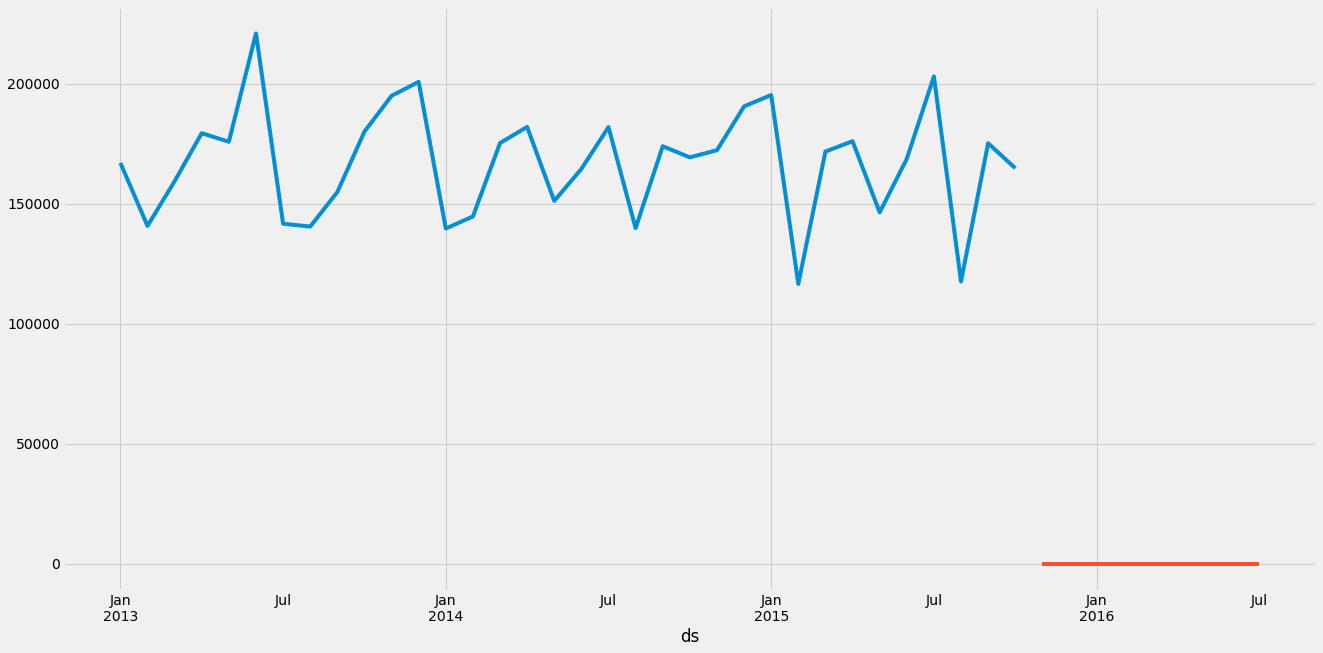

Current best ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:484.74357344615214


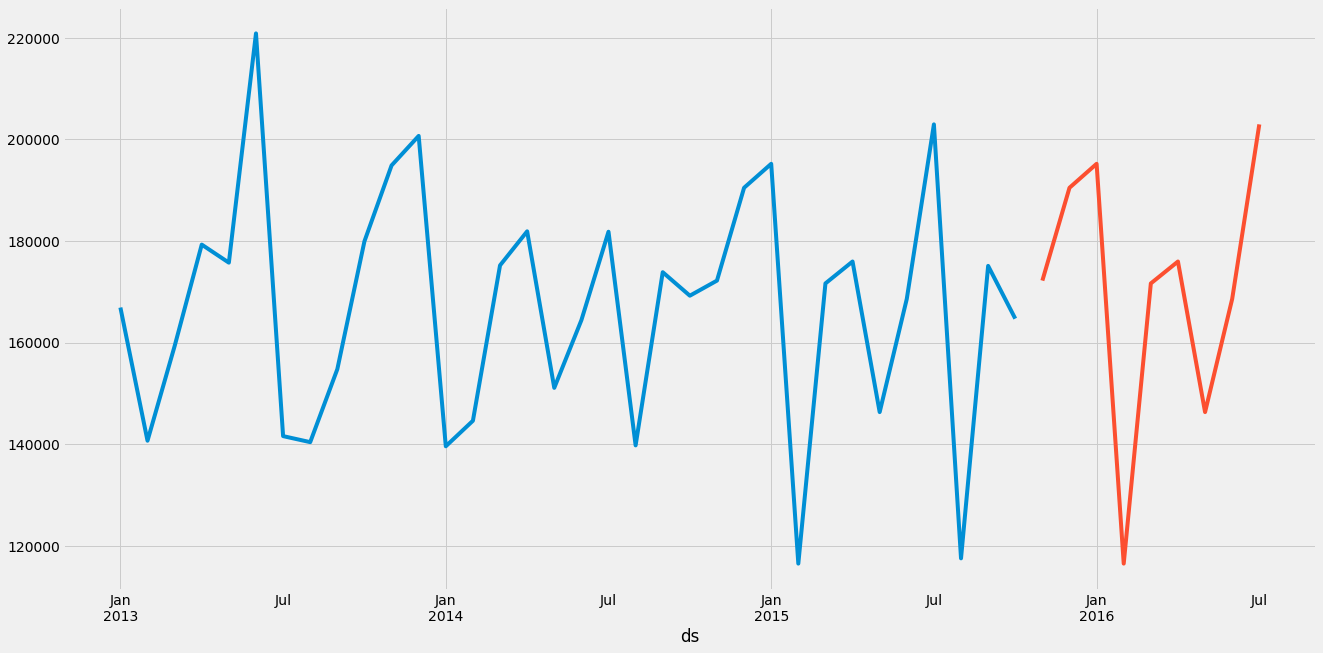

Current best ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:232.3169721424305


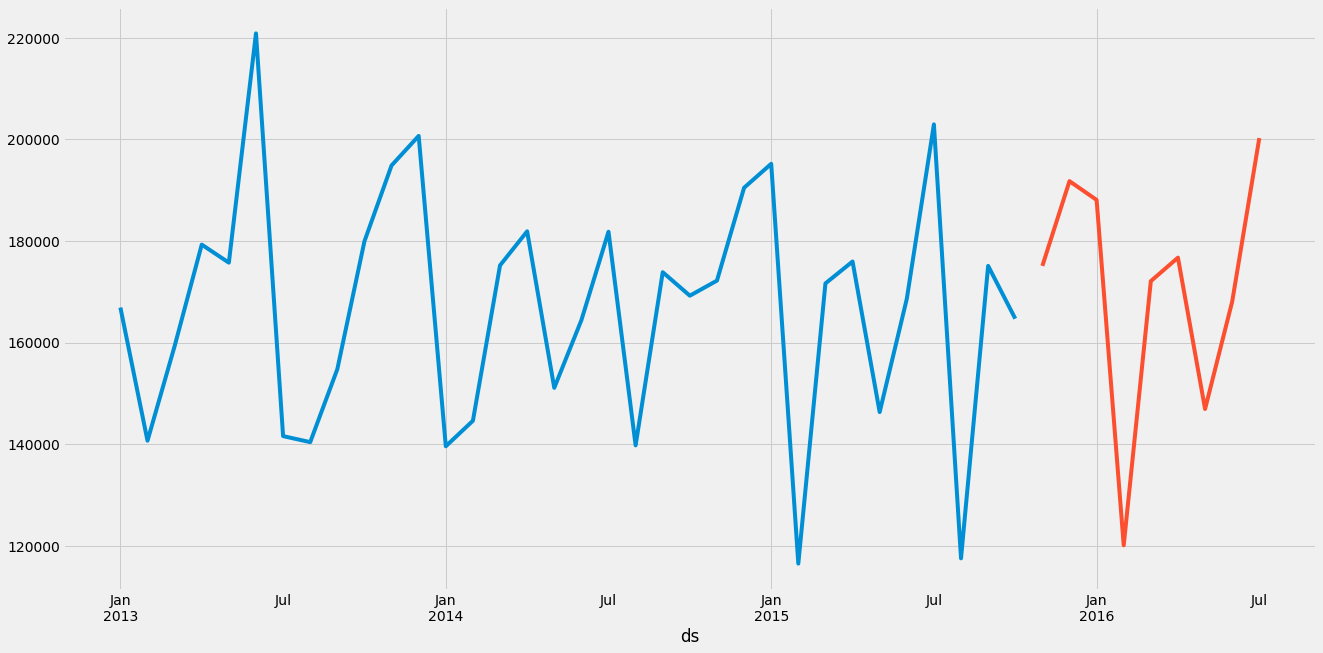

Current best ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:228.4400655025167


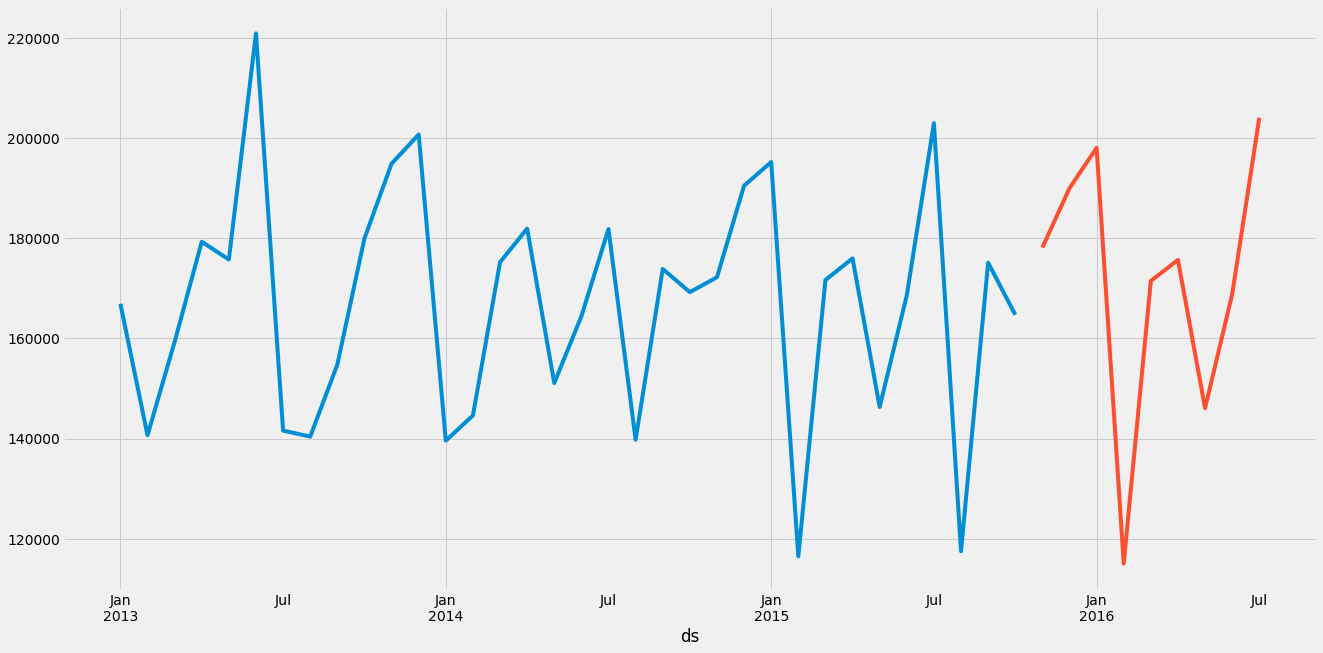

Current best ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:217.28255035720355


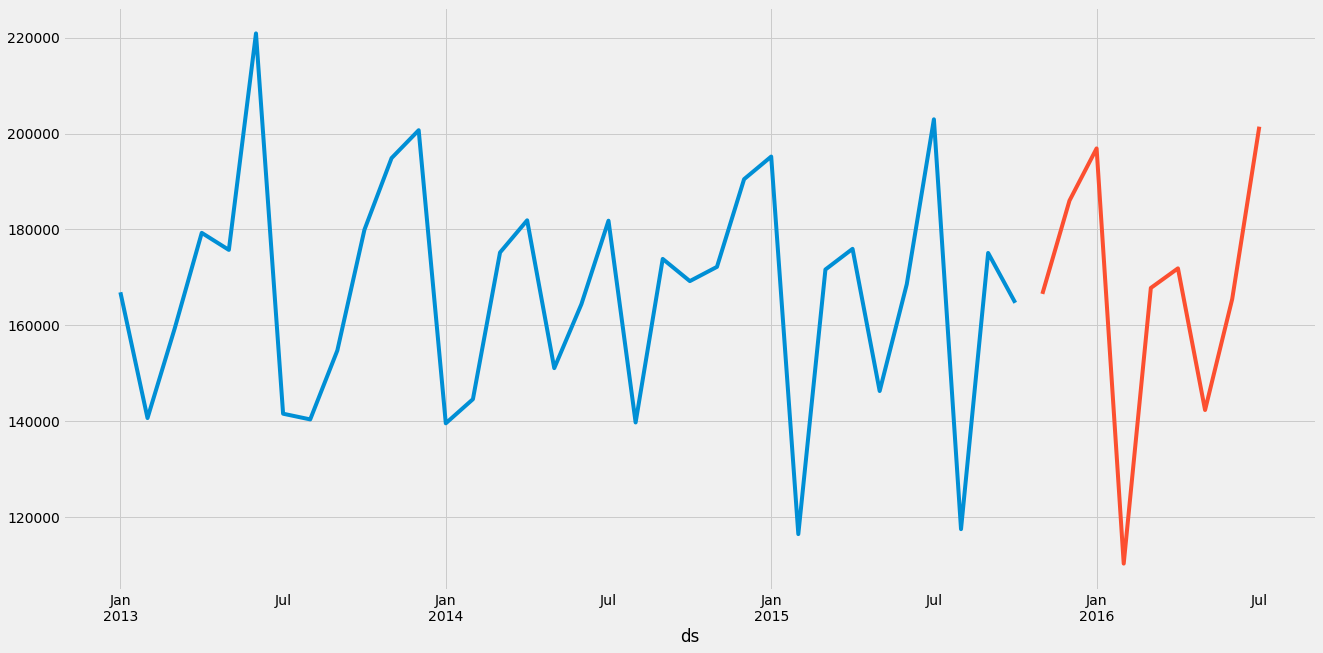

Current best ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:210.10580560079808


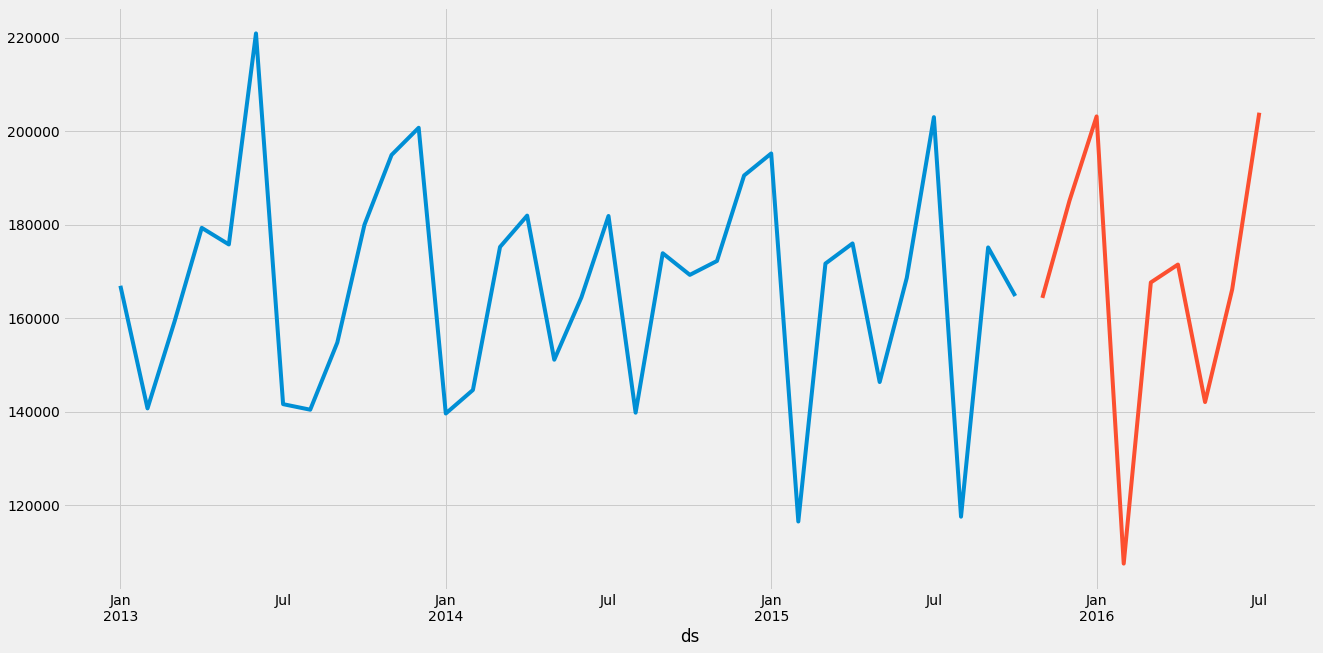

Current best ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:205.36916054898714


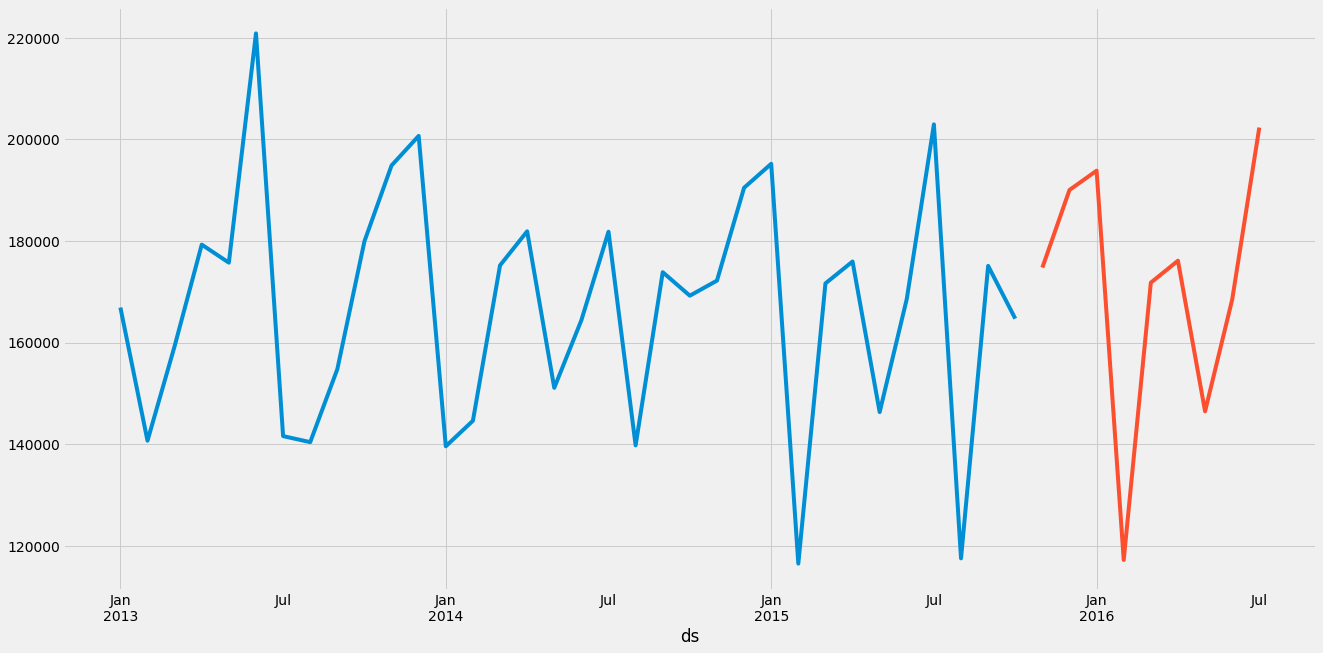

Current best ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:205.1157466251716


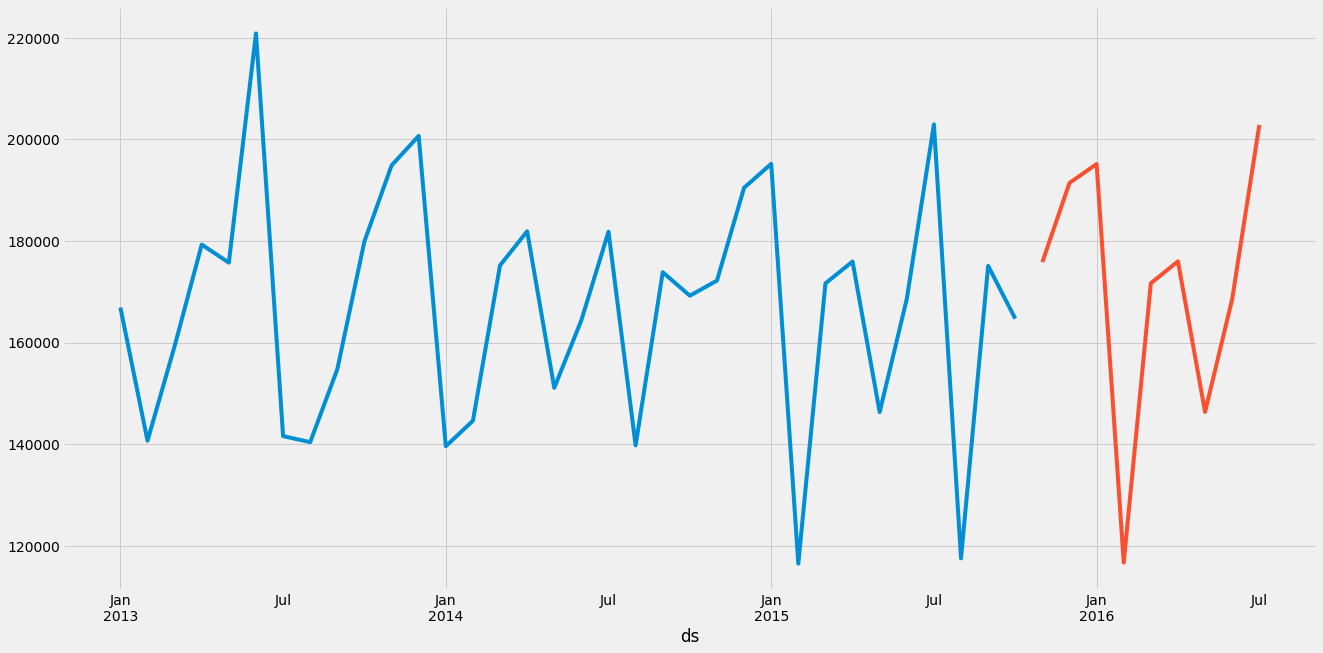

Current best ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:188.80385769702053


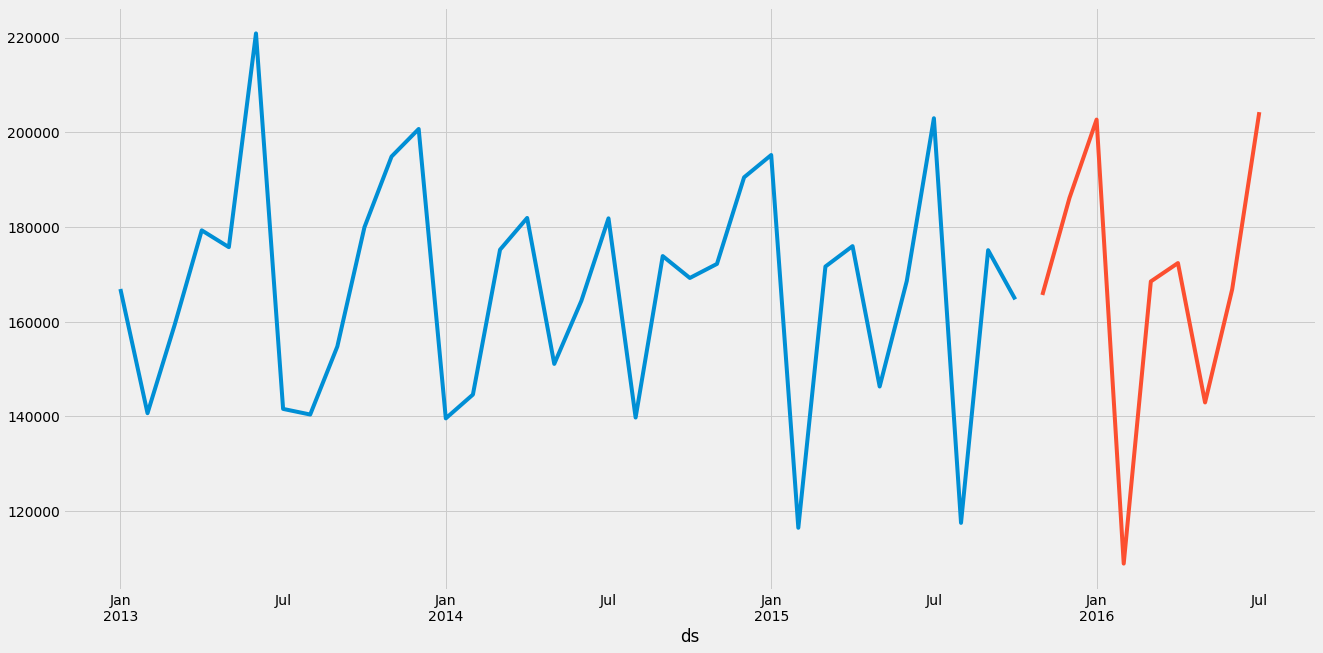

Current best ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:188.73562513988418


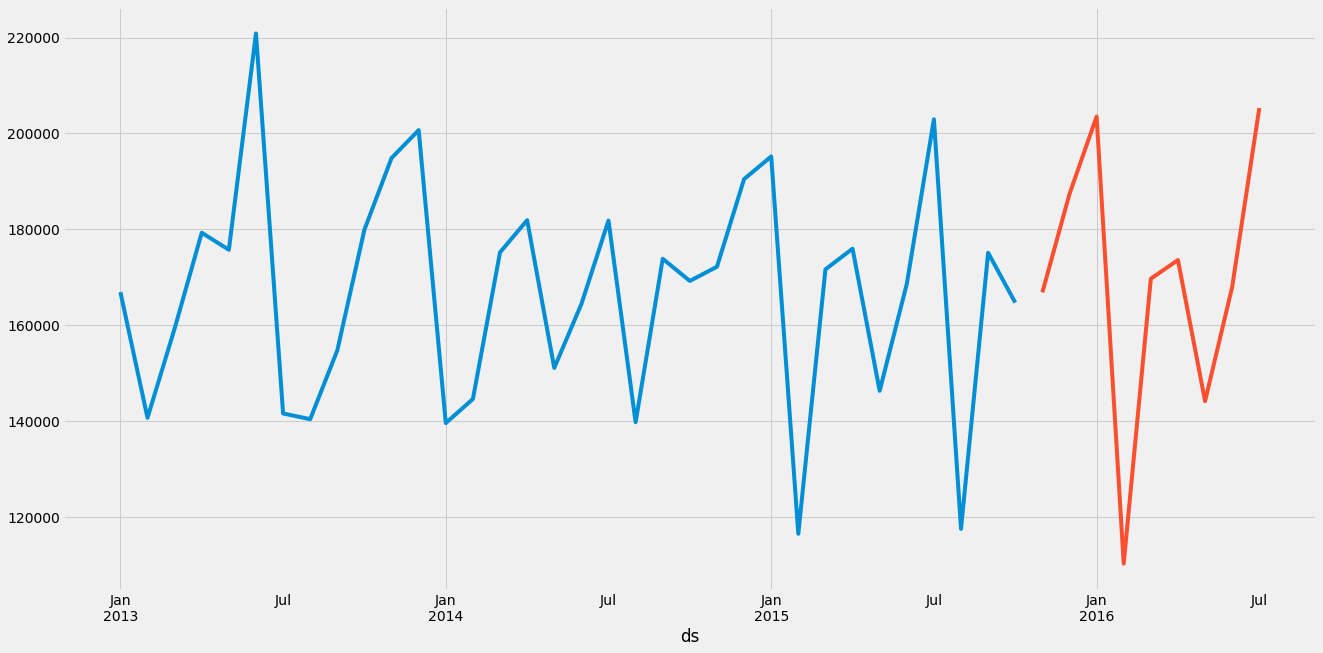

Product_ID :  4    Country :  Finland
Product_ID :  4    Country :  Finland


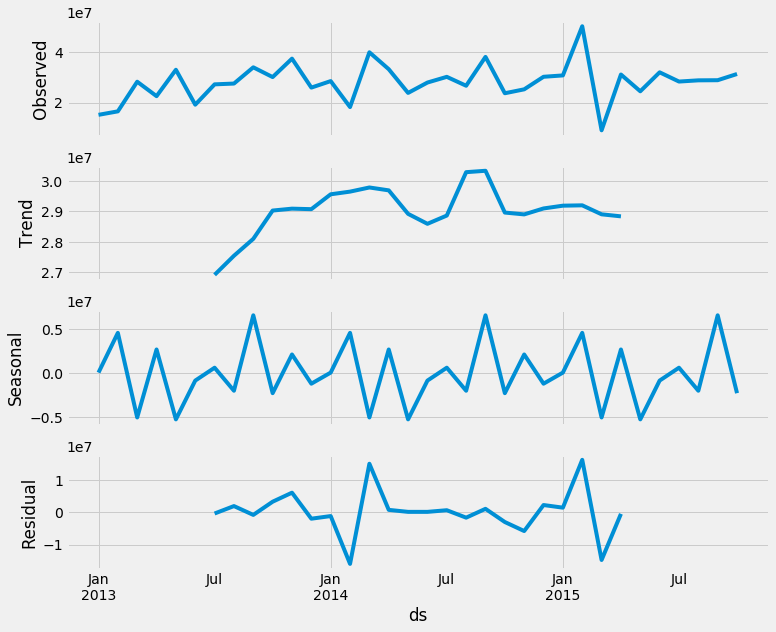

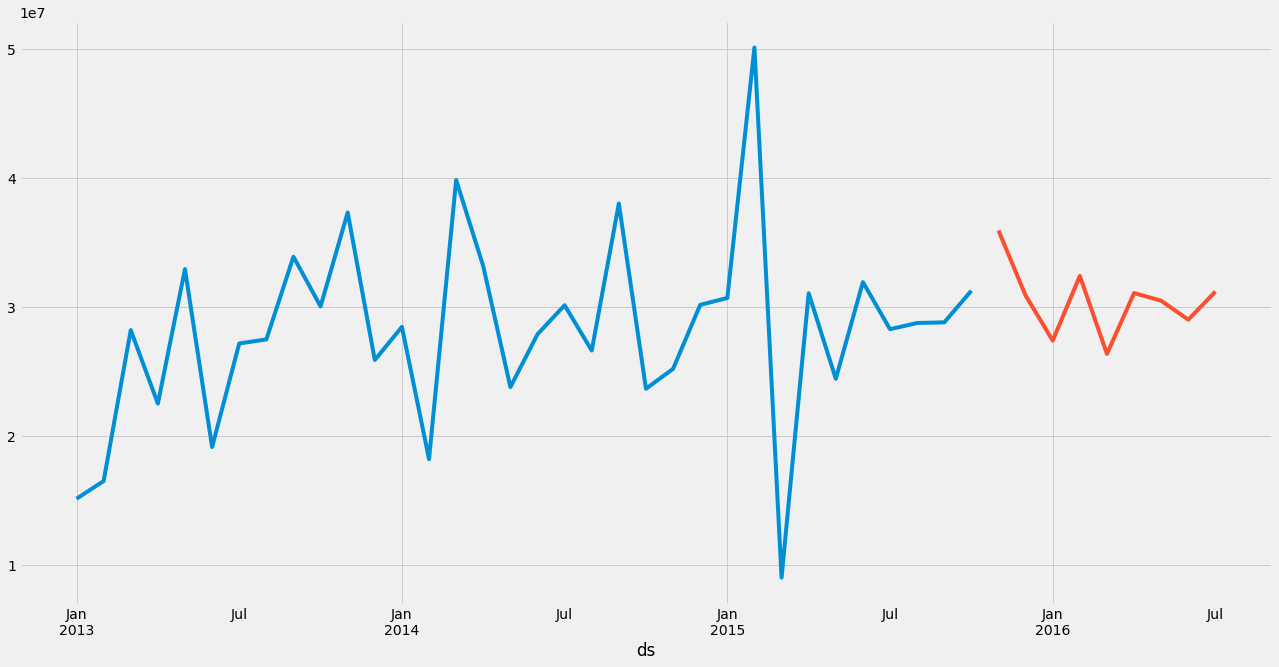

Product_ID :  4    Country :  Finland
Current best ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1230.6433598163003


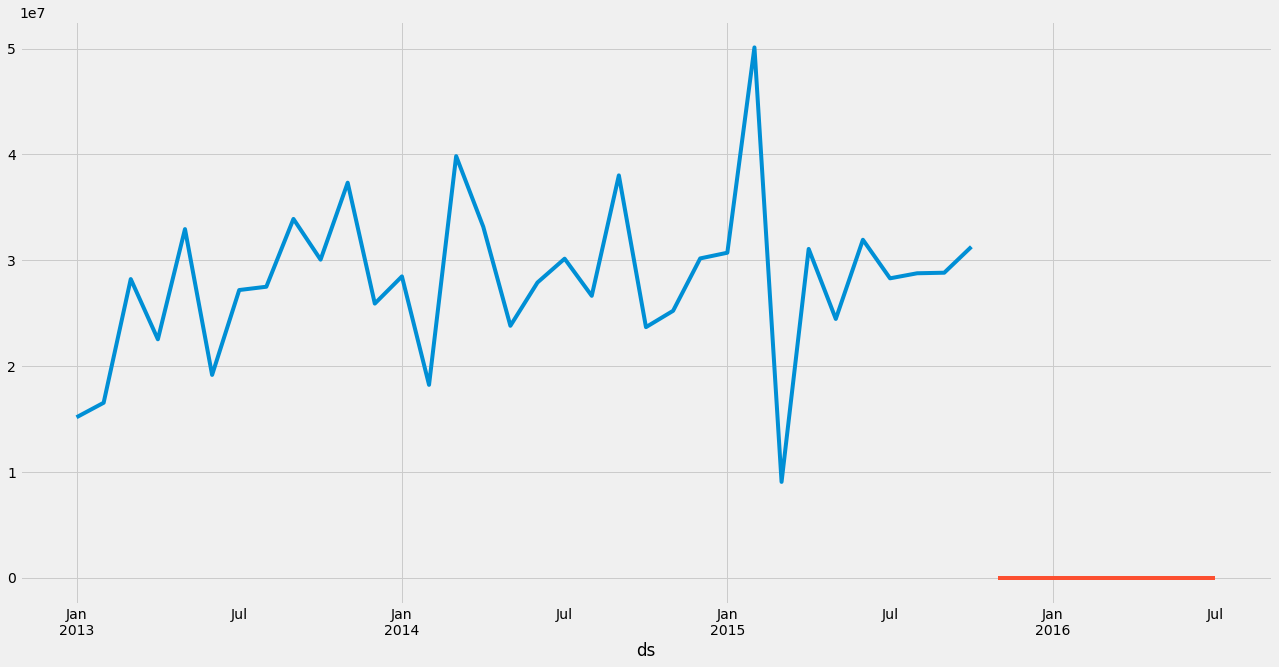

Current best ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:746.6276123309387


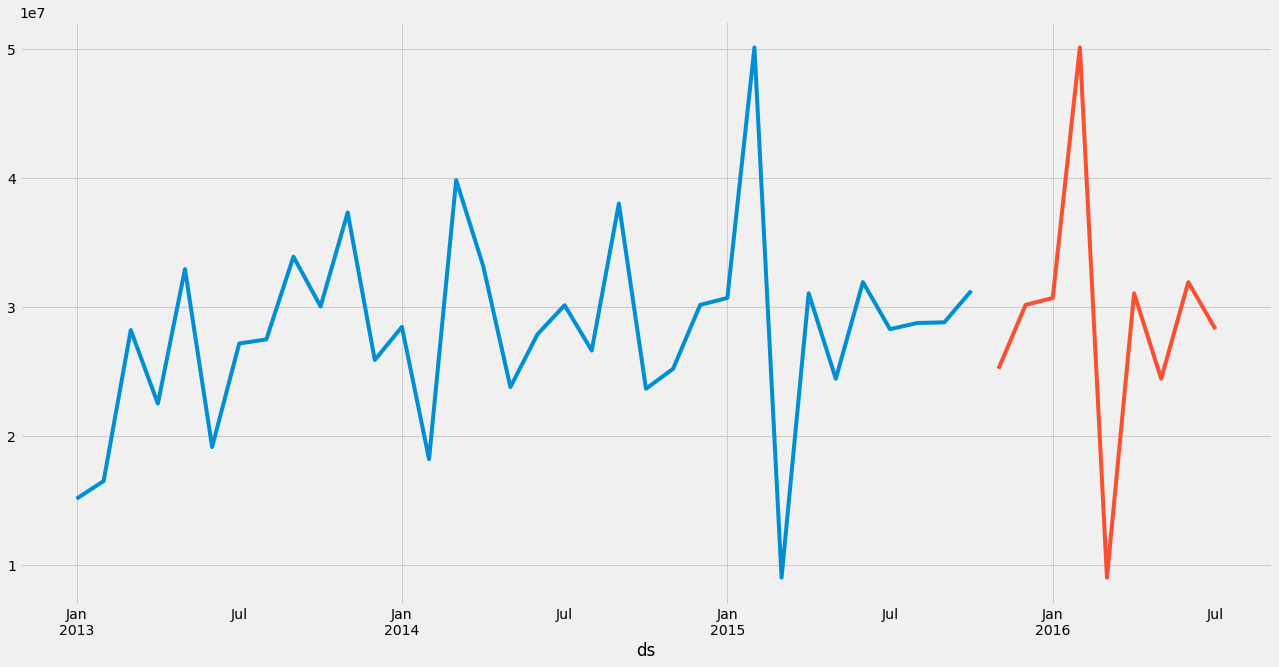

Current best ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:361.38631871038336


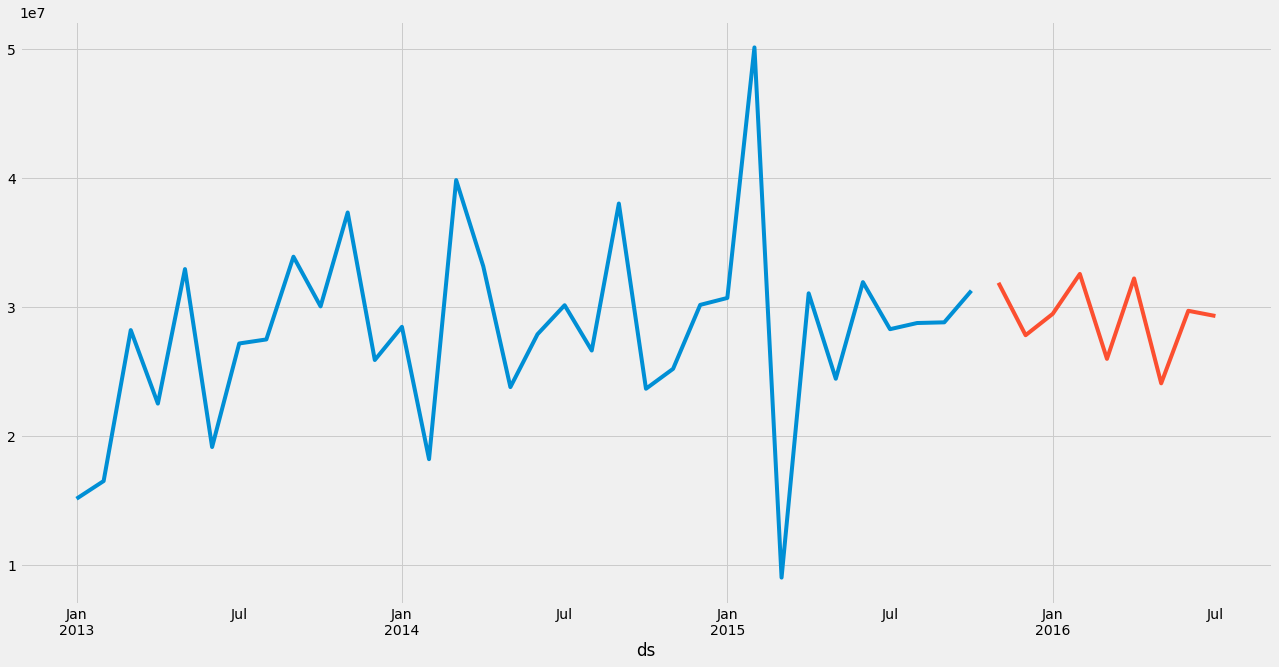

Current best ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:358.544153380155


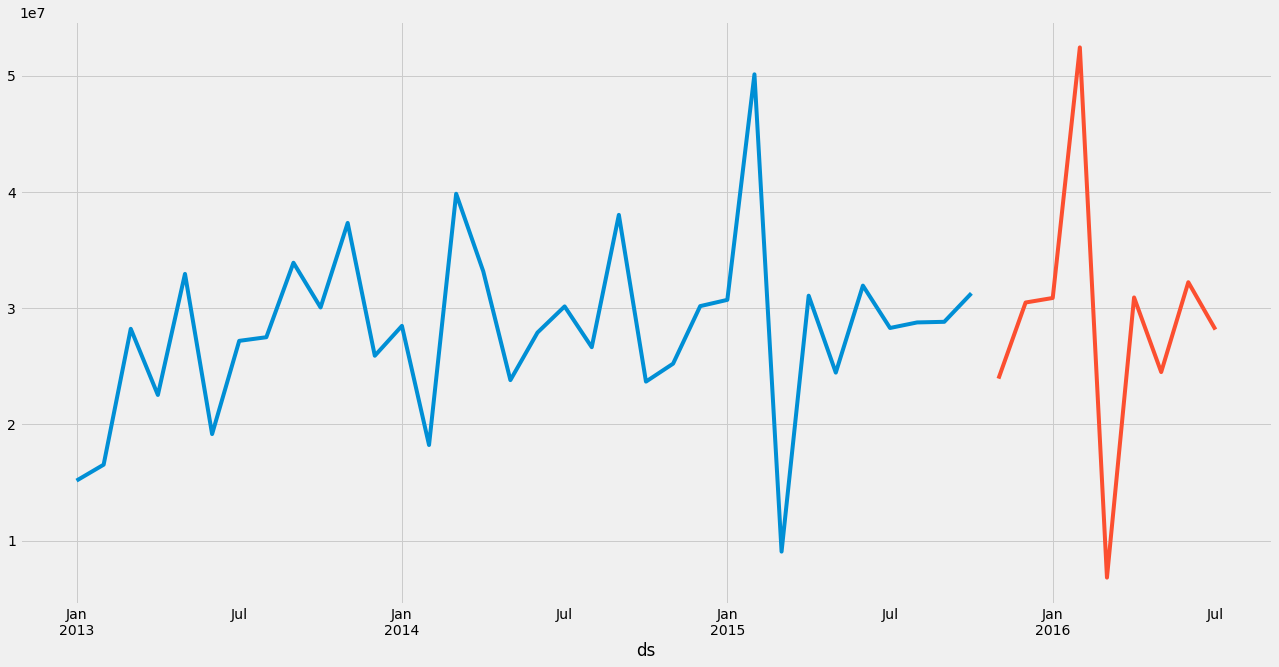

Current best ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:334.79125319480613


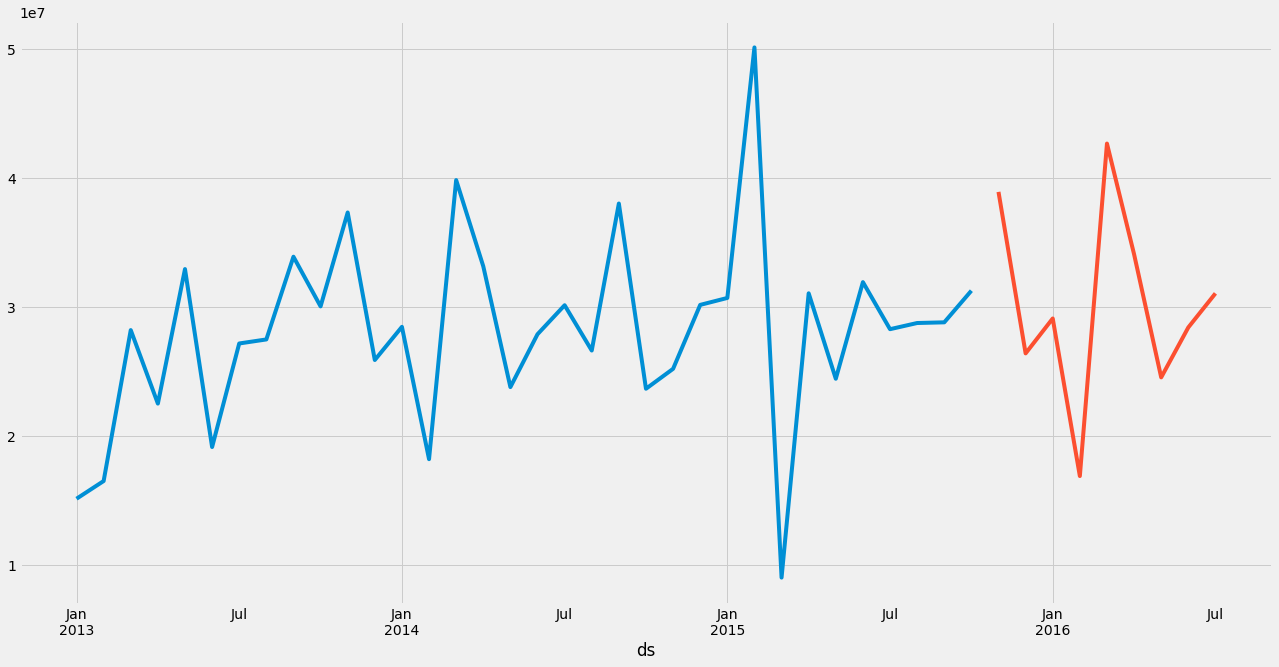

Current best ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:327.393970586377


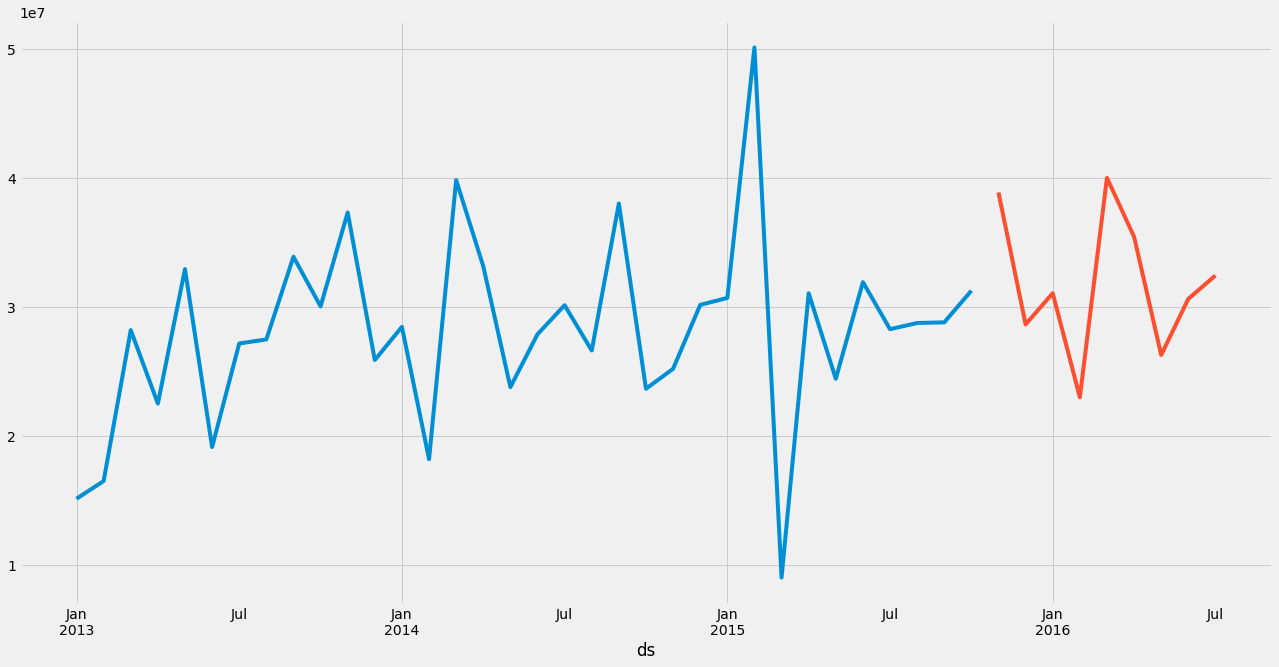

Current best ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:325.8301348315473


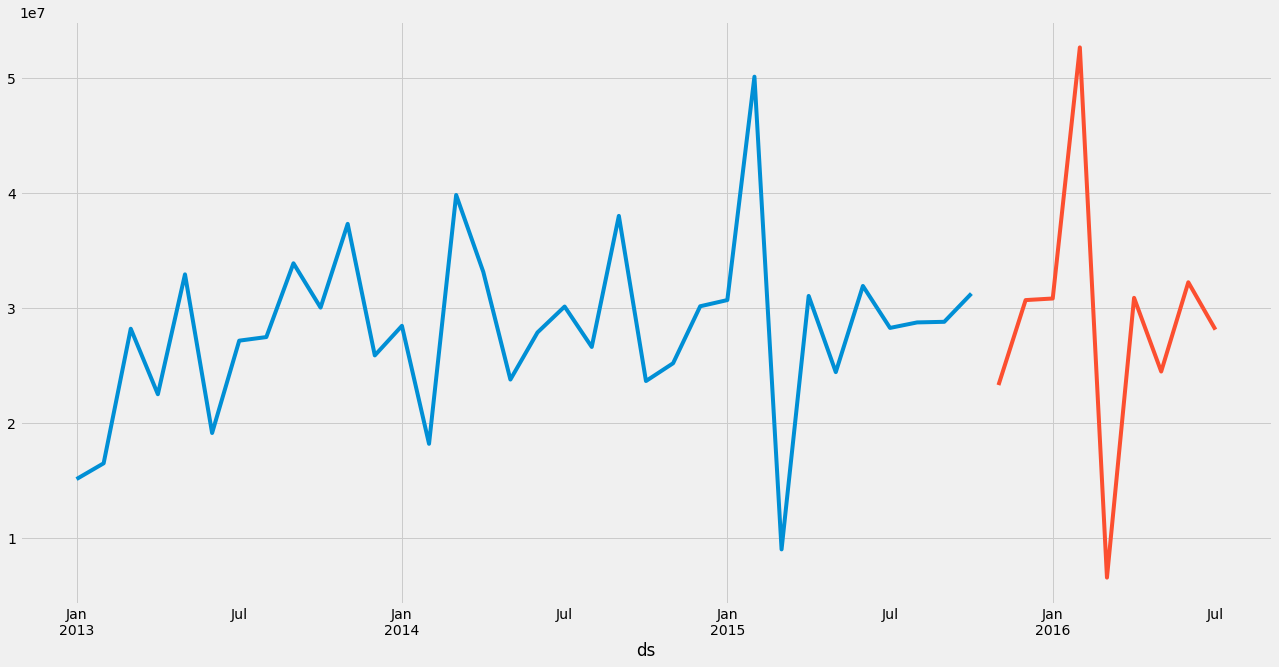

Current best ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:293.4567031290359


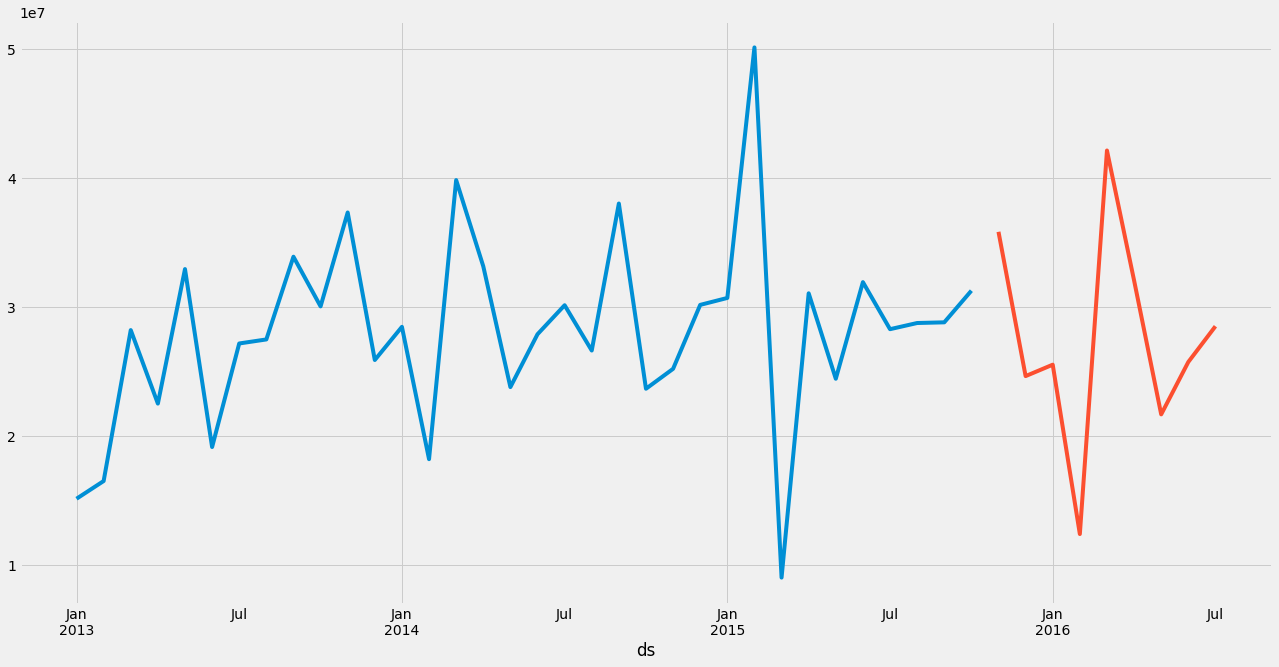

Current best ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:290.78267209028013


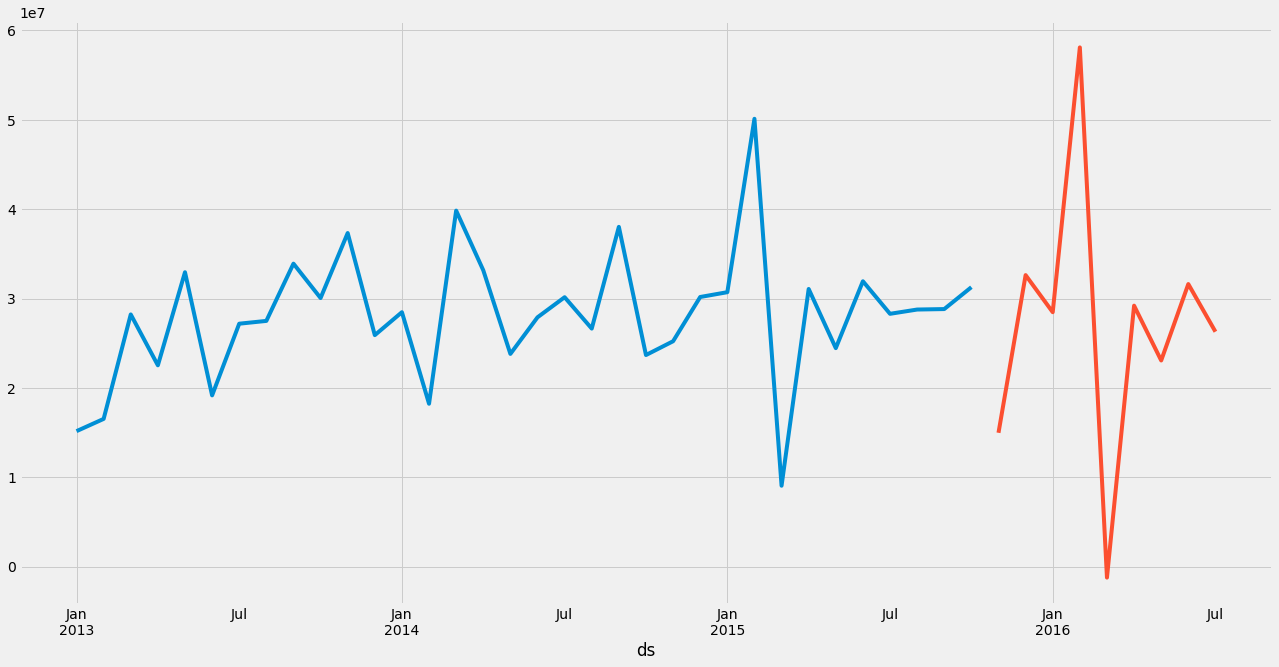

Product_ID :  5    Country :  England
Product_ID :  5    Country :  England


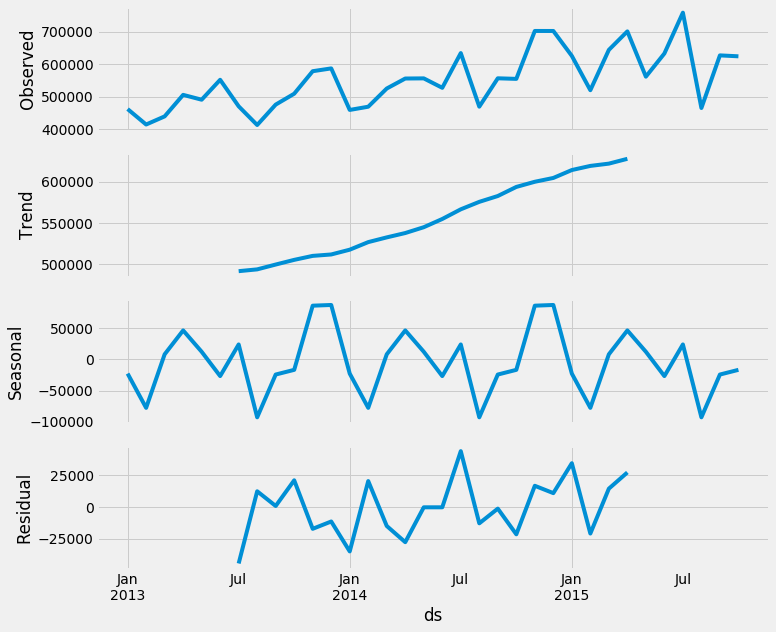

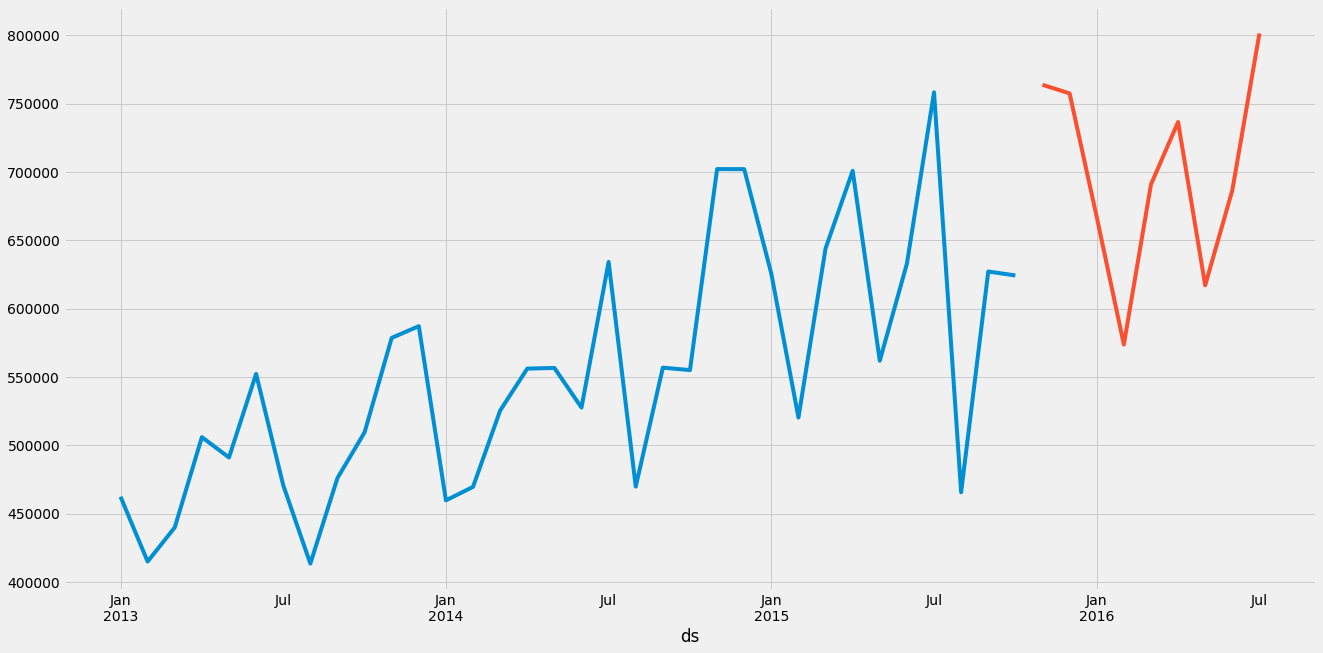

Product_ID :  5    Country :  England
Current best ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:969.4228946259578


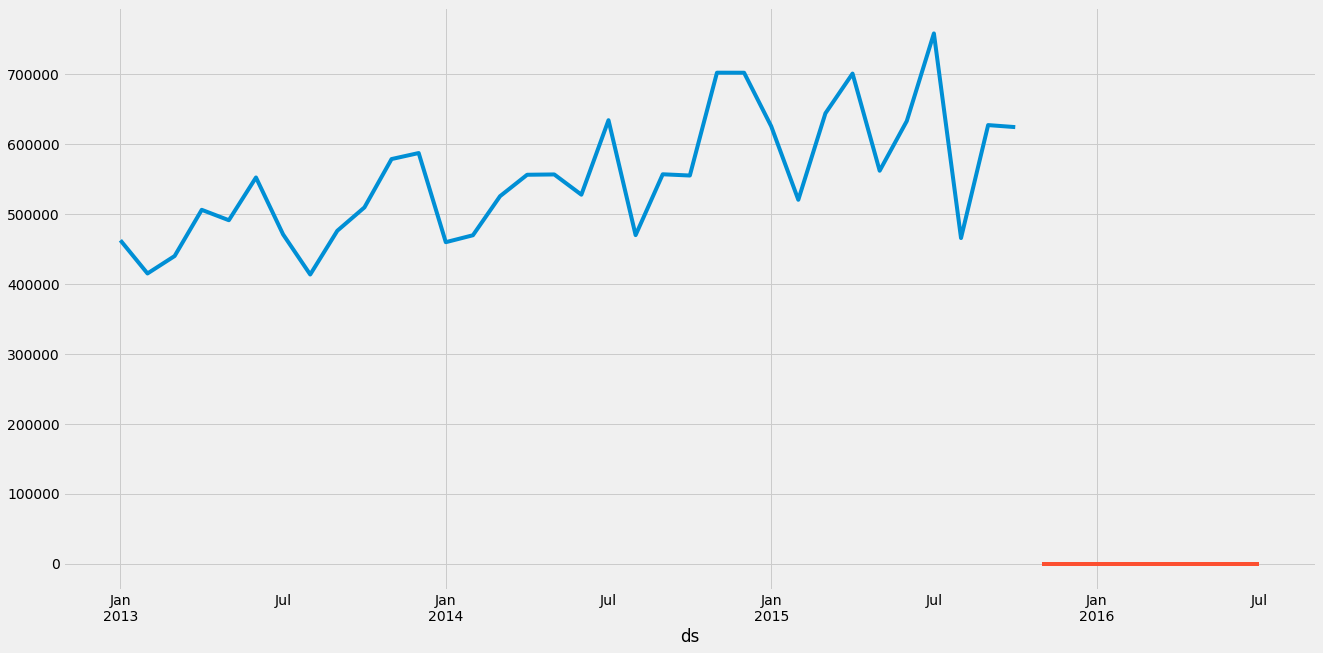

Current best ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:545.4691165175375


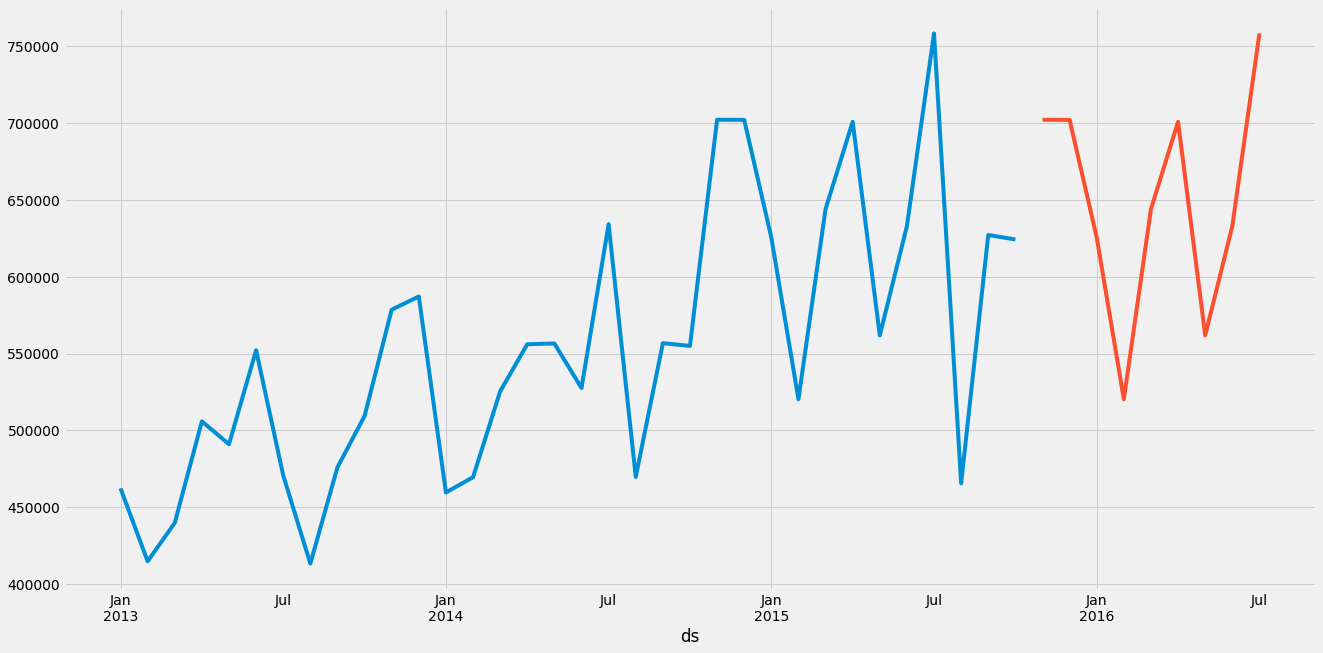

Current best ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:543.7954006873385


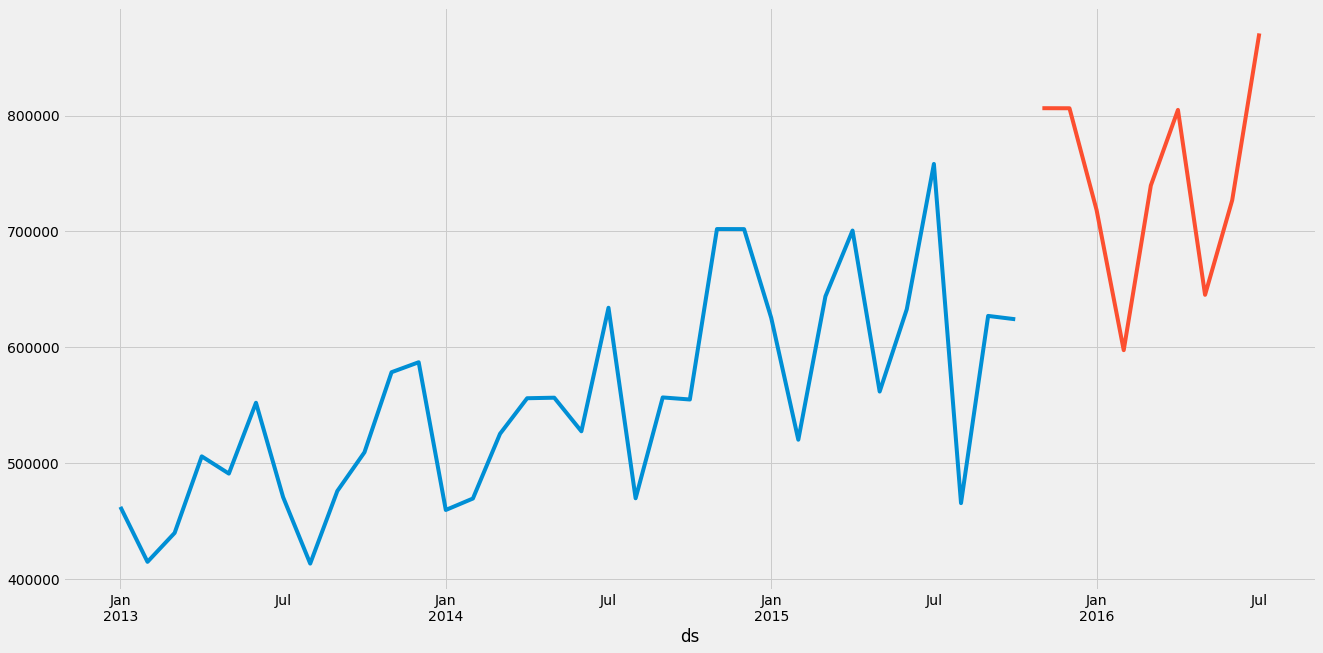

Current best ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:258.0343371281275


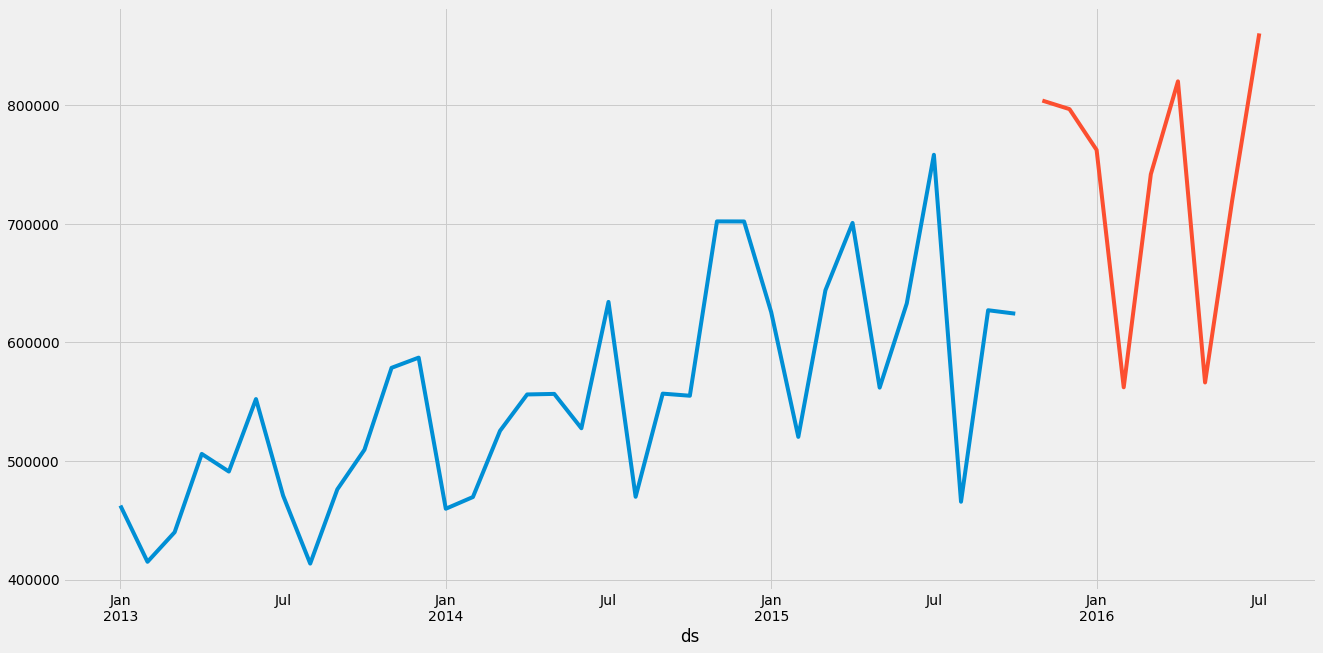

Current best ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:257.60933053425435


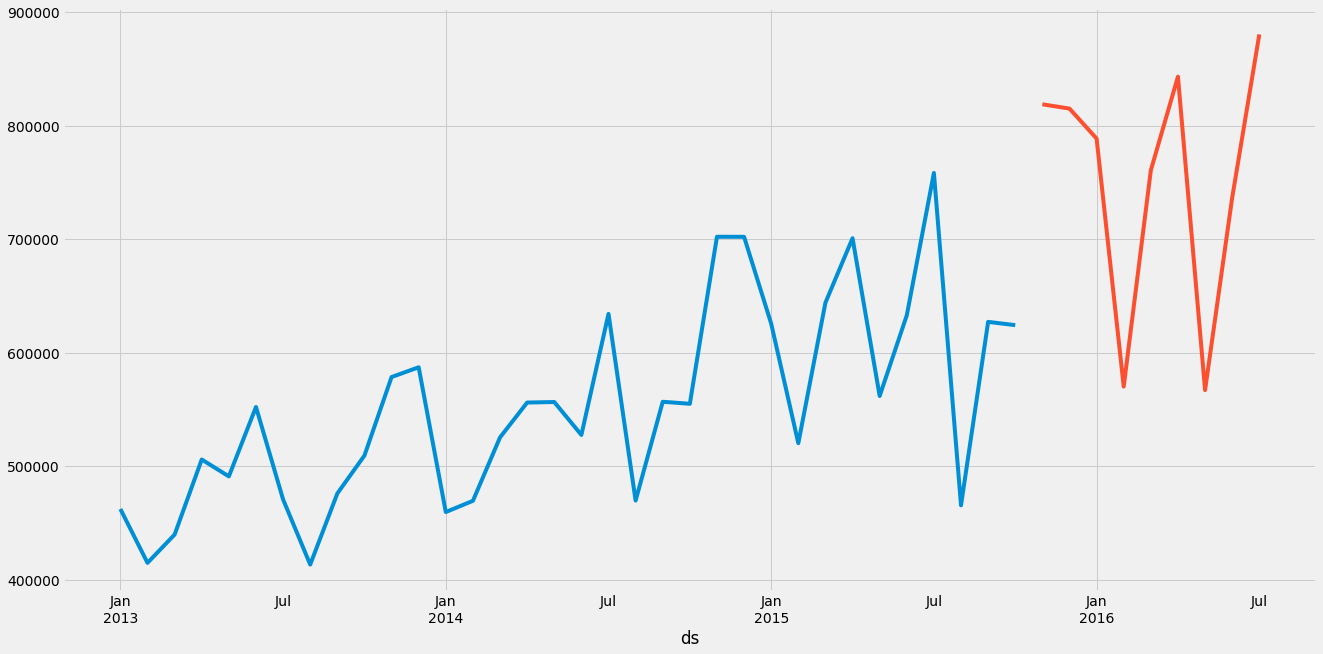

Current best ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:234.54167535137597


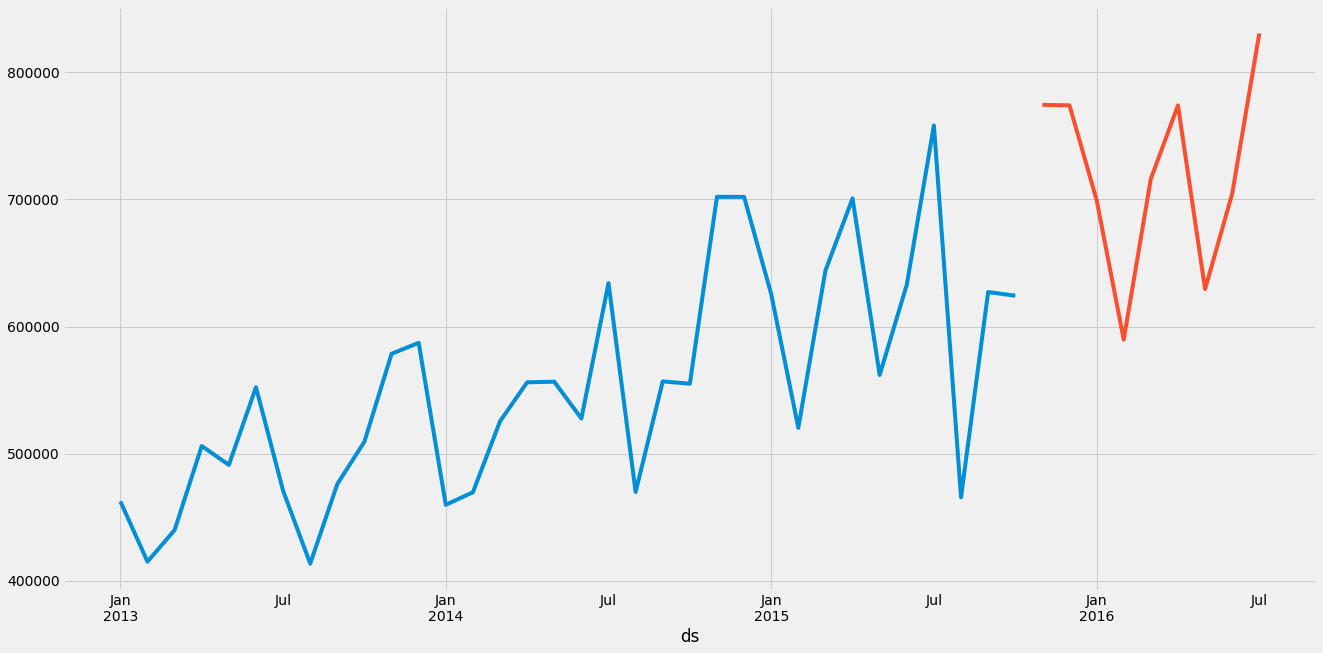

Current best ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:228.56662898825746


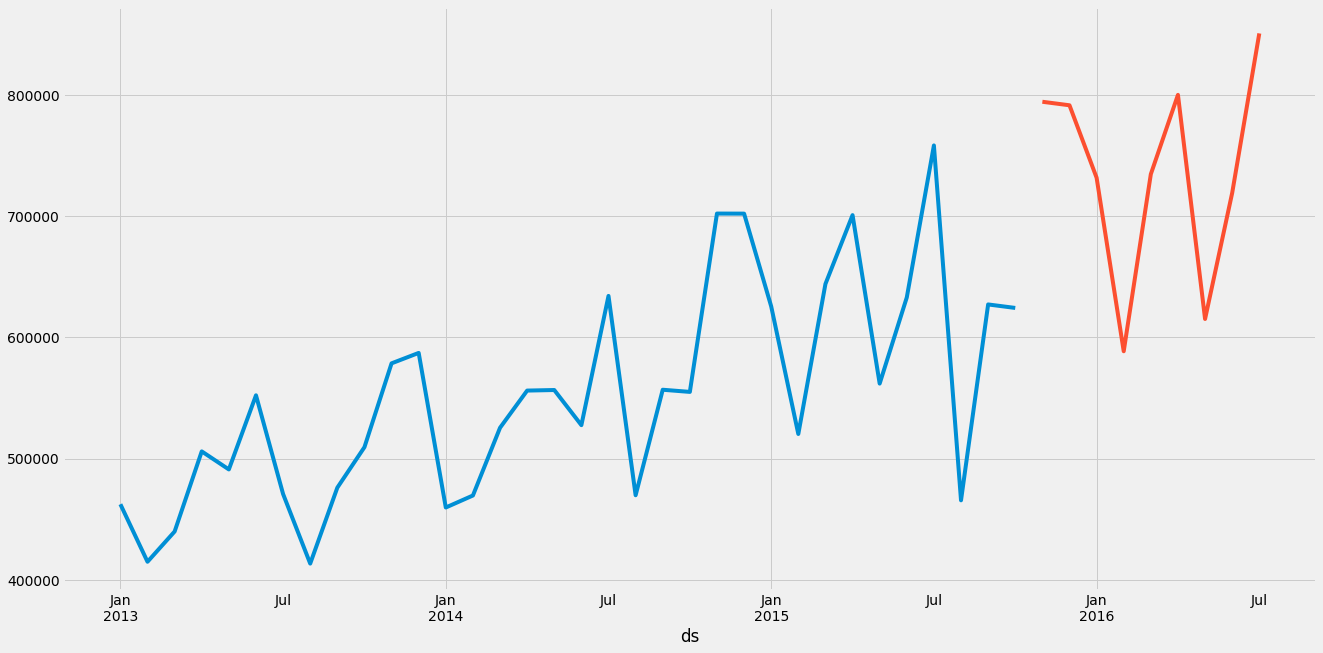

Current best ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:207.25171503008886


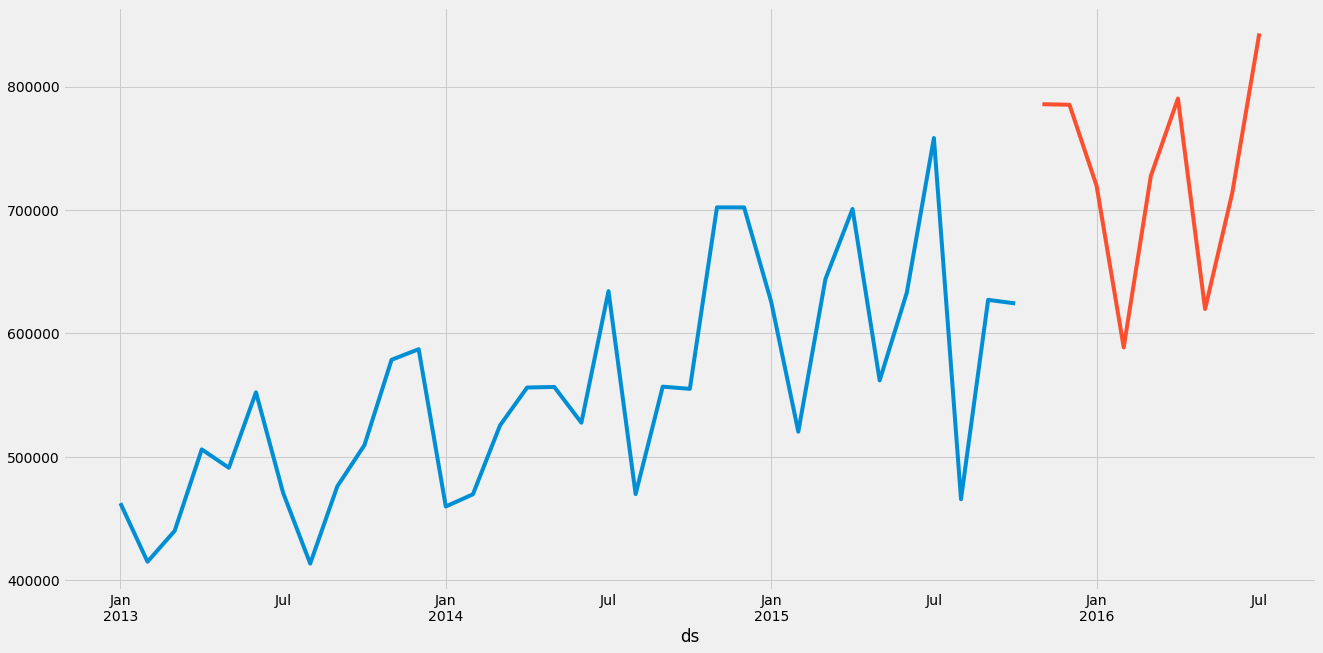

Current best ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:204.18704807378822


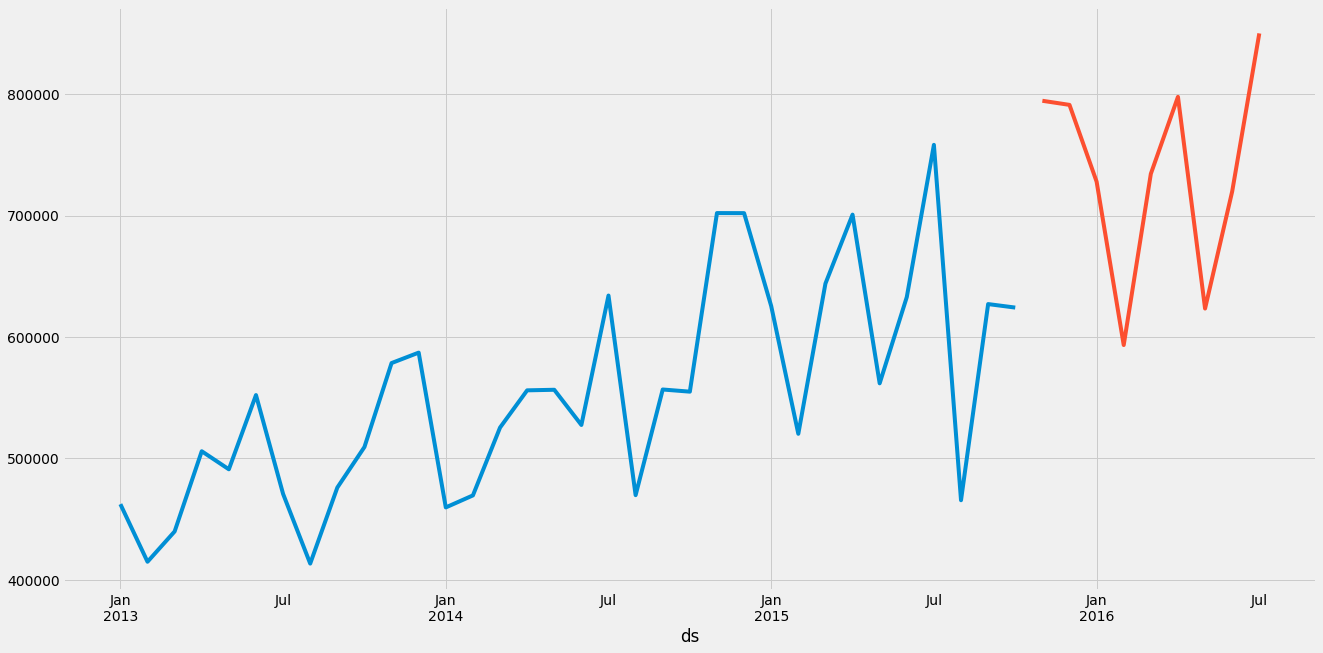

In [68]:
print('=================================================================================================')
print('=================================================================================================')
for i in range(1,len(set(train_visual['Product_ID']))+1):
    tmp = list(set(train_visual[train_visual['Product_ID']==i]['Country']))
    for j in tmp:
        print('Product_ID : ',i,'  ','Country : ',j)
        investigate(i=i,j=j)
        arima_investigate(i=i,j=j)
        print('=================================================================================================')
        print('=================================================================================================')

In [58]:
# arima_investigate(i=3,j='Argentina') (0, 0, 0)x(0, 1, 0, 12)
# arima_investigate(i=4,j='Finland') (0, 0, 0)x(0, 1, 0, 12)
# arima_investigate(i=1,j='Argentina')

In [60]:
# arima_custom(i=3,j='Argentina',best_param=(0, 0, 0),best_param_seasonal=(0, 1, 0, 12))
# arima_custom(i=4,j='Finland',best_param=(0, 0, 0),best_param_seasonal=(0, 1, 0, 12))
# arima_custom(i=1,j='Argentina',best_param=(1, 0, 0),best_param_seasonal=(0, 1, 0, 12))


In [65]:
res = calculate_arima_for(i=3,j='Argentina',best_param=(0,0,0),best_param_seasonal=(0,1,0,12))
res = pd.concat([res,calculate_arima_for(i=4,j='Finland',best_param=(0,0,0),best_param_seasonal=(0,1,0,12))],0)
res = pd.concat([res,calculate_arima_for(i=1,j='Argentina',best_param=(1,0,0),best_param_seasonal=(0,1,0,12))],0)

Product_ID :  3    Country :  Argentina
Product_ID :  4    Country :  Finland
Product_ID :  1    Country :  Argentina


In [67]:
sub = pd.read_csv('holt_winters_best.csv')

In [ ]:
sub 